In [6]:
import glob
import os
import re
import json
import scipy
import requests
import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statistics import median
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from math import sqrt
from datetime import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
from os.path import dirname, abspath, join
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from patsy import dmatrices


# Read in data

In [7]:
CONFIG_DIR = dirname(abspath(''))
directory = join(CONFIG_DIR,'processed', 'DATA_IN_USE.csv')
# directory = join(CONFIG_DIR, 'Files','Project')
# directory = join(CONFIG_DIR, 'Desktop','Internship', 'Project', 'Housing Dataset')
data = pd.read_csv(directory)
data.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'min_storey', 'max_storey', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price',
       'Distance to nearest MRT station', 'Nearest MRT station',
       'Distance to nearest Primary School', 'Nearest Primary School',
       'Distance to nearest Shopping Mall', 'Nearest Shopping Mall',
       'Distance to CBD', 'mature_estate', 'type_premium', 'Adjoined flat',
       'Apartment', 'DBSS', 'Improved', 'Maisonette', 'Model A',
       'Model A-Maisonette', 'Model A2', 'Multi Generation', 'New Generation',
       'Premium Apartment', 'Simplified', 'Standard', 'Terrace', 'Type S1',
       'Type S2', 'Others'],
      dtype='object')

In [707]:
# data = pd.read_csv(join(directory, 'resale-flat-prices-based-on-approval-date-1990-1999.csv'), parse_dates=True)
# data.head(10) # month is in YYYY/DD/MM

month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
3  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     07 TO 09   
4  1990-01  ANG MO KIO    3 ROOM   216  ANG MO KIO AVE 1     04 TO 06   
5  1990-01  ANG MO KIO    3 ROOM   211  ANG MO KIO AVE 3     01 TO 03   
6  1990-01  ANG MO KIO    3 ROOM   202  ANG MO KIO AVE 3     07 TO 09   
7  1990-01  ANG MO KIO    3 ROOM   235  ANG MO KIO AVE 3     10 TO 12   
8  1990-01  ANG MO KIO    3 ROOM   235  ANG MO KIO AVE 3     04 TO 06   
9  1990-01  ANG MO KIO    3 ROOM   232  ANG MO KIO AVE 3     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  
0            31.0        IMPROVED                 1977          9000  
1            31.0        IMPROVED                 1977          6000  
2            31.0        IMPROVED                 1977          8000  
3            31.0        IMPROVED                 1977          6000  
4            73.0  NEW GENERATION                 1976         47200  
5            67.0  NEW GENERATION                 1977         46000  
6            67.0  NEW GENERATION                 1977         42000  
7            67.0  NEW GENERATION                 1977         38000  
8            67.0  NEW GENERATION                 1977         40000  
9            67.0  NEW GENERATION                 1977         47000

In [708]:
# os.chdir(directory)
# os.getcwd()

'C:\\Users\\Carel\\Files\\Project'

In [1250]:
# raw_approval = glob.glob(directory + "\\resale-flat-prices-based-on-approval-date-*.csv")
# raw_registration = glob.glob(directory + '\\resale-flat-prices-based-on-registration-date-from-*.csv')
# # print(raw_approval[1:])
# print(raw_registration[1])

C:\Users\Carel\Files\Project\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv


In [1251]:
# # df_approval= pd.concat((pd.read_csv(f, header = 0) for f in raw_approval[1:])) #look from 2000 onwards
# df_approval = df_approval.reset_index(drop=True)
# df_approval.to_csv("APPROVAL_ALL.csv", index=False)

In [1252]:
# dt_approval = pd.read_csv(directory + '\\APPROVAL_ALL.csv', header=0, parse_dates=['month'])
# dt_approval

# Preprocess

## 'remaining_lease' variable (Adding & renaming)

In [1253]:
def rename_remain_lease(dt_month):
    newyr = []
    for duration in dt_month['remaining_lease']:
        month = str(duration)[9:11]
        year = str(duration)[:2]
        if month == '':
            newyr.append(int(year))
        elif int(month) >= 5:
            new_year = int(year) + 1
            newyr.append(new_year)
        else: 
            newyr.append(int(year))
#     print(len(newyr))
    dt_month['remaining_lease'] = newyr
    return dt_month


In [1254]:
def add_remain_lease(filename):
# for filename in raw_registration:
    dt = pd.read_csv(filename, header=0, parse_dates = ['month'])
    #check for NA values
#     print(dt.isnull().sum())
    if np.all(~dt.columns.isin(['remaining_lease'])):
        rem_lease = []
        for rows in dt.values:
            years = rows[0].year - rows[8]
            remain = 99 - years
            rem_lease.append(remain)
        #     rem_lease[i] = dt_missing['month'][i].year - dt_missing['lease_commence_date'][i]
        # print(rem_lease)
        dt.insert(9, 'remaining_lease', rem_lease)
#         print(dt)
        print(str(filename) + ' now has \'remaining_lease\' variable')
    else:
        print(str(filename) +' already has \'remaining_lease\' variable')

    return dt

# dt_approval = [add_remain_lease(x1) for x1 in raw_approval[1:]]
# dt_approval = pd.concat(dt_approval)
# print(dt_approval)
# print('-----end----')

# d = [add_remain_lease(x) for x in raw_registration[0:2]]
# print('-----end----')
# new_d = [rename_remain_lease(a) for a in d] #alr renamed the remaining_lease and all files have this variable
# print(new_d)
# dt_use = pd.concat(new_d)
# # dt_regis = dt_regis.sort_values('month') #sort by ascending order based on the dates (2012 - 2020)
# dt_use

d = add_remain_lease(raw_registration[1])
dt_use = pd.read_csv(raw_registration[1], header=0)
dt_use = [rename_remain_lease(d)][0] #reanmed the remaining_lease and all files have this variables
dt_use

C:\Users\Carel\Files\Project\resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv already has 'remaining_lease' variable


month        town  flat_type block        street_name storey_range  \
0     2017-01-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1     2017-01-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2     2017-01-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3     2017-01-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4     2017-01-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...          ...         ...        ...   ...                ...          ...   
66492 2020-01-01      YISHUN  EXECUTIVE  355A     YISHUN RING RD     01 TO 03   
66493 2020-01-01      YISHUN  EXECUTIVE   604       YISHUN ST 61     01 TO 03   
66494 2020-01-01      YISHUN  EXECUTIVE   606       YISHUN ST 61     01 TO 03   
66495 2020-01-01      YISHUN  EXECUTIVE   611       YISHUN ST 61     01 TO 03   
66496 2020-01-01      YISHUN  EXECUTIVE   824       YISHUN ST 81     01 TO 03   

       floor_area_sqm      flat_model  lease_commence_date  remaining_lease  \
0                44.0        Improved                 1979               61   
1                67.0  New Generation                 1978               61   
2                67.0  New Generation                 1980               63   
3                68.0  New Generation                 1980               62   
4                67.0  New Generation                 1980               63   
...               ...             ...                  ...              ...   
66492           145.0      Maisonette                 1988               68   
66493           164.0       Apartment                 1992               72   
66494           146.0      Maisonette                 1987               67   
66495           146.0      Maisonette                 1987               67   
66496           145.0       Apartment                 1987               67   

       resale_price  
0          232000.0  
1          250000.0  
2          262000.0  
3          265000.0  
4          265000.0  
...             ...  
66492      545000.0  
66493      665000.0  
66494      564500.0  
66495      550000.0  
66496      630000.0  

[66497 rows x 11 columns]

## Getting the premiums based on flat_type and flat_model

In [1255]:
type_data = dt_use.groupby(['flat_type']).median()
type_data['flat_premium'] = type_data['resale_price'] - type_data['resale_price'].median()
premium = []
for i in tqdm(range(len(np.unique(dt_use['flat_type'])))):
    for j in tqdm(range(len(dt_use))):
        if dt_use['flat_type'].iloc[j] == np.unique(dt_use['flat_type'])[i]:
            premium.append(type_data['flat_premium'][i]) 














  0%|          | 0/7 [00:00<?, ?it/s]













  0%|          | 0/66497 [00:00<?, ?it/s]













  0%|          | 3/66497 [00:00<58:59, 18.79it/s]













  0%|          | 5/66497 [00:00<1:07:23, 16.44it/s]













  0%|          | 7/66497 [00:00<1:10:22, 15.75it/s]













  0%|          | 9/66497 [00:00<1:12:26, 15.30it/s]













  0%|          | 11/66497 [00:00<1:11:46, 15.44it/s]













  0%|          | 13/66497 [00:00<1:14:23, 14.90it/s]













  0%|          | 15/66497 [00:01<1:18:40, 14.08it/s]













  0%|          | 17/66497 [00:01<1:21:25, 13.61it/s]













  0%|          | 19/66497 [00:01<1:22:32, 13.42it/s]













  0%|          | 21/66497 [00:01<1:25:13, 13.00it/s]













  0%|          | 23/66497 [00:01<1:26:01, 12.88it/s]













  0%|          | 25/66497 [00:01<1:23:22, 13.29it/s]













  0%|          | 27/66497 [00:01<1:25:26, 12.97it/s]













  0%|          | 29/66497 [00

KeyboardInterrupt: 

In [1256]:
dt_use['type_premium'] = premium
dt_use

ValueError: Length of values does not match length of index















  0%|          | 48/66497 [00:22<1:24:16, 13.14it/s]

In [885]:
# model_data = dt_use.groupby(['flat_model']).median()
# model_data['flat_premium'] = model_data['resale_price'] - model_data['resale_price'].median()

# model_premium1 = []
# for i in tqdm(range(len(np.unique(dt_use['flat_model'])))):
#     for j in tqdm(range(len(dt_use))):
#         if dt_use['flat_model'].iloc[j] == np.unique(dt_use['flat_model'])[i]:
#             model_premium1.append(model_data['flat_premium'][i])
# dt_use['flat_model_premium']= model_premium1
# dt_use













  0%|          | 0/20 [00:00<?, ?it/s]












  0%|          | 0/66497 [00:00<?, ?it/s]












  0%|          | 5/66497 [00:00<26:18, 42.11it/s]












  0%|          | 9/66497 [00:00<26:47, 41.37it/s]












  0%|          | 14/66497 [00:00<26:54, 41.18it/s]












  0%|          | 19/66497 [00:00<26:47, 41.35it/s]












  0%|          | 24/66497 [00:00<26:46, 41.37it/s]












  0%|          | 29/66497 [00:00<26:42, 41.48it/s]












  0%|          | 34/66497 [00:00<26:46, 41.36it/s]












  0%|          | 39/66497 [00:00<26:53, 41.18it/s]












  0%|          | 44/66497 [00:01<26:54, 41.16it/s]












  0%|          | 49/66497 [00:01<26:51, 41.24it/s]












  0%|          | 54/66497 [00:01<26:57, 41.09it/s]












  0%|          | 59/66497 [00:01<26:54, 41.15it/s]












  0%|          | 64/66497 [00:01<26:51, 41.23it/s]

























  0%|          | 0/20 [00:01<?, ?it/s]            


KeyboardInterrupt: 

In [ ]:
# area_data = dt_use.groupby(['town']).median()
# area_data['area_premium'] = area_data['resale_price'] - area_data['resale_price'].median()

# town_premium = []
# for i in tqdm(range(len(np.unique(dt_use['town']))):
#     for j in tqdm(range(len(dt_use))):
#         if dt_use['town'].iloc[j] == np.unique(dt_use['town'])[i]:
#             town_premium.append(area_data['area_premium'][i])
# dt_use['town_premium']= town_premium
# dt_use

## Addition of mature_estate binary variable (xDecoding of flat_model & flat_type variable)

In [1257]:
# def decode_var(data):
#     # Rename MULTI-GENERATION to MULTI GENERATION
#     data['flat_type']= [re.sub('^MULTI-','MULTI ', x) for x in data['flat_type']]
#     unique_values = np.unique(data['flat_type'])
# #     print(data['flat_type'].str.contains('MULTI-GENERATION').sum()) #check
# #     print(data['flat_type'].str.contains('MULTI GENERATION').sum())
    
#     data_copy = data.copy()
#     for room_type in unique_values:
#         data_copy[room_type] = np.where(data_copy['flat_type'].str.contains(room_type), 1, 0)
# #     data_copy = data_copy.drop(columns='flat_type')
#     return data_copy

def decode_var_model(data):
    unique_values = np.unique(data['flat_model'])
    data_copy = data.copy()
    for model in unique_values:
        data_copy[model] = np.where(data_copy['flat_model'].str.contains(model), 1, 0)
    combine_feat = ['2-room', 'Improved-Maisonette', 'Premium Apartment Loft','Premium Maisonette']
    values = [0]*len(data)
    for i in range(len(data)):
        if data['flat_model'].iloc[i] in combine_feat:
            values[i] = 1
    data_copy['Others'] = values
    data_copy = data_copy.drop(columns=combine_feat)
#     data_copy = data_copy.drop(columns='flat_type')
    return data_copy

dt_use = decode_var_model(dt_use)
# dt_use = decode_var(dt_use)
dt_use.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'Adjoined flat', 'Apartment', 'DBSS',
       'Improved', 'Maisonette', 'Model A', 'Model A-Maisonette', 'Model A2',
       'Multi Generation', 'New Generation', 'Premium Apartment', 'Simplified',
       'Standard', 'Terrace', 'Type S1', 'Type S2', 'Others'],
      dtype='object')

In [1222]:
#Addition of bin var to indicate if a mature estate or not
def mature(dt):
    mature_area = ['ANG MO KIO','BEDOK','BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'CLEMENTI','GEYLANG',
                       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH']
    all_flats_town = dt['town']
    mature_est = []
    for flat_town in all_flats_town:
        if flat_town in mature_area:
            mature_est.append(1)
        else:
            mature_est.append(0)
    dt.insert(11, 'mature_estate', mature_est)
    return dt

dt_use = mature(dt_use)
dt_use

month        town  flat_type block        street_name storey_range  \
0     2017-01-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1     2017-01-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2     2017-01-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3     2017-01-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4     2017-01-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...          ...         ...        ...   ...                ...          ...   
66492 2020-01-01      YISHUN  EXECUTIVE  355A     YISHUN RING RD     01 TO 03   
66493 2020-01-01      YISHUN  EXECUTIVE   604       YISHUN ST 61     01 TO 03   
66494 2020-01-01      YISHUN  EXECUTIVE   606       YISHUN ST 61     01 TO 03   
66495 2020-01-01      YISHUN  EXECUTIVE   611       YISHUN ST 61     01 TO 03   
66496 2020-01-01      YISHUN  EXECUTIVE   824       YISHUN ST 81     01 TO 03   

       floor_area_sqm      flat_model  lease_commence_date  remaining_lease  \
0                44.0        Improved                 1979               61   
1                67.0  New Generation                 1978               61   
2                67.0  New Generation                 1980               63   
3                68.0  New Generation                 1980               62   
4                67.0  New Generation                 1980               63   
...               ...             ...                  ...              ...   
66492           145.0      Maisonette                 1988               68   
66493           164.0       Apartment                 1992               72   
66494           146.0      Maisonette                 1987               67   
66495           146.0      Maisonette                 1987               67   
66496           145.0       Apartment                 1987               67   

       ...  Model A2  Multi Generation  New Generation  Premium Apartment  \
0      ...         0                 0               0                  0   
1      ...         0                 0               1                  0   
2      ...         0                 0               1                  0   
3      ...         0                 0               1                  0   
4      ...         0                 0               1                  0   
...    ...       ...               ...             ...                ...   
66492  ...         0                 0               0                  0   
66493  ...         0                 0               0                  0   
66494  ...         0                 0               0                  0   
66495  ...         0                 0               0                  0   
66496  ...         0                 0               0                  0   

       Simplified  Standard  Terrace  Type S1  Type S2  Others  
0               0         0        0        0        0       0  
1               0         0        0        0        0       0  
2               0         0        0        0        0       0  
3               0         0        0        0        0       0  
4               0         0        0        0        0       0  
...           ...       ...      ...      ...      ...     ...  
66492           0         0        0        0        0       0  
66493           0         0        0        0        0       0  
66494           0         0        0        0        0       0  
66495           0         0        0        0        0       0  
66496           0         0        0        0        0       0  

[66497 rows x 30 columns]

In [1223]:
dt_use.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'mature_estate', 'type_premium',
       'Adjoined flat', 'Apartment', 'DBSS', 'Improved', 'Maisonette',
       'Model A', 'Model A-Maisonette', 'Model A2', 'Multi Generation',
       'New Generation', 'Premium Apartment', 'Simplified', 'Standard',
       'Terrace', 'Type S1', 'Type S2', 'Others'],
      dtype='object')

## Split storey_range variable

In [1224]:
def split_storey(data):
    min_storey = []
    max_storey = []
    for i in range(data.shape[0]):
        minimum = data['storey_range'].values[i][:2]
        maximum = data['storey_range'].values[i][6:8]
        min_storey.append(minimum)
        max_storey.append(maximum)
    var = {'min_storey': min_storey, 'max_storey':max_storey}
    var = pd.DataFrame(var)
    data.insert(6, 'min_storey', min_storey)
    data.insert(7, 'max_storey', max_storey)
    return data
dt_use = split_storey(dt_use)
dt_use

month        town  flat_type block        street_name storey_range  \
0     2017-01-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1     2017-01-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2     2017-01-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3     2017-01-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4     2017-01-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...          ...         ...        ...   ...                ...          ...   
66492 2020-01-01      YISHUN  EXECUTIVE  355A     YISHUN RING RD     01 TO 03   
66493 2020-01-01      YISHUN  EXECUTIVE   604       YISHUN ST 61     01 TO 03   
66494 2020-01-01      YISHUN  EXECUTIVE   606       YISHUN ST 61     01 TO 03   
66495 2020-01-01      YISHUN  EXECUTIVE   611       YISHUN ST 61     01 TO 03   
66496 2020-01-01      YISHUN  EXECUTIVE   824       YISHUN ST 81     01 TO 03   

      min_storey max_storey  floor_area_sqm      flat_model  ...  Model A2  \
0             10         12            44.0        Improved  ...         0   
1             01         03            67.0  New Generation  ...         0   
2             01         03            67.0  New Generation  ...         0   
3             04         06            68.0  New Generation  ...         0   
4             01         03            67.0  New Generation  ...         0   
...          ...        ...             ...             ...  ...       ...   
66492         01         03           145.0      Maisonette  ...         0   
66493         01         03           164.0       Apartment  ...         0   
66494         01         03           146.0      Maisonette  ...         0   
66495         01         03           146.0      Maisonette  ...         0   
66496         01         03           145.0       Apartment  ...         0   

       Multi Generation  New Generation  Premium Apartment  Simplified  \
0                     0               0                  0           0   
1                     0               1                  0           0   
2                     0               1                  0           0   
3                     0               1                  0           0   
4                     0               1                  0           0   
...                 ...             ...                ...         ...   
66492                 0               0                  0           0   
66493                 0               0                  0           0   
66494                 0               0                  0           0   
66495                 0               0                  0           0   
66496                 0               0                  0           0   

       Standard  Terrace  Type S1  Type S2  Others  
0             0        0        0        0       0  
1             0        0        0        0       0  
2             0        0        0        0       0  
3             0        0        0        0       0  
4             0        0        0        0       0  
...         ...      ...      ...      ...     ...  
66492         0        0        0        0       0  
66493         0        0        0        0       0  
66494         0        0        0        0       0  
66495         0        0        0        0       0  
66496         0        0        0        0       0  

[66497 rows x 32 columns]

# Introducing new variables

In [ ]:
# amenities(malls), consumer price indexes, proximity of mrt stations from hdb flats and to cbd districts (raffles place)

In [1087]:
def extract_names(place= 'school'):
    if place == 'school':
        URL_school = 'https://en.wikipedia.org/wiki/List_of_primary_schools_in_Singapore'
        page_response = requests.get(URL_school)
        # here, we fetch the content from the url, using the requests library
        soup = BeautifulSoup(page_response.content, "html.parser")
        #we use the html parser to parse the url content and store it in a variable.
#         print(soup.prettify())
        tables = soup.find_all('table', class_='sortable')

        # Search through the tables for the one with the headings we want.
        for table in tables:
            ths = table.find_all('th')
#             print(ths)
            headings = [th.text.strip() for th in ths]
#             print(headings)
            if headings[:1] == ['Name']:
                break

        # Extract the columns we want and write to a csv file.
        with open('school_information.csv', 'w') as fo:
            for tr in table.find_all('tr'):
                tds = tr.find_all('td')
                if not tds:
                    continue
                Name, Funding, Type, Area = [td.text.strip() for td in tds[:4]]
                if '!' in Name:
                    Name = Name[Name.index('!')+1:]
#                     print(Name)

                print('; '.join([Name]), file=fo)
        dt = pd.read_csv('school_information.csv', header=None)
        dt = [re.sub('^St. ','Saint ', x) for x in dt[0]]
        dt = [re.sub('^CHIJ St.', 'CHIJ Saint', x) for x in dt]
    
    if place == 'mall':
        URL = 'https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore'
        page_response = requests.get(URL)
        soup = BeautifulSoup(page_response.content, "html.parser")
        # print(soup.prettify())
        tables = soup.find_all('div', class_ = 'mw-parser-output')

        places = []
        dt = []
        for table in tables:
            ths = table.find_all('ul')
            headings = [th.text.strip() for th in ths]
            headings = headings[1:]
            for i in range(len(headings)): #14
                see = headings[i].split('\n')
                if see[0] == 'vte':
                    break
#                 print(see)
                places.append(see)
        #             print(len(places[i]))
                for j in range(len(places[i])):
                    dt.append(places[i][j])
        #         print(len(final))  

        dt = list(dt)
#         print(dt)
        #create a csv file to store this info
        dt1 = pd.DataFrame(dt)
        dt1.to_csv('mall_information.csv', index=False, header=None)

    return dt

schl = extract_names()
mall = extract_names('mall')

In [1083]:
def api(search):
    URL = 'https://developers.onemap.sg/commonapi/search?returnGeom=Y&getAddrDetails=Y&pageNum=1&'
    PARAMS = {'searchVal': search}
    r = requests.get(url = URL, params = PARAMS)
    dt = r.json()
    return dt

In [834]:
#just use onemap to extract, if not in onemap, then manually key it in.
def extract_lat_long(data, place = 'HDB'): 
#     print(len(data))
    place_long = []
    place_lat = []
    unknown = []
    missing_idx = []
    
    if place == 'HDB':
#         for i in range(25000):
        for i in tqdm(range(len(data))):
            search = data['block'][i] + ' ' + data['street_name'][i]
#             print(search)
            dt = api(search)
#             print(dt)
            if dt['results'] == []:
#                 print('Key this ' +  str(search) + ' manually!')
                missing_idx.append(i)
                unknown.append(search)
                place_long.append(0)
                place_lat.append(0)
            else:
                place_long.append(dt['results'][0]['LONGITUDE'])
                place_lat.append(dt['results'][0]['LATITUDE'])
#         missing_add = np.unique(unknown_flats)
        print(unknown) # print out those which cannot be found in the API
        print(missing_idx) #the respective index
#         print('Longitude: \n', place_long)
#         print('Latitude: \n',place_lat)
        
    elif place == 'school':
        for i in tqdm(range(len(data))):
            try:
                search = data[i]
                dt = api(search)
#                 print(dt['results'][0]['LONGITUDE'])
                place_long.append(dt['results'][0]['LONGITUDE'])
                place_lat.append(dt['results'][0]['LATITUDE'])

            except (IndexError):
                missing = data[i] #school name with no address
                unknown.append(missing)
                missing_idx.append(i)
                search = data[i+1] #search the next index
                print('----- ' + str(missing) +'. Check for this school. Move on to next school first: ' + str(search) + '------')
                dt = api(search) 
                if dt['results'] == []:
                    missing = data[i+1]
                    unknown.append(missing)
                    missing_idx.append(i+1)
                    search = data[i+2] #search the next next index
                    print('----- ' + str(missing) +' Check for this school. Move on to next school first: ' + str(search) + '------')
                    dt = api(search)
                place_long.append(dt['results'][0]['LONGITUDE'])
                place_lat.append(dt['results'][0]['LATITUDE'])

        idx = np.unique(missing_idx)
#         place_long = pd.Series(place_long).drop(missing_idx)
#         place_lat = pd.Series(place_lat).drop(missing_idx)
        print(len(place_lat))
        print(len(place_long))

    elif place =='malls':
        for i in tqdm(range(len(data))):
            search = data[i]
            dt = api(search)
#             print(dt)
            if dt['results'] == []:
#                 print('Key this ' +  str(search) + ' manually!')
                missing_idx.append(i)
                unknown.append(search)
                place_long.append(0)
                place_lat.append(0)
            else:
                place_long.append(dt['results'][0]['LONGITUDE'])
                place_lat.append(dt['results'][0]['LATITUDE'])
            #         missing_add = np.unique(unknown_flats)
        print(unknown)
        print(missing_idx)
#             place_long.append(dt['results'][0]['LONGITUDE'])
#             place_lat.append(dt['results'][0]['LATITUDE'])
        

    return place_long, place_lat, unknown, missing_idx

flat_long, flat_lat, missing_flats, missing_idxf = extract_lat_long(dt_use)









  0%|          | 0/66497 [00:00<?, ?it/s]







  0%|          | 2/66497 [00:00<1:35:38, 11.59it/s]







  0%|          | 4/66497 [00:00<1:32:17, 12.01it/s]







  0%|          | 6/66497 [00:00<1:31:11, 12.15it/s]







  0%|          | 8/66497 [00:00<1:29:16, 12.41it/s]







  0%|          | 10/66497 [00:00<1:30:21, 12.26it/s]







  0%|          | 12/66497 [00:00<1:30:28, 12.25it/s]







  0%|          | 14/66497 [00:01<1:30:38, 12.23it/s]







  0%|          | 16/66497 [00:01<1:35:03, 11.66it/s]







  0%|          | 18/66497 [00:01<1:34:16, 11.75it/s]







  0%|          | 20/66497 [00:01<1:33:18, 11.87it/s]







  0%|          | 22/66497 [00:01<1:28:54, 12.46it/s]







  0%|          | 24/66497 [00:01<1:27:48, 12.62it/s]







  0%|          | 26/66497 [00:02<1:26:55, 12.74it/s]







  0%|          | 28/66497 [00:02<1:26:19, 12.83it/s]







  0%|          | 30/66497 [00:02<1:29:39, 12.36it/s]







  0%|          | 32/66497 [00:02<1:29:07, 12.43

  1%|          | 510/66497 [00:43<1:28:05, 12.48it/s]







  1%|          | 512/66497 [00:44<1:25:40, 12.84it/s]







  1%|          | 514/66497 [00:44<1:27:07, 12.62it/s]







  1%|          | 516/66497 [00:44<1:25:32, 12.85it/s]







  1%|          | 518/66497 [00:44<1:25:15, 12.90it/s]







  1%|          | 520/66497 [00:44<1:40:29, 10.94it/s]







  1%|          | 522/66497 [00:44<1:35:37, 11.50it/s]







  1%|          | 524/66497 [00:45<1:36:04, 11.44it/s]







  1%|          | 526/66497 [00:45<1:32:49, 11.84it/s]







  1%|          | 528/66497 [00:45<1:30:38, 12.13it/s]







  1%|          | 530/66497 [00:45<1:30:17, 12.18it/s]







  1%|          | 532/66497 [00:45<1:31:06, 12.07it/s]







  1%|          | 534/66497 [00:45<1:31:14, 12.05it/s]







  1%|          | 536/66497 [00:46<1:29:04, 12.34it/s]







  1%|          | 538/66497 [00:46<1:29:02, 12.34it/s]







  1%|          | 540/66497 [00:46<1:30:44, 12.12it/s]







  1%|          | 542/664

  2%|▏         | 1046/66497 [01:27<1:24:37, 12.89it/s]







  2%|▏         | 1048/66497 [01:27<1:22:58, 13.15it/s]







  2%|▏         | 1050/66497 [01:27<1:25:55, 12.70it/s]







  2%|▏         | 1052/66497 [01:27<1:23:44, 13.03it/s]







  2%|▏         | 1054/66497 [01:27<1:24:33, 12.90it/s]







  2%|▏         | 1056/66497 [01:27<1:23:54, 13.00it/s]







  2%|▏         | 1058/66497 [01:28<1:24:51, 12.85it/s]







  2%|▏         | 1060/66497 [01:28<1:25:19, 12.78it/s]







  2%|▏         | 1062/66497 [01:28<1:28:25, 12.33it/s]







  2%|▏         | 1064/66497 [01:28<1:29:24, 12.20it/s]







  2%|▏         | 1066/66497 [01:28<1:28:26, 12.33it/s]







  2%|▏         | 1068/66497 [01:28<1:32:04, 11.84it/s]







  2%|▏         | 1070/66497 [01:29<1:29:54, 12.13it/s]







  2%|▏         | 1072/66497 [01:29<1:27:37, 12.44it/s]







  2%|▏         | 1074/66497 [01:29<1:25:52, 12.70it/s]







  2%|▏         | 1076/66497 [01:29<1:25:30, 12.75it/s]







  2%|▏  

  2%|▏         | 1574/66497 [02:09<1:22:19, 13.14it/s]







  2%|▏         | 1576/66497 [02:09<1:24:32, 12.80it/s]







  2%|▏         | 1578/66497 [02:09<1:25:38, 12.63it/s]







  2%|▏         | 1580/66497 [02:10<1:24:49, 12.75it/s]







  2%|▏         | 1582/66497 [02:10<1:23:25, 12.97it/s]







  2%|▏         | 1584/66497 [02:10<1:22:06, 13.18it/s]







  2%|▏         | 1586/66497 [02:10<1:23:46, 12.91it/s]







  2%|▏         | 1588/66497 [02:10<1:23:19, 12.98it/s]







  2%|▏         | 1590/66497 [02:10<1:23:47, 12.91it/s]







  2%|▏         | 1592/66497 [02:10<1:22:58, 13.04it/s]







  2%|▏         | 1594/66497 [02:11<1:21:44, 13.23it/s]







  2%|▏         | 1596/66497 [02:11<1:26:31, 12.50it/s]







  2%|▏         | 1598/66497 [02:11<1:24:52, 12.74it/s]







  2%|▏         | 1600/66497 [02:11<1:25:04, 12.71it/s]







  2%|▏         | 1602/66497 [02:11<1:21:56, 13.20it/s]







  2%|▏         | 1604/66497 [02:11<1:27:34, 12.35it/s]







  2%|▏  

  3%|▎         | 2102/66497 [02:51<1:28:27, 12.13it/s]







  3%|▎         | 2104/66497 [02:51<1:29:44, 11.96it/s]







  3%|▎         | 2106/66497 [02:51<1:29:30, 11.99it/s]







  3%|▎         | 2108/66497 [02:52<1:31:24, 11.74it/s]







  3%|▎         | 2110/66497 [02:52<1:31:05, 11.78it/s]







  3%|▎         | 2112/66497 [02:52<1:31:07, 11.78it/s]







  3%|▎         | 2114/66497 [02:52<1:27:24, 12.28it/s]







  3%|▎         | 2116/66497 [02:52<1:27:32, 12.26it/s]







  3%|▎         | 2118/66497 [02:52<1:25:56, 12.48it/s]







  3%|▎         | 2120/66497 [02:52<1:24:10, 12.75it/s]







  3%|▎         | 2122/66497 [02:53<1:22:50, 12.95it/s]







  3%|▎         | 2124/66497 [02:53<1:23:26, 12.86it/s]







  3%|▎         | 2126/66497 [02:53<1:23:43, 12.82it/s]







  3%|▎         | 2128/66497 [02:53<1:27:47, 12.22it/s]







  3%|▎         | 2130/66497 [02:53<1:27:11, 12.30it/s]







  3%|▎         | 2132/66497 [02:53<1:30:22, 11.87it/s]







  3%|▎  

  4%|▍         | 2630/66497 [03:34<1:22:54, 12.84it/s]







  4%|▍         | 2632/66497 [03:34<1:23:09, 12.80it/s]







  4%|▍         | 2634/66497 [03:34<1:29:14, 11.93it/s]







  4%|▍         | 2636/66497 [03:34<1:25:04, 12.51it/s]







  4%|▍         | 2638/66497 [03:34<1:27:40, 12.14it/s]







  4%|▍         | 2640/66497 [03:35<1:27:18, 12.19it/s]







  4%|▍         | 2642/66497 [03:35<1:27:13, 12.20it/s]







  4%|▍         | 2644/66497 [03:35<1:28:58, 11.96it/s]







  4%|▍         | 2646/66497 [03:35<1:29:05, 11.94it/s]







  4%|▍         | 2648/66497 [03:35<1:28:15, 12.06it/s]







  4%|▍         | 2650/66497 [03:35<1:28:42, 12.00it/s]







  4%|▍         | 2652/66497 [03:36<1:31:51, 11.58it/s]







  4%|▍         | 2654/66497 [03:36<1:30:09, 11.80it/s]







  4%|▍         | 2656/66497 [03:36<1:31:24, 11.64it/s]







  4%|▍         | 2658/66497 [03:36<1:28:46, 11.99it/s]







  4%|▍         | 2660/66497 [03:36<1:25:48, 12.40it/s]







  4%|▍  

  5%|▍         | 3158/66497 [04:18<1:29:08, 11.84it/s]







  5%|▍         | 3160/66497 [04:18<1:29:22, 11.81it/s]







  5%|▍         | 3162/66497 [04:18<1:37:23, 10.84it/s]







  5%|▍         | 3164/66497 [04:18<1:33:50, 11.25it/s]







  5%|▍         | 3166/66497 [04:18<1:29:19, 11.82it/s]







  5%|▍         | 3168/66497 [04:18<1:27:47, 12.02it/s]







  5%|▍         | 3170/66497 [04:19<1:32:04, 11.46it/s]







  5%|▍         | 3172/66497 [04:19<1:32:22, 11.43it/s]







  5%|▍         | 3174/66497 [04:19<1:31:41, 11.51it/s]







  5%|▍         | 3176/66497 [04:19<1:27:48, 12.02it/s]







  5%|▍         | 3178/66497 [04:19<1:24:03, 12.56it/s]







  5%|▍         | 3180/66497 [04:19<1:26:33, 12.19it/s]







  5%|▍         | 3182/66497 [04:20<1:26:05, 12.26it/s]







  5%|▍         | 3184/66497 [04:20<1:26:47, 12.16it/s]







  5%|▍         | 3186/66497 [04:20<1:22:41, 12.76it/s]







  5%|▍         | 3188/66497 [04:20<1:21:07, 13.01it/s]







  5%|▍  

  6%|▌         | 3686/66497 [05:00<1:22:35, 12.67it/s]







  6%|▌         | 3688/66497 [05:01<1:25:44, 12.21it/s]







  6%|▌         | 3690/66497 [05:01<1:25:57, 12.18it/s]







  6%|▌         | 3692/66497 [05:01<1:24:32, 12.38it/s]







  6%|▌         | 3694/66497 [05:01<1:23:28, 12.54it/s]







  6%|▌         | 3696/66497 [05:01<1:23:33, 12.53it/s]







  6%|▌         | 3698/66497 [05:01<1:23:29, 12.54it/s]







  6%|▌         | 3700/66497 [05:02<1:22:53, 12.63it/s]







  6%|▌         | 3702/66497 [05:02<1:25:21, 12.26it/s]







  6%|▌         | 3704/66497 [05:02<1:24:09, 12.44it/s]







  6%|▌         | 3706/66497 [05:02<1:23:57, 12.47it/s]







  6%|▌         | 3708/66497 [05:02<1:26:13, 12.14it/s]







  6%|▌         | 3710/66497 [05:02<1:27:15, 11.99it/s]







  6%|▌         | 3712/66497 [05:03<1:28:21, 11.84it/s]







  6%|▌         | 3714/66497 [05:03<1:27:58, 11.89it/s]







  6%|▌         | 3716/66497 [05:03<1:30:29, 11.56it/s]







  6%|▌  

  6%|▋         | 4214/66497 [05:43<1:21:34, 12.72it/s]







  6%|▋         | 4216/66497 [05:43<1:22:15, 12.62it/s]







  6%|▋         | 4218/66497 [05:44<1:23:28, 12.43it/s]







  6%|▋         | 4220/66497 [05:44<1:20:35, 12.88it/s]







  6%|▋         | 4222/66497 [05:44<1:21:58, 12.66it/s]







  6%|▋         | 4224/66497 [05:44<1:27:26, 11.87it/s]







  6%|▋         | 4226/66497 [05:44<1:25:12, 12.18it/s]







  6%|▋         | 4228/66497 [05:44<1:22:24, 12.59it/s]







  6%|▋         | 4230/66497 [05:45<1:23:13, 12.47it/s]







  6%|▋         | 4232/66497 [05:45<1:22:48, 12.53it/s]







  6%|▋         | 4234/66497 [05:45<1:20:13, 12.94it/s]







  6%|▋         | 4236/66497 [05:45<1:22:22, 12.60it/s]







  6%|▋         | 4238/66497 [05:45<1:22:55, 12.51it/s]







  6%|▋         | 4240/66497 [05:45<1:25:12, 12.18it/s]







  6%|▋         | 4242/66497 [05:45<1:25:08, 12.19it/s]







  6%|▋         | 4244/66497 [05:46<1:24:14, 12.32it/s]







  6%|▋  

  7%|▋         | 4742/66497 [06:26<1:23:08, 12.38it/s]







  7%|▋         | 4744/66497 [06:27<1:23:02, 12.39it/s]







  7%|▋         | 4746/66497 [06:27<1:22:08, 12.53it/s]







  7%|▋         | 4748/66497 [06:27<1:21:30, 12.63it/s]







  7%|▋         | 4750/66497 [06:27<1:19:57, 12.87it/s]







  7%|▋         | 4752/66497 [06:27<1:17:53, 13.21it/s]







  7%|▋         | 4754/66497 [06:27<1:20:19, 12.81it/s]







  7%|▋         | 4756/66497 [06:27<1:21:13, 12.67it/s]







  7%|▋         | 4758/66497 [06:28<1:21:31, 12.62it/s]







  7%|▋         | 4760/66497 [06:28<1:21:41, 12.59it/s]







  7%|▋         | 4762/66497 [06:28<1:22:26, 12.48it/s]







  7%|▋         | 4764/66497 [06:28<1:21:01, 12.70it/s]







  7%|▋         | 4766/66497 [06:28<1:19:58, 12.86it/s]







  7%|▋         | 4768/66497 [06:28<1:18:32, 13.10it/s]







  7%|▋         | 4770/66497 [06:29<1:18:30, 13.10it/s]







  7%|▋         | 4772/66497 [06:29<1:17:42, 13.24it/s]







  7%|▋  

  8%|▊         | 5270/66497 [07:10<1:22:14, 12.41it/s]







  8%|▊         | 5272/66497 [07:10<1:20:34, 12.67it/s]







  8%|▊         | 5274/66497 [07:10<1:21:43, 12.49it/s]







  8%|▊         | 5276/66497 [07:10<1:26:28, 11.80it/s]







  8%|▊         | 5278/66497 [07:10<1:27:59, 11.60it/s]







  8%|▊         | 5280/66497 [07:11<1:31:39, 11.13it/s]







  8%|▊         | 5282/66497 [07:11<1:25:55, 11.87it/s]







  8%|▊         | 5284/66497 [07:11<1:25:14, 11.97it/s]







  8%|▊         | 5286/66497 [07:11<1:24:26, 12.08it/s]







  8%|▊         | 5288/66497 [07:11<1:22:24, 12.38it/s]







  8%|▊         | 5290/66497 [07:11<1:21:42, 12.49it/s]







  8%|▊         | 5292/66497 [07:12<1:21:19, 12.54it/s]







  8%|▊         | 5294/66497 [07:12<1:21:45, 12.48it/s]







  8%|▊         | 5296/66497 [07:12<1:20:30, 12.67it/s]







  8%|▊         | 5298/66497 [07:12<1:23:18, 12.24it/s]







  8%|▊         | 5300/66497 [07:12<1:23:06, 12.27it/s]







  8%|▊  

  9%|▊         | 5798/66497 [07:53<1:21:04, 12.48it/s]







  9%|▊         | 5800/66497 [07:53<1:19:22, 12.74it/s]







  9%|▊         | 5802/66497 [07:53<1:19:10, 12.78it/s]







  9%|▊         | 5804/66497 [07:53<1:19:13, 12.77it/s]







  9%|▊         | 5806/66497 [07:53<1:19:23, 12.74it/s]







  9%|▊         | 5808/66497 [07:53<1:17:59, 12.97it/s]







  9%|▊         | 5810/66497 [07:54<1:21:27, 12.42it/s]







  9%|▊         | 5812/66497 [07:54<1:22:45, 12.22it/s]







  9%|▊         | 5814/66497 [07:54<1:21:25, 12.42it/s]







  9%|▊         | 5816/66497 [07:54<1:20:21, 12.59it/s]







  9%|▊         | 5818/66497 [07:54<1:19:24, 12.74it/s]







  9%|▉         | 5820/66497 [07:54<1:20:16, 12.60it/s]







  9%|▉         | 5822/66497 [07:55<1:19:19, 12.75it/s]







  9%|▉         | 5824/66497 [07:55<1:23:13, 12.15it/s]







  9%|▉         | 5826/66497 [07:55<1:19:15, 12.76it/s]







  9%|▉         | 5828/66497 [07:55<1:22:34, 12.25it/s]







  9%|▉  

 10%|▉         | 6326/66497 [08:35<1:17:13, 12.99it/s]







 10%|▉         | 6328/66497 [08:35<1:17:13, 12.99it/s]







 10%|▉         | 6330/66497 [08:35<1:15:12, 13.33it/s]







 10%|▉         | 6332/66497 [08:35<1:14:36, 13.44it/s]







 10%|▉         | 6334/66497 [08:36<1:15:25, 13.29it/s]







 10%|▉         | 6336/66497 [08:36<1:15:11, 13.34it/s]







 10%|▉         | 6338/66497 [08:36<1:16:01, 13.19it/s]







 10%|▉         | 6340/66497 [08:36<1:17:21, 12.96it/s]







 10%|▉         | 6342/66497 [08:36<1:17:05, 13.00it/s]







 10%|▉         | 6344/66497 [08:36<1:16:08, 13.17it/s]







 10%|▉         | 6346/66497 [08:36<1:16:27, 13.11it/s]







 10%|▉         | 6348/66497 [08:37<1:18:11, 12.82it/s]







 10%|▉         | 6350/66497 [08:37<1:20:20, 12.48it/s]







 10%|▉         | 6352/66497 [08:37<1:19:37, 12.59it/s]







 10%|▉         | 6354/66497 [08:37<1:19:27, 12.61it/s]







 10%|▉         | 6356/66497 [08:37<1:17:58, 12.86it/s]







 10%|▉  

 10%|█         | 6854/66497 [09:17<1:16:28, 13.00it/s]







 10%|█         | 6856/66497 [09:17<1:13:50, 13.46it/s]







 10%|█         | 6858/66497 [09:17<1:14:08, 13.41it/s]







 10%|█         | 6860/66497 [09:18<1:14:33, 13.33it/s]







 10%|█         | 6862/66497 [09:18<1:14:02, 13.42it/s]







 10%|█         | 6864/66497 [09:18<1:14:26, 13.35it/s]







 10%|█         | 6866/66497 [09:18<1:14:57, 13.26it/s]







 10%|█         | 6868/66497 [09:18<1:14:43, 13.30it/s]







 10%|█         | 6870/66497 [09:18<1:14:50, 13.28it/s]







 10%|█         | 6872/66497 [09:19<1:13:51, 13.46it/s]







 10%|█         | 6874/66497 [09:19<1:13:00, 13.61it/s]







 10%|█         | 6876/66497 [09:19<1:12:55, 13.63it/s]







 10%|█         | 6878/66497 [09:19<1:12:57, 13.62it/s]







 10%|█         | 6880/66497 [09:19<1:13:21, 13.55it/s]







 10%|█         | 6882/66497 [09:19<1:14:22, 13.36it/s]







 10%|█         | 6884/66497 [09:19<1:15:08, 13.22it/s]







 10%|█  

 11%|█         | 7382/66497 [09:58<1:20:11, 12.29it/s]







 11%|█         | 7384/66497 [09:58<1:19:42, 12.36it/s]







 11%|█         | 7386/66497 [09:58<1:19:08, 12.45it/s]







 11%|█         | 7388/66497 [09:58<1:20:36, 12.22it/s]







 11%|█         | 7390/66497 [09:59<1:23:54, 11.74it/s]







 11%|█         | 7392/66497 [09:59<1:24:16, 11.69it/s]







 11%|█         | 7394/66497 [09:59<1:20:59, 12.16it/s]







 11%|█         | 7396/66497 [09:59<1:19:31, 12.39it/s]







 11%|█         | 7398/66497 [09:59<1:19:34, 12.38it/s]







 11%|█         | 7400/66497 [09:59<1:19:46, 12.35it/s]







 11%|█         | 7402/66497 [09:59<1:19:07, 12.45it/s]







 11%|█         | 7404/66497 [10:00<1:17:36, 12.69it/s]







 11%|█         | 7406/66497 [10:00<1:17:29, 12.71it/s]







 11%|█         | 7408/66497 [10:00<1:14:55, 13.14it/s]







 11%|█         | 7410/66497 [10:00<1:16:36, 12.86it/s]







 11%|█         | 7412/66497 [10:00<1:17:52, 12.65it/s]







 11%|█  

 12%|█▏        | 7905/66497 [10:40<2:38:32,  6.16it/s]







 12%|█▏        | 7906/66497 [10:40<2:57:59,  5.49it/s]







 12%|█▏        | 7907/66497 [10:40<2:56:56,  5.52it/s]







 12%|█▏        | 7908/66497 [10:41<2:48:58,  5.78it/s]







 12%|█▏        | 7909/66497 [10:41<2:32:55,  6.39it/s]







 12%|█▏        | 7910/66497 [10:41<2:33:01,  6.38it/s]







 12%|█▏        | 7911/66497 [10:41<2:39:59,  6.10it/s]







 12%|█▏        | 7912/66497 [10:41<2:32:46,  6.39it/s]







 12%|█▏        | 7913/66497 [10:41<2:32:50,  6.39it/s]







 12%|█▏        | 7914/66497 [10:41<2:35:59,  6.26it/s]







 12%|█▏        | 7915/66497 [10:42<2:32:27,  6.40it/s]







 12%|█▏        | 7916/66497 [10:42<2:27:59,  6.60it/s]







 12%|█▏        | 7917/66497 [10:42<2:32:07,  6.42it/s]







 12%|█▏        | 7918/66497 [10:42<2:45:10,  5.91it/s]







 12%|█▏        | 7919/66497 [10:42<2:50:52,  5.71it/s]







 12%|█▏        | 7920/66497 [10:42<2:41:02,  6.06it/s]







 12%|█▏ 

 13%|█▎        | 8412/66497 [11:23<1:19:41, 12.15it/s]







 13%|█▎        | 8414/66497 [11:23<1:19:31, 12.17it/s]







 13%|█▎        | 8416/66497 [11:23<1:20:30, 12.02it/s]







 13%|█▎        | 8418/66497 [11:23<1:21:07, 11.93it/s]







 13%|█▎        | 8420/66497 [11:23<1:21:28, 11.88it/s]







 13%|█▎        | 8422/66497 [11:23<1:22:23, 11.75it/s]







 13%|█▎        | 8424/66497 [11:24<1:21:03, 11.94it/s]







 13%|█▎        | 8426/66497 [11:24<1:20:03, 12.09it/s]







 13%|█▎        | 8428/66497 [11:24<1:19:08, 12.23it/s]







 13%|█▎        | 8430/66497 [11:24<1:17:43, 12.45it/s]







 13%|█▎        | 8432/66497 [11:24<1:14:51, 12.93it/s]







 13%|█▎        | 8434/66497 [11:24<1:15:59, 12.73it/s]







 13%|█▎        | 8436/66497 [11:25<1:18:06, 12.39it/s]







 13%|█▎        | 8438/66497 [11:25<1:16:51, 12.59it/s]







 13%|█▎        | 8440/66497 [11:25<1:19:08, 12.23it/s]







 13%|█▎        | 8442/66497 [11:25<1:20:29, 12.02it/s]







 13%|█▎ 

 13%|█▎        | 8940/66497 [12:06<1:18:28, 12.22it/s]







 13%|█▎        | 8942/66497 [12:06<1:15:31, 12.70it/s]







 13%|█▎        | 8944/66497 [12:06<1:16:22, 12.56it/s]







 13%|█▎        | 8946/66497 [12:06<1:15:42, 12.67it/s]







 13%|█▎        | 8948/66497 [12:07<1:18:30, 12.22it/s]







 13%|█▎        | 8950/66497 [12:07<1:18:24, 12.23it/s]







 13%|█▎        | 8952/66497 [12:07<1:19:24, 12.08it/s]







 13%|█▎        | 8954/66497 [12:07<1:18:26, 12.23it/s]







 13%|█▎        | 8956/66497 [12:07<1:16:54, 12.47it/s]







 13%|█▎        | 8958/66497 [12:07<1:15:31, 12.70it/s]







 13%|█▎        | 8960/66497 [12:08<1:15:16, 12.74it/s]







 13%|█▎        | 8962/66497 [12:08<1:14:21, 12.90it/s]







 13%|█▎        | 8964/66497 [12:08<1:14:13, 12.92it/s]







 13%|█▎        | 8966/66497 [12:08<1:15:21, 12.72it/s]







 13%|█▎        | 8968/66497 [12:08<1:17:52, 12.31it/s]







 13%|█▎        | 8970/66497 [12:08<1:17:13, 12.41it/s]







 13%|█▎ 

 14%|█▍        | 9468/66497 [12:48<1:17:03, 12.33it/s]







 14%|█▍        | 9470/66497 [12:48<1:15:18, 12.62it/s]







 14%|█▍        | 9472/66497 [12:48<1:13:57, 12.85it/s]







 14%|█▍        | 9474/66497 [12:49<1:12:02, 13.19it/s]







 14%|█▍        | 9476/66497 [12:49<1:10:12, 13.53it/s]







 14%|█▍        | 9478/66497 [12:49<1:12:30, 13.11it/s]







 14%|█▍        | 9480/66497 [12:49<1:16:11, 12.47it/s]







 14%|█▍        | 9482/66497 [12:49<1:17:19, 12.29it/s]







 14%|█▍        | 9484/66497 [12:49<1:16:26, 12.43it/s]







 14%|█▍        | 9486/66497 [12:50<1:16:29, 12.42it/s]







 14%|█▍        | 9488/66497 [12:50<1:14:57, 12.68it/s]







 14%|█▍        | 9490/66497 [12:50<1:15:55, 12.51it/s]







 14%|█▍        | 9492/66497 [12:50<1:14:19, 12.78it/s]







 14%|█▍        | 9494/66497 [12:50<1:11:55, 13.21it/s]







 14%|█▍        | 9496/66497 [12:50<1:11:14, 13.33it/s]







 14%|█▍        | 9498/66497 [12:50<1:12:38, 13.08it/s]







 14%|█▍ 

 15%|█▌        | 9996/66497 [13:31<1:16:51, 12.25it/s]







 15%|█▌        | 9998/66497 [13:31<1:16:53, 12.25it/s]







 15%|█▌        | 10000/66497 [13:32<1:15:22, 12.49it/s]







 15%|█▌        | 10002/66497 [13:32<1:15:19, 12.50it/s]







 15%|█▌        | 10004/66497 [13:32<1:13:21, 12.84it/s]







 15%|█▌        | 10006/66497 [13:32<1:12:12, 13.04it/s]







 15%|█▌        | 10008/66497 [13:32<1:15:28, 12.47it/s]







 15%|█▌        | 10010/66497 [13:32<1:14:33, 12.63it/s]







 15%|█▌        | 10012/66497 [13:33<1:13:30, 12.81it/s]







 15%|█▌        | 10014/66497 [13:33<1:14:28, 12.64it/s]







 15%|█▌        | 10016/66497 [13:33<1:15:34, 12.46it/s]







 15%|█▌        | 10018/66497 [13:33<1:13:50, 12.75it/s]







 15%|█▌        | 10020/66497 [13:33<1:13:56, 12.73it/s]







 15%|█▌        | 10022/66497 [13:33<1:14:30, 12.63it/s]







 15%|█▌        | 10024/66497 [13:33<1:14:18, 12.67it/s]







 15%|█▌        | 10026/66497 [13:34<1:16:18, 12.33it/s]



 16%|█▌        | 10490/66497 [14:13<1:10:45, 13.19it/s]







 16%|█▌        | 10492/66497 [14:13<1:17:41, 12.01it/s]







 16%|█▌        | 10494/66497 [14:13<1:16:04, 12.27it/s]







 16%|█▌        | 10496/66497 [14:14<1:16:39, 12.18it/s]







 16%|█▌        | 10498/66497 [14:14<1:16:40, 12.17it/s]







 16%|█▌        | 10500/66497 [14:14<1:17:01, 12.12it/s]







 16%|█▌        | 10502/66497 [14:14<1:27:48, 10.63it/s]







 16%|█▌        | 10504/66497 [14:14<1:22:12, 11.35it/s]







 16%|█▌        | 10506/66497 [14:14<1:22:54, 11.26it/s]







 16%|█▌        | 10508/66497 [14:15<1:21:12, 11.49it/s]







 16%|█▌        | 10510/66497 [14:15<1:20:38, 11.57it/s]







 16%|█▌        | 10512/66497 [14:15<1:18:42, 11.86it/s]







 16%|█▌        | 10514/66497 [14:15<1:18:43, 11.85it/s]







 16%|█▌        | 10516/66497 [14:15<1:15:36, 12.34it/s]







 16%|█▌        | 10518/66497 [14:15<1:13:33, 12.68it/s]







 16%|█▌        | 10520/66497 [14:16<1:12:54, 12.79it/s]

 17%|█▋        | 11010/66497 [14:56<1:19:35, 11.62it/s]







 17%|█▋        | 11012/66497 [14:56<1:17:54, 11.87it/s]







 17%|█▋        | 11014/66497 [14:56<1:15:23, 12.26it/s]







 17%|█▋        | 11016/66497 [14:57<1:14:12, 12.46it/s]







 17%|█▋        | 11018/66497 [14:57<1:17:28, 11.94it/s]







 17%|█▋        | 11020/66497 [14:57<1:15:51, 12.19it/s]







 17%|█▋        | 11022/66497 [14:57<1:16:02, 12.16it/s]







 17%|█▋        | 11024/66497 [14:57<1:12:08, 12.82it/s]







 17%|█▋        | 11026/66497 [14:57<1:10:55, 13.04it/s]







 17%|█▋        | 11028/66497 [14:58<1:15:05, 12.31it/s]







 17%|█▋        | 11030/66497 [14:58<1:17:06, 11.99it/s]







 17%|█▋        | 11032/66497 [14:58<1:17:19, 11.95it/s]







 17%|█▋        | 11034/66497 [14:58<1:17:20, 11.95it/s]







 17%|█▋        | 11036/66497 [14:58<1:15:34, 12.23it/s]







 17%|█▋        | 11038/66497 [14:58<1:16:02, 12.15it/s]







 17%|█▋        | 11040/66497 [14:59<1:14:58, 12.33it/s]

 17%|█▋        | 11530/66497 [15:38<1:19:48, 11.48it/s]







 17%|█▋        | 11532/66497 [15:38<1:20:16, 11.41it/s]







 17%|█▋        | 11534/66497 [15:38<1:20:05, 11.44it/s]







 17%|█▋        | 11536/66497 [15:38<1:21:31, 11.24it/s]







 17%|█▋        | 11538/66497 [15:38<1:17:47, 11.78it/s]







 17%|█▋        | 11540/66497 [15:39<1:17:02, 11.89it/s]







 17%|█▋        | 11542/66497 [15:39<1:14:32, 12.29it/s]







 17%|█▋        | 11544/66497 [15:39<1:12:28, 12.64it/s]







 17%|█▋        | 11546/66497 [15:39<1:12:28, 12.64it/s]







 17%|█▋        | 11548/66497 [15:39<1:16:13, 12.01it/s]







 17%|█▋        | 11550/66497 [15:39<1:17:42, 11.79it/s]







 17%|█▋        | 11552/66497 [15:40<1:15:25, 12.14it/s]







 17%|█▋        | 11554/66497 [15:40<1:14:45, 12.25it/s]







 17%|█▋        | 11556/66497 [15:40<1:17:01, 11.89it/s]







 17%|█▋        | 11558/66497 [15:40<1:19:41, 11.49it/s]







 17%|█▋        | 11560/66497 [15:40<1:16:58, 11.90it/s]

 18%|█▊        | 12050/66497 [16:20<1:08:46, 13.20it/s]







 18%|█▊        | 12052/66497 [16:20<1:13:15, 12.39it/s]







 18%|█▊        | 12054/66497 [16:20<1:15:42, 11.99it/s]







 18%|█▊        | 12056/66497 [16:20<1:13:30, 12.34it/s]







 18%|█▊        | 12058/66497 [16:20<1:12:37, 12.49it/s]







 18%|█▊        | 12060/66497 [16:21<1:12:00, 12.60it/s]







 18%|█▊        | 12062/66497 [16:21<1:13:14, 12.39it/s]







 18%|█▊        | 12064/66497 [16:21<1:13:42, 12.31it/s]







 18%|█▊        | 12066/66497 [16:21<1:13:54, 12.27it/s]







 18%|█▊        | 12068/66497 [16:21<1:15:17, 12.05it/s]







 18%|█▊        | 12070/66497 [16:21<1:15:09, 12.07it/s]







 18%|█▊        | 12072/66497 [16:22<1:17:14, 11.74it/s]







 18%|█▊        | 12074/66497 [16:22<1:17:50, 11.65it/s]







 18%|█▊        | 12076/66497 [16:22<1:19:45, 11.37it/s]







 18%|█▊        | 12078/66497 [16:22<1:14:58, 12.10it/s]







 18%|█▊        | 12080/66497 [16:22<1:15:02, 12.09it/s]

 19%|█▉        | 12570/66497 [17:03<1:11:49, 12.51it/s]







 19%|█▉        | 12572/66497 [17:03<1:13:24, 12.24it/s]







 19%|█▉        | 12574/66497 [17:03<1:14:29, 12.06it/s]







 19%|█▉        | 12576/66497 [17:03<1:15:11, 11.95it/s]







 19%|█▉        | 12578/66497 [17:04<1:13:47, 12.18it/s]







 19%|█▉        | 12580/66497 [17:04<1:14:27, 12.07it/s]







 19%|█▉        | 12582/66497 [17:04<1:13:22, 12.25it/s]







 19%|█▉        | 12584/66497 [17:04<1:11:38, 12.54it/s]







 19%|█▉        | 12586/66497 [17:04<1:11:52, 12.50it/s]







 19%|█▉        | 12588/66497 [17:04<1:09:43, 12.89it/s]







 19%|█▉        | 12590/66497 [17:04<1:07:25, 13.32it/s]







 19%|█▉        | 12592/66497 [17:05<1:06:21, 13.54it/s]







 19%|█▉        | 12594/66497 [17:05<1:05:24, 13.73it/s]







 19%|█▉        | 12596/66497 [17:05<1:06:28, 13.51it/s]







 19%|█▉        | 12598/66497 [17:05<1:07:51, 13.24it/s]







 19%|█▉        | 12600/66497 [17:05<1:10:15, 12.79it/s]

 20%|█▉        | 13090/66497 [17:45<1:18:06, 11.40it/s]







 20%|█▉        | 13092/66497 [17:45<1:19:18, 11.22it/s]







 20%|█▉        | 13094/66497 [17:46<1:20:52, 11.01it/s]







 20%|█▉        | 13096/66497 [17:46<1:19:39, 11.17it/s]







 20%|█▉        | 13098/66497 [17:46<1:16:05, 11.70it/s]







 20%|█▉        | 13100/66497 [17:46<1:14:18, 11.98it/s]







 20%|█▉        | 13102/66497 [17:46<1:14:50, 11.89it/s]







 20%|█▉        | 13104/66497 [17:46<1:15:23, 11.80it/s]







 20%|█▉        | 13106/66497 [17:47<1:15:39, 11.76it/s]







 20%|█▉        | 13108/66497 [17:47<1:16:05, 11.69it/s]







 20%|█▉        | 13110/66497 [17:47<1:13:45, 12.06it/s]







 20%|█▉        | 13112/66497 [17:47<1:14:31, 11.94it/s]







 20%|█▉        | 13114/66497 [17:47<1:14:20, 11.97it/s]







 20%|█▉        | 13116/66497 [17:47<1:13:34, 12.09it/s]







 20%|█▉        | 13118/66497 [17:48<1:13:40, 12.08it/s]







 20%|█▉        | 13120/66497 [17:48<1:14:50, 11.89it/s]

 20%|██        | 13610/66497 [18:27<1:07:30, 13.06it/s]







 20%|██        | 13612/66497 [18:28<1:07:22, 13.08it/s]







 20%|██        | 13614/66497 [18:28<1:08:11, 12.93it/s]







 20%|██        | 13616/66497 [18:28<1:07:14, 13.11it/s]







 20%|██        | 13618/66497 [18:28<1:06:34, 13.24it/s]







 20%|██        | 13620/66497 [18:28<1:06:27, 13.26it/s]







 20%|██        | 13622/66497 [18:28<1:06:19, 13.29it/s]







 20%|██        | 13624/66497 [18:28<1:05:31, 13.45it/s]







 20%|██        | 13626/66497 [18:29<1:08:46, 12.81it/s]







 20%|██        | 13628/66497 [18:29<1:10:48, 12.44it/s]







 20%|██        | 13630/66497 [18:29<1:12:12, 12.20it/s]







 21%|██        | 13632/66497 [18:29<1:12:44, 12.11it/s]







 21%|██        | 13634/66497 [18:29<1:11:01, 12.41it/s]







 21%|██        | 13636/66497 [18:29<1:12:09, 12.21it/s]







 21%|██        | 13638/66497 [18:30<1:13:02, 12.06it/s]







 21%|██        | 13640/66497 [18:30<1:11:08, 12.38it/s]

 21%|██        | 14130/66497 [19:10<1:07:48, 12.87it/s]







 21%|██▏       | 14132/66497 [19:10<1:07:02, 13.02it/s]







 21%|██▏       | 14134/66497 [19:10<1:06:51, 13.05it/s]







 21%|██▏       | 14136/66497 [19:10<1:05:16, 13.37it/s]







 21%|██▏       | 14138/66497 [19:11<1:03:41, 13.70it/s]







 21%|██▏       | 14140/66497 [19:11<1:05:12, 13.38it/s]







 21%|██▏       | 14142/66497 [19:11<1:07:10, 12.99it/s]







 21%|██▏       | 14144/66497 [19:11<1:09:39, 12.53it/s]







 21%|██▏       | 14146/66497 [19:11<1:12:15, 12.07it/s]







 21%|██▏       | 14148/66497 [19:11<1:13:30, 11.87it/s]







 21%|██▏       | 14150/66497 [19:12<1:14:50, 11.66it/s]







 21%|██▏       | 14152/66497 [19:12<1:14:57, 11.64it/s]







 21%|██▏       | 14154/66497 [19:12<1:15:06, 11.61it/s]







 21%|██▏       | 14156/66497 [19:12<1:14:07, 11.77it/s]







 21%|██▏       | 14158/66497 [19:12<1:14:05, 11.77it/s]







 21%|██▏       | 14160/66497 [19:12<1:12:37, 12.01it/s]

 22%|██▏       | 14650/66497 [19:52<1:16:59, 11.22it/s]







 22%|██▏       | 14652/66497 [19:52<1:15:41, 11.42it/s]







 22%|██▏       | 14654/66497 [19:52<1:15:46, 11.40it/s]







 22%|██▏       | 14656/66497 [19:53<1:17:14, 11.18it/s]







 22%|██▏       | 14658/66497 [19:53<1:14:33, 11.59it/s]







 22%|██▏       | 14660/66497 [19:53<1:13:54, 11.69it/s]







 22%|██▏       | 14662/66497 [19:53<1:13:55, 11.69it/s]







 22%|██▏       | 14664/66497 [19:53<1:13:16, 11.79it/s]







 22%|██▏       | 14666/66497 [19:53<1:13:31, 11.75it/s]







 22%|██▏       | 14668/66497 [19:54<1:11:16, 12.12it/s]







 22%|██▏       | 14670/66497 [19:54<1:09:38, 12.40it/s]







 22%|██▏       | 14672/66497 [19:54<1:11:57, 12.00it/s]







 22%|██▏       | 14674/66497 [19:54<1:16:09, 11.34it/s]







 22%|██▏       | 14676/66497 [19:54<1:15:45, 11.40it/s]







 22%|██▏       | 14678/66497 [19:54<1:15:51, 11.38it/s]







 22%|██▏       | 14680/66497 [19:55<1:13:48, 11.70it/s]

 23%|██▎       | 15170/66497 [20:34<1:12:33, 11.79it/s]







 23%|██▎       | 15172/66497 [20:35<1:10:38, 12.11it/s]







 23%|██▎       | 15174/66497 [20:35<1:10:36, 12.11it/s]







 23%|██▎       | 15176/66497 [20:35<1:10:58, 12.05it/s]







 23%|██▎       | 15178/66497 [20:35<1:08:13, 12.54it/s]







 23%|██▎       | 15180/66497 [20:35<1:05:49, 12.99it/s]







 23%|██▎       | 15182/66497 [20:35<1:05:55, 12.97it/s]







 23%|██▎       | 15184/66497 [20:35<1:05:35, 13.04it/s]







 23%|██▎       | 15186/66497 [20:36<1:06:49, 12.80it/s]







 23%|██▎       | 15188/66497 [20:36<1:05:49, 12.99it/s]







 23%|██▎       | 15190/66497 [20:36<1:04:45, 13.20it/s]







 23%|██▎       | 15192/66497 [20:36<1:04:38, 13.23it/s]







 23%|██▎       | 15194/66497 [20:36<1:03:26, 13.48it/s]







 23%|██▎       | 15196/66497 [20:36<1:02:53, 13.60it/s]







 23%|██▎       | 15198/66497 [20:36<1:03:36, 13.44it/s]







 23%|██▎       | 15200/66497 [20:37<1:04:33, 13.24it/s]

 24%|██▎       | 15668/66497 [21:18<1:12:04, 11.75it/s]







 24%|██▎       | 15670/66497 [21:18<1:11:46, 11.80it/s]







 24%|██▎       | 15672/66497 [21:18<1:10:01, 12.10it/s]







 24%|██▎       | 15674/66497 [21:19<1:12:36, 11.67it/s]







 24%|██▎       | 15676/66497 [21:19<1:14:32, 11.36it/s]







 24%|██▎       | 15678/66497 [21:19<1:17:03, 10.99it/s]







 24%|██▎       | 15680/66497 [21:19<1:15:31, 11.21it/s]







 24%|██▎       | 15682/66497 [21:19<1:15:11, 11.26it/s]







 24%|██▎       | 15684/66497 [21:19<1:14:47, 11.32it/s]







 24%|██▎       | 15686/66497 [21:20<1:14:18, 11.40it/s]







 24%|██▎       | 15688/66497 [21:20<1:13:54, 11.46it/s]







 24%|██▎       | 15690/66497 [21:20<1:12:04, 11.75it/s]







 24%|██▎       | 15692/66497 [21:20<1:12:24, 11.70it/s]







 24%|██▎       | 15694/66497 [21:20<1:10:32, 12.00it/s]







 24%|██▎       | 15696/66497 [21:20<1:08:32, 12.35it/s]







 24%|██▎       | 15698/66497 [21:21<1:11:52, 11.78it/s]

 24%|██▍       | 16188/66497 [22:01<1:07:19, 12.46it/s]







 24%|██▍       | 16190/66497 [22:01<1:05:29, 12.80it/s]







 24%|██▍       | 16192/66497 [22:01<1:04:52, 12.92it/s]







 24%|██▍       | 16194/66497 [22:01<1:06:10, 12.67it/s]







 24%|██▍       | 16196/66497 [22:01<1:08:12, 12.29it/s]







 24%|██▍       | 16198/66497 [22:01<1:09:33, 12.05it/s]







 24%|██▍       | 16200/66497 [22:02<1:11:11, 11.78it/s]







 24%|██▍       | 16202/66497 [22:02<1:11:42, 11.69it/s]







 24%|██▍       | 16204/66497 [22:02<1:13:51, 11.35it/s]







 24%|██▍       | 16206/66497 [22:02<1:11:13, 11.77it/s]







 24%|██▍       | 16208/66497 [22:02<1:09:55, 11.99it/s]







 24%|██▍       | 16210/66497 [22:02<1:09:30, 12.06it/s]







 24%|██▍       | 16212/66497 [22:03<1:09:05, 12.13it/s]







 24%|██▍       | 16214/66497 [22:03<1:08:49, 12.18it/s]







 24%|██▍       | 16216/66497 [22:03<1:09:47, 12.01it/s]







 24%|██▍       | 16218/66497 [22:03<1:10:07, 11.95it/s]

 25%|██▌       | 16708/66497 [22:43<1:03:57, 12.97it/s]







 25%|██▌       | 16710/66497 [22:43<1:07:17, 12.33it/s]







 25%|██▌       | 16712/66497 [22:43<1:07:38, 12.27it/s]







 25%|██▌       | 16714/66497 [22:43<1:05:24, 12.69it/s]







 25%|██▌       | 16716/66497 [22:43<1:05:12, 12.72it/s]







 25%|██▌       | 16718/66497 [22:44<1:06:51, 12.41it/s]







 25%|██▌       | 16720/66497 [22:44<1:05:26, 12.68it/s]







 25%|██▌       | 16722/66497 [22:44<1:03:33, 13.05it/s]







 25%|██▌       | 16724/66497 [22:44<1:03:13, 13.12it/s]







 25%|██▌       | 16726/66497 [22:44<1:01:53, 13.40it/s]







 25%|██▌       | 16728/66497 [22:44<1:00:54, 13.62it/s]







 25%|██▌       | 16730/66497 [22:45<1:01:02, 13.59it/s]







 25%|██▌       | 16732/66497 [22:45<1:03:05, 13.15it/s]







 25%|██▌       | 16734/66497 [22:45<1:05:23, 12.68it/s]







 25%|██▌       | 16736/66497 [22:45<1:05:23, 12.68it/s]







 25%|██▌       | 16738/66497 [22:45<1:07:12, 12.34it/s]

 26%|██▌       | 17228/66497 [23:26<1:03:18, 12.97it/s]







 26%|██▌       | 17230/66497 [23:26<1:02:15, 13.19it/s]







 26%|██▌       | 17232/66497 [23:26<1:00:55, 13.48it/s]







 26%|██▌       | 17234/66497 [23:26<1:01:07, 13.43it/s]







 26%|██▌       | 17236/66497 [23:26<1:02:22, 13.16it/s]







 26%|██▌       | 17238/66497 [23:26<1:03:52, 12.85it/s]







 26%|██▌       | 17240/66497 [23:26<1:03:50, 12.86it/s]







 26%|██▌       | 17242/66497 [23:27<1:03:51, 12.86it/s]







 26%|██▌       | 17244/66497 [23:27<1:05:23, 12.55it/s]







 26%|██▌       | 17246/66497 [23:27<1:03:42, 12.89it/s]







 26%|██▌       | 17248/66497 [23:27<1:03:13, 12.98it/s]







 26%|██▌       | 17250/66497 [23:27<1:04:31, 12.72it/s]







 26%|██▌       | 17252/66497 [23:27<1:04:08, 12.80it/s]







 26%|██▌       | 17254/66497 [23:28<1:04:53, 12.65it/s]







 26%|██▌       | 17256/66497 [23:28<1:05:03, 12.61it/s]







 26%|██▌       | 17258/66497 [23:28<1:06:04, 12.42it/s]

 27%|██▋       | 17748/66497 [24:08<1:07:31, 12.03it/s]







 27%|██▋       | 17750/66497 [24:08<1:06:09, 12.28it/s]







 27%|██▋       | 17752/66497 [24:08<1:06:29, 12.22it/s]







 27%|██▋       | 17754/66497 [24:08<1:04:02, 12.69it/s]







 27%|██▋       | 17756/66497 [24:09<1:04:10, 12.66it/s]







 27%|██▋       | 17758/66497 [24:09<1:04:18, 12.63it/s]







 27%|██▋       | 17760/66497 [24:09<1:04:58, 12.50it/s]







 27%|██▋       | 17762/66497 [24:09<1:04:16, 12.64it/s]







 27%|██▋       | 17764/66497 [24:09<1:04:02, 12.68it/s]







 27%|██▋       | 17766/66497 [24:09<1:05:34, 12.39it/s]







 27%|██▋       | 17768/66497 [24:10<1:10:58, 11.44it/s]







 27%|██▋       | 17770/66497 [24:10<1:08:22, 11.88it/s]







 27%|██▋       | 17772/66497 [24:10<1:07:31, 12.03it/s]







 27%|██▋       | 17774/66497 [24:10<1:05:50, 12.33it/s]







 27%|██▋       | 17776/66497 [24:10<1:05:42, 12.36it/s]







 27%|██▋       | 17778/66497 [24:10<1:05:01, 12.49it/s]

 27%|██▋       | 18268/66497 [24:50<1:09:03, 11.64it/s]







 27%|██▋       | 18270/66497 [24:50<1:07:13, 11.96it/s]







 27%|██▋       | 18272/66497 [24:50<1:05:51, 12.20it/s]







 27%|██▋       | 18274/66497 [24:50<1:04:03, 12.55it/s]







 27%|██▋       | 18276/66497 [24:51<1:04:18, 12.50it/s]







 27%|██▋       | 18278/66497 [24:51<1:04:27, 12.47it/s]







 27%|██▋       | 18280/66497 [24:51<1:03:01, 12.75it/s]







 27%|██▋       | 18282/66497 [24:51<1:03:00, 12.76it/s]







 27%|██▋       | 18284/66497 [24:51<1:04:45, 12.41it/s]







 27%|██▋       | 18286/66497 [24:51<1:03:33, 12.64it/s]







 28%|██▊       | 18288/66497 [24:51<1:01:27, 13.07it/s]







 28%|██▊       | 18290/66497 [24:52<1:00:20, 13.31it/s]







 28%|██▊       | 18292/66497 [24:52<59:47, 13.44it/s]  







 28%|██▊       | 18294/66497 [24:52<59:38, 13.47it/s]







 28%|██▊       | 18296/66497 [24:52<58:26, 13.74it/s]







 28%|██▊       | 18298/66497 [24:52<59:02, 13.61it/s]







 28%|██▊       | 18788/66497 [25:32<1:02:23, 12.75it/s]







 28%|██▊       | 18790/66497 [25:32<1:02:12, 12.78it/s]







 28%|██▊       | 18792/66497 [25:32<1:03:35, 12.50it/s]







 28%|██▊       | 18794/66497 [25:32<1:02:59, 12.62it/s]







 28%|██▊       | 18796/66497 [25:32<1:05:43, 12.10it/s]







 28%|██▊       | 18798/66497 [25:32<1:04:20, 12.36it/s]







 28%|██▊       | 18800/66497 [25:33<1:07:09, 11.84it/s]







 28%|██▊       | 18802/66497 [25:33<1:06:50, 11.89it/s]







 28%|██▊       | 18804/66497 [25:33<1:07:06, 11.84it/s]







 28%|██▊       | 18806/66497 [25:33<1:05:26, 12.14it/s]







 28%|██▊       | 18808/66497 [25:33<1:04:28, 12.33it/s]







 28%|██▊       | 18810/66497 [25:33<1:03:19, 12.55it/s]







 28%|██▊       | 18812/66497 [25:34<1:04:33, 12.31it/s]







 28%|██▊       | 18814/66497 [25:34<1:05:38, 12.11it/s]







 28%|██▊       | 18816/66497 [25:34<1:08:07, 11.66it/s]







 28%|██▊       | 18818/66497 [25:34<1:06:23, 11.97it/s]

 29%|██▉       | 19308/66497 [26:13<1:00:41, 12.96it/s]







 29%|██▉       | 19310/66497 [26:13<1:01:54, 12.70it/s]







 29%|██▉       | 19312/66497 [26:13<1:02:21, 12.61it/s]







 29%|██▉       | 19314/66497 [26:13<1:01:57, 12.69it/s]







 29%|██▉       | 19316/66497 [26:13<1:01:28, 12.79it/s]







 29%|██▉       | 19318/66497 [26:14<1:04:40, 12.16it/s]







 29%|██▉       | 19320/66497 [26:14<1:03:45, 12.33it/s]







 29%|██▉       | 19322/66497 [26:14<1:03:05, 12.46it/s]







 29%|██▉       | 19324/66497 [26:14<1:02:28, 12.58it/s]







 29%|██▉       | 19326/66497 [26:14<1:02:15, 12.63it/s]







 29%|██▉       | 19328/66497 [26:14<1:03:47, 12.32it/s]







 29%|██▉       | 19330/66497 [26:15<1:06:18, 11.85it/s]







 29%|██▉       | 19332/66497 [26:15<1:05:55, 11.92it/s]







 29%|██▉       | 19334/66497 [26:15<1:03:54, 12.30it/s]







 29%|██▉       | 19336/66497 [26:15<1:03:27, 12.39it/s]







 29%|██▉       | 19338/66497 [26:15<1:02:02, 12.67it/s]

 30%|██▉       | 19828/66497 [26:54<1:03:45, 12.20it/s]







 30%|██▉       | 19830/66497 [26:55<1:02:55, 12.36it/s]







 30%|██▉       | 19832/66497 [26:55<1:04:45, 12.01it/s]







 30%|██▉       | 19834/66497 [26:55<1:02:27, 12.45it/s]







 30%|██▉       | 19836/66497 [26:55<1:02:34, 12.43it/s]







 30%|██▉       | 19838/66497 [26:55<1:01:35, 12.63it/s]







 30%|██▉       | 19840/66497 [26:55<1:05:38, 11.85it/s]







 30%|██▉       | 19842/66497 [26:56<1:07:30, 11.52it/s]







 30%|██▉       | 19844/66497 [26:56<1:05:38, 11.85it/s]







 30%|██▉       | 19846/66497 [26:56<1:02:42, 12.40it/s]







 30%|██▉       | 19848/66497 [26:56<1:01:33, 12.63it/s]







 30%|██▉       | 19850/66497 [26:56<1:01:10, 12.71it/s]







 30%|██▉       | 19852/66497 [26:56<1:01:28, 12.64it/s]







 30%|██▉       | 19854/66497 [26:56<1:01:45, 12.59it/s]







 30%|██▉       | 19856/66497 [26:57<1:02:23, 12.46it/s]







 30%|██▉       | 19858/66497 [26:57<1:03:03, 12.33it/s]

 31%|███       | 20348/66497 [27:36<58:36, 13.12it/s]







 31%|███       | 20350/66497 [27:36<1:00:06, 12.80it/s]







 31%|███       | 20352/66497 [27:36<1:00:03, 12.81it/s]







 31%|███       | 20354/66497 [27:37<1:01:35, 12.49it/s]







 31%|███       | 20356/66497 [27:37<1:00:46, 12.65it/s]







 31%|███       | 20358/66497 [27:37<1:01:26, 12.52it/s]







 31%|███       | 20360/66497 [27:37<1:02:52, 12.23it/s]







 31%|███       | 20362/66497 [27:37<1:01:36, 12.48it/s]







 31%|███       | 20364/66497 [27:37<1:01:05, 12.59it/s]







 31%|███       | 20366/66497 [27:38<1:02:52, 12.23it/s]







 31%|███       | 20368/66497 [27:38<1:03:17, 12.15it/s]







 31%|███       | 20370/66497 [27:38<1:04:48, 11.86it/s]







 31%|███       | 20372/66497 [27:38<1:04:58, 11.83it/s]







 31%|███       | 20374/66497 [27:38<1:05:53, 11.67it/s]







 31%|███       | 20376/66497 [27:39<1:06:56, 11.48it/s]







 31%|███       | 20378/66497 [27:39<1:04:32, 11.91it/s]



 31%|███▏      | 20868/66497 [28:19<1:02:39, 12.14it/s]







 31%|███▏      | 20870/66497 [28:19<1:00:32, 12.56it/s]







 31%|███▏      | 20872/66497 [28:19<58:38, 12.97it/s]  







 31%|███▏      | 20874/66497 [28:19<57:54, 13.13it/s]







 31%|███▏      | 20876/66497 [28:20<1:02:11, 12.23it/s]







 31%|███▏      | 20878/66497 [28:20<1:02:11, 12.23it/s]







 31%|███▏      | 20880/66497 [28:20<1:01:57, 12.27it/s]







 31%|███▏      | 20882/66497 [28:20<1:01:13, 12.42it/s]







 31%|███▏      | 20884/66497 [28:20<1:00:08, 12.64it/s]







 31%|███▏      | 20886/66497 [28:20<59:11, 12.84it/s]  







 31%|███▏      | 20888/66497 [28:21<59:09, 12.85it/s]







 31%|███▏      | 20890/66497 [28:21<1:01:53, 12.28it/s]







 31%|███▏      | 20892/66497 [28:21<1:02:01, 12.26it/s]







 31%|███▏      | 20894/66497 [28:21<1:01:08, 12.43it/s]







 31%|███▏      | 20896/66497 [28:21<1:00:41, 12.52it/s]







 31%|███▏      | 20898/66497 [28:21<1:00:52, 12.49it/s]





 32%|███▏      | 21383/66497 [29:01<58:06, 12.94it/s]  







 32%|███▏      | 21385/66497 [29:02<58:27, 12.86it/s]







 32%|███▏      | 21387/66497 [29:02<58:51, 12.77it/s]







 32%|███▏      | 21389/66497 [29:02<58:57, 12.75it/s]







 32%|███▏      | 21391/66497 [29:02<59:02, 12.73it/s]







 32%|███▏      | 21393/66497 [29:02<58:17, 12.90it/s]







 32%|███▏      | 21395/66497 [29:02<58:56, 12.75it/s]







 32%|███▏      | 21397/66497 [29:03<58:22, 12.88it/s]







 32%|███▏      | 21399/66497 [29:03<59:10, 12.70it/s]







 32%|███▏      | 21401/66497 [29:03<59:31, 12.63it/s]







 32%|███▏      | 21403/66497 [29:03<1:00:41, 12.38it/s]







 32%|███▏      | 21405/66497 [29:03<1:19:16,  9.48it/s]







 32%|███▏      | 21407/66497 [29:04<1:13:20, 10.25it/s]







 32%|███▏      | 21409/66497 [29:04<1:09:00, 10.89it/s]







 32%|███▏      | 21411/66497 [29:04<1:07:51, 11.07it/s]







 32%|███▏      | 21413/66497 [29:04<1:08:32, 10.96it/s]







 32%|███▏ 

 33%|███▎      | 21909/66497 [29:44<59:45, 12.43it/s]







 33%|███▎      | 21911/66497 [29:44<59:36, 12.47it/s]







 33%|███▎      | 21913/66497 [29:44<1:00:40, 12.25it/s]







 33%|███▎      | 21915/66497 [29:44<59:59, 12.38it/s]  







 33%|███▎      | 21917/66497 [29:44<1:00:25, 12.29it/s]







 33%|███▎      | 21919/66497 [29:44<59:43, 12.44it/s]  







 33%|███▎      | 21921/66497 [29:45<1:00:26, 12.29it/s]







 33%|███▎      | 21923/66497 [29:45<59:27, 12.50it/s]  







 33%|███▎      | 21925/66497 [29:45<59:09, 12.56it/s]







 33%|███▎      | 21927/66497 [29:45<59:48, 12.42it/s]







 33%|███▎      | 21929/66497 [29:45<58:24, 12.72it/s]







 33%|███▎      | 21931/66497 [29:45<57:41, 12.87it/s]







 33%|███▎      | 21933/66497 [29:46<59:10, 12.55it/s]







 33%|███▎      | 21935/66497 [29:46<57:59, 12.81it/s]







 33%|███▎      | 21937/66497 [29:46<57:07, 13.00it/s]







 33%|███▎      | 21939/66497 [29:46<56:51, 13.06it/s]







 33%|███▎   

 34%|███▎      | 22441/66497 [30:25<1:01:08, 12.01it/s]







 34%|███▍      | 22443/66497 [30:26<59:04, 12.43it/s]  







 34%|███▍      | 22445/66497 [30:26<57:29, 12.77it/s]







 34%|███▍      | 22447/66497 [30:26<59:03, 12.43it/s]







 34%|███▍      | 22449/66497 [30:26<59:07, 12.42it/s]







 34%|███▍      | 22451/66497 [30:26<1:00:47, 12.08it/s]







 34%|███▍      | 22453/66497 [30:26<1:01:15, 11.98it/s]







 34%|███▍      | 22455/66497 [30:27<1:00:14, 12.19it/s]







 34%|███▍      | 22457/66497 [30:27<1:03:22, 11.58it/s]







 34%|███▍      | 22459/66497 [30:27<1:02:00, 11.84it/s]







 34%|███▍      | 22461/66497 [30:27<59:33, 12.32it/s]  







 34%|███▍      | 22463/66497 [30:27<59:27, 12.34it/s]







 34%|███▍      | 22465/66497 [30:27<58:00, 12.65it/s]







 34%|███▍      | 22467/66497 [30:28<1:01:08, 12.00it/s]







 34%|███▍      | 22469/66497 [30:28<58:57, 12.45it/s]  







 34%|███▍      | 22471/66497 [30:28<57:04, 12.86it/s]







 34%

 35%|███▍      | 22946/66497 [31:08<57:19, 12.66it/s]







 35%|███▍      | 22948/66497 [31:08<1:00:34, 11.98it/s]







 35%|███▍      | 22950/66497 [31:08<58:25, 12.42it/s]  







 35%|███▍      | 22952/66497 [31:09<57:45, 12.57it/s]







 35%|███▍      | 22954/66497 [31:09<57:45, 12.57it/s]







 35%|███▍      | 22956/66497 [31:09<56:00, 12.96it/s]







 35%|███▍      | 22958/66497 [31:09<57:26, 12.63it/s]







 35%|███▍      | 22960/66497 [31:09<57:31, 12.62it/s]







 35%|███▍      | 22962/66497 [31:09<57:39, 12.58it/s]







 35%|███▍      | 22964/66497 [31:10<58:55, 12.31it/s]







 35%|███▍      | 22966/66497 [31:10<59:47, 12.14it/s]







 35%|███▍      | 22968/66497 [31:10<59:39, 12.16it/s]







 35%|███▍      | 22970/66497 [31:10<59:33, 12.18it/s]







 35%|███▍      | 22972/66497 [31:10<58:45, 12.35it/s]







 35%|███▍      | 22974/66497 [31:10<58:12, 12.46it/s]







 35%|███▍      | 22976/66497 [31:11<1:00:15, 12.04it/s]







 35%|███▍      | 2

 35%|███▌      | 23480/66497 [31:51<55:44, 12.86it/s]







 35%|███▌      | 23482/66497 [31:51<59:28, 12.05it/s]







 35%|███▌      | 23484/66497 [31:51<57:56, 12.37it/s]







 35%|███▌      | 23486/66497 [31:51<58:10, 12.32it/s]







 35%|███▌      | 23488/66497 [31:51<58:06, 12.34it/s]







 35%|███▌      | 23490/66497 [31:52<57:24, 12.49it/s]







 35%|███▌      | 23492/66497 [31:52<55:36, 12.89it/s]







 35%|███▌      | 23494/66497 [31:52<55:01, 13.02it/s]







 35%|███▌      | 23496/66497 [31:52<59:44, 12.00it/s]







 35%|███▌      | 23498/66497 [31:52<59:33, 12.03it/s]







 35%|███▌      | 23500/66497 [31:52<58:04, 12.34it/s]







 35%|███▌      | 23502/66497 [31:52<57:57, 12.36it/s]







 35%|███▌      | 23504/66497 [31:53<58:13, 12.30it/s]







 35%|███▌      | 23506/66497 [31:53<59:29, 12.04it/s]







 35%|███▌      | 23508/66497 [31:53<57:20, 12.50it/s]







 35%|███▌      | 23510/66497 [31:53<55:30, 12.91it/s]







 35%|███▌      | 23512/6

 36%|███▌      | 23748/66497 [32:12<59:56, 11.89it/s]







 36%|███▌      | 23750/66497 [32:12<58:27, 12.19it/s]







 36%|███▌      | 23752/66497 [32:12<1:00:32, 11.77it/s]







 36%|███▌      | 23754/66497 [32:13<58:26, 12.19it/s]  







 36%|███▌      | 23756/66497 [32:13<58:23, 12.20it/s]







 36%|███▌      | 23758/66497 [32:13<1:00:09, 11.84it/s]







 36%|███▌      | 23760/66497 [32:13<1:01:02, 11.67it/s]







 36%|███▌      | 23762/66497 [32:13<59:45, 11.92it/s]  







 36%|███▌      | 23764/66497 [32:14<1:10:16, 10.13it/s]







 36%|███▌      | 23766/66497 [32:14<1:06:38, 10.69it/s]







 36%|███▌      | 23768/66497 [32:14<1:07:43, 10.52it/s]







 36%|███▌      | 23770/66497 [32:14<1:04:36, 11.02it/s]







 36%|███▌      | 23772/66497 [32:14<1:03:10, 11.27it/s]







 36%|███▌      | 23774/66497 [32:14<1:03:03, 11.29it/s]







 36%|███▌      | 23776/66497 [32:15<1:03:22, 11.23it/s]







 36%|███▌      | 23778/66497 [32:15<1:05:16, 10.91it/s]







 37%|███▋      | 24282/66497 [32:54<57:52, 12.16it/s]







 37%|███▋      | 24284/66497 [32:55<58:52, 11.95it/s]







 37%|███▋      | 24286/66497 [32:55<57:22, 12.26it/s]







 37%|███▋      | 24288/66497 [32:55<57:13, 12.29it/s]







 37%|███▋      | 24290/66497 [32:55<55:37, 12.65it/s]







 37%|███▋      | 24292/66497 [32:55<54:09, 12.99it/s]







 37%|███▋      | 24294/66497 [32:55<53:58, 13.03it/s]







 37%|███▋      | 24296/66497 [32:56<54:44, 12.85it/s]







 37%|███▋      | 24298/66497 [32:56<59:01, 11.91it/s]







 37%|███▋      | 24300/66497 [32:56<1:01:05, 11.51it/s]







 37%|███▋      | 24302/66497 [32:56<1:00:44, 11.58it/s]







 37%|███▋      | 24304/66497 [32:56<59:49, 11.75it/s]  







 37%|███▋      | 24306/66497 [32:56<58:26, 12.03it/s]







 37%|███▋      | 24308/66497 [32:57<55:52, 12.58it/s]







 37%|███▋      | 24310/66497 [32:57<56:27, 12.45it/s]







 37%|███▋      | 24312/66497 [32:57<56:40, 12.41it/s]







 37%|███▋      | 2

 37%|███▋      | 24550/66497 [33:16<1:00:38, 11.53it/s]







 37%|███▋      | 24552/66497 [33:16<59:08, 11.82it/s]  







 37%|███▋      | 24554/66497 [33:16<59:22, 11.77it/s]







 37%|███▋      | 24556/66497 [33:17<1:00:15, 11.60it/s]







 37%|███▋      | 24558/66497 [33:17<58:59, 11.85it/s]  







 37%|███▋      | 24560/66497 [33:17<57:52, 12.08it/s]







 37%|███▋      | 24562/66497 [33:17<57:20, 12.19it/s]







 37%|███▋      | 24564/66497 [33:17<55:23, 12.62it/s]







 37%|███▋      | 24566/66497 [33:17<57:40, 12.12it/s]







 37%|███▋      | 24568/66497 [33:18<58:04, 12.03it/s]







 37%|███▋      | 24570/66497 [33:18<59:12, 11.80it/s]







 37%|███▋      | 24572/66497 [33:18<59:22, 11.77it/s]







 37%|███▋      | 24574/66497 [33:18<58:12, 12.01it/s]







 37%|███▋      | 24576/66497 [33:18<58:23, 11.97it/s]







 37%|███▋      | 24578/66497 [33:18<56:35, 12.34it/s]







 37%|███▋      | 24580/66497 [33:19<54:58, 12.71it/s]







 37%|███▋      |

 38%|███▊      | 25086/66497 [33:59<55:50, 12.36it/s]







 38%|███▊      | 25088/66497 [33:59<57:38, 11.97it/s]







 38%|███▊      | 25090/66497 [33:59<55:11, 12.50it/s]







 38%|███▊      | 25092/66497 [33:59<56:58, 12.11it/s]







 38%|███▊      | 25094/66497 [33:59<55:03, 12.53it/s]







 38%|███▊      | 25096/66497 [34:00<56:24, 12.23it/s]







 38%|███▊      | 25098/66497 [34:00<56:14, 12.27it/s]







 38%|███▊      | 25100/66497 [34:00<57:13, 12.06it/s]







 38%|███▊      | 25102/66497 [34:00<55:23, 12.45it/s]







 38%|███▊      | 25104/66497 [34:00<54:25, 12.68it/s]







 38%|███▊      | 25106/66497 [34:00<55:08, 12.51it/s]







 38%|███▊      | 25108/66497 [34:00<53:34, 12.88it/s]







 38%|███▊      | 25110/66497 [34:01<54:00, 12.77it/s]







 38%|███▊      | 25112/66497 [34:01<53:43, 12.84it/s]







 38%|███▊      | 25114/66497 [34:01<54:02, 12.76it/s]







 38%|███▊      | 25116/66497 [34:01<53:48, 12.82it/s]







 38%|███▊      | 25118/6

 39%|███▊      | 25622/66497 [34:41<52:14, 13.04it/s]







 39%|███▊      | 25624/66497 [34:41<52:14, 13.04it/s]







 39%|███▊      | 25626/66497 [34:41<52:49, 12.90it/s]







 39%|███▊      | 25628/66497 [34:41<53:17, 12.78it/s]







 39%|███▊      | 25630/66497 [34:42<53:57, 12.62it/s]







 39%|███▊      | 25632/66497 [34:42<54:49, 12.42it/s]







 39%|███▊      | 25634/66497 [34:42<54:02, 12.60it/s]







 39%|███▊      | 25636/66497 [34:42<52:49, 12.89it/s]







 39%|███▊      | 25638/66497 [34:42<51:44, 13.16it/s]







 39%|███▊      | 25640/66497 [34:42<51:55, 13.12it/s]







 39%|███▊      | 25642/66497 [34:42<51:32, 13.21it/s]







 39%|███▊      | 25644/66497 [34:43<53:16, 12.78it/s]







 39%|███▊      | 25646/66497 [34:43<53:16, 12.78it/s]







 39%|███▊      | 25648/66497 [34:43<52:18, 13.02it/s]







 39%|███▊      | 25650/66497 [34:43<52:05, 13.07it/s]







 39%|███▊      | 25652/66497 [34:43<50:58, 13.36it/s]







 39%|███▊      | 25654/6

 39%|███▉      | 26158/66497 [35:24<54:24, 12.36it/s]







 39%|███▉      | 26160/66497 [35:24<53:11, 12.64it/s]







 39%|███▉      | 26162/66497 [35:24<54:01, 12.44it/s]







 39%|███▉      | 26164/66497 [35:24<54:24, 12.36it/s]







 39%|███▉      | 26166/66497 [35:25<55:24, 12.13it/s]







 39%|███▉      | 26168/66497 [35:25<56:22, 11.92it/s]







 39%|███▉      | 26170/66497 [35:25<56:04, 11.99it/s]







 39%|███▉      | 26172/66497 [35:25<56:15, 11.95it/s]







 39%|███▉      | 26174/66497 [35:25<55:19, 12.15it/s]







 39%|███▉      | 26176/66497 [35:25<54:31, 12.32it/s]







 39%|███▉      | 26178/66497 [35:26<55:15, 12.16it/s]







 39%|███▉      | 26180/66497 [35:26<53:36, 12.54it/s]







 39%|███▉      | 26182/66497 [35:26<52:53, 12.70it/s]







 39%|███▉      | 26184/66497 [35:26<51:16, 13.10it/s]







 39%|███▉      | 26186/66497 [35:26<50:56, 13.19it/s]







 39%|███▉      | 26188/66497 [35:26<52:13, 12.87it/s]







 39%|███▉      | 26190/6

 40%|████      | 26694/66497 [36:08<55:13, 12.01it/s]







 40%|████      | 26696/66497 [36:08<1:04:28, 10.29it/s]







 40%|████      | 26698/66497 [36:08<1:01:25, 10.80it/s]







 40%|████      | 26700/66497 [36:09<57:38, 11.51it/s]  







 40%|████      | 26702/66497 [36:09<58:33, 11.33it/s]







 40%|████      | 26704/66497 [36:09<56:00, 11.84it/s]







 40%|████      | 26706/66497 [36:09<55:57, 11.85it/s]







 40%|████      | 26708/66497 [36:09<53:05, 12.49it/s]







 40%|████      | 26710/66497 [36:09<53:11, 12.47it/s]







 40%|████      | 26712/66497 [36:10<55:19, 11.99it/s]







 40%|████      | 26714/66497 [36:10<55:39, 11.91it/s]







 40%|████      | 26716/66497 [36:10<54:53, 12.08it/s]







 40%|████      | 26718/66497 [36:10<53:14, 12.45it/s]







 40%|████      | 26720/66497 [36:10<52:29, 12.63it/s]







 40%|████      | 26722/66497 [36:10<55:36, 11.92it/s]







 40%|████      | 26724/66497 [36:11<54:39, 12.13it/s]







 40%|████      | 2

 41%|████      | 27230/66497 [36:52<58:18, 11.22it/s]  







 41%|████      | 27232/66497 [36:52<56:40, 11.55it/s]







 41%|████      | 27234/66497 [36:52<55:33, 11.78it/s]







 41%|████      | 27236/66497 [36:52<54:10, 12.08it/s]







 41%|████      | 27238/66497 [36:53<52:30, 12.46it/s]







 41%|████      | 27240/66497 [36:53<51:10, 12.78it/s]







 41%|████      | 27242/66497 [36:53<50:59, 12.83it/s]







 41%|████      | 27244/66497 [36:53<50:43, 12.90it/s]







 41%|████      | 27246/66497 [36:53<52:52, 12.37it/s]







 41%|████      | 27248/66497 [36:53<52:45, 12.40it/s]







 41%|████      | 27250/66497 [36:54<54:22, 12.03it/s]







 41%|████      | 27252/66497 [36:54<51:23, 12.73it/s]







 41%|████      | 27254/66497 [36:54<51:10, 12.78it/s]







 41%|████      | 27256/66497 [36:54<50:26, 12.97it/s]







 41%|████      | 27258/66497 [36:54<49:23, 13.24it/s]







 41%|████      | 27260/66497 [36:54<49:29, 13.21it/s]







 41%|████      | 27262

 41%|████▏     | 27498/66497 [37:15<59:42, 10.89it/s]  







 41%|████▏     | 27500/66497 [37:15<1:00:19, 10.77it/s]







 41%|████▏     | 27502/66497 [37:15<1:01:16, 10.61it/s]







 41%|████▏     | 27504/66497 [37:15<1:03:41, 10.20it/s]







 41%|████▏     | 27506/66497 [37:15<1:04:28, 10.08it/s]







 41%|████▏     | 27508/66497 [37:16<1:03:47, 10.19it/s]







 41%|████▏     | 27510/66497 [37:16<1:01:24, 10.58it/s]







 41%|████▏     | 27512/66497 [37:16<59:01, 11.01it/s]  







 41%|████▏     | 27514/66497 [37:16<57:43, 11.25it/s]







 41%|████▏     | 27516/66497 [37:16<55:16, 11.75it/s]







 41%|████▏     | 27518/66497 [37:16<54:55, 11.83it/s]







 41%|████▏     | 27520/66497 [37:17<55:13, 11.76it/s]







 41%|████▏     | 27522/66497 [37:17<56:02, 11.59it/s]







 41%|████▏     | 27524/66497 [37:17<54:05, 12.01it/s]







 41%|████▏     | 27526/66497 [37:17<52:28, 12.38it/s]







 41%|████▏     | 27528/66497 [37:17<53:29, 12.14it/s]







 41%|███

 42%|████▏     | 28027/66497 [37:59<50:42, 12.64it/s]







 42%|████▏     | 28029/66497 [37:59<50:10, 12.78it/s]







 42%|████▏     | 28031/66497 [38:00<51:22, 12.48it/s]







 42%|████▏     | 28033/66497 [38:00<52:15, 12.27it/s]







 42%|████▏     | 28035/66497 [38:00<50:58, 12.58it/s]







 42%|████▏     | 28037/66497 [38:00<52:16, 12.26it/s]







 42%|████▏     | 28039/66497 [38:00<52:59, 12.10it/s]







 42%|████▏     | 28041/66497 [38:00<53:28, 11.98it/s]







 42%|████▏     | 28043/66497 [38:01<51:43, 12.39it/s]







 42%|████▏     | 28045/66497 [38:01<51:53, 12.35it/s]







 42%|████▏     | 28047/66497 [38:01<54:20, 11.79it/s]







 42%|████▏     | 28049/66497 [38:01<1:11:37,  8.95it/s]







 42%|████▏     | 28051/66497 [38:01<1:05:32,  9.78it/s]







 42%|████▏     | 28053/66497 [38:02<1:00:20, 10.62it/s]







 42%|████▏     | 28055/66497 [38:02<58:02, 11.04it/s]  







 42%|████▏     | 28057/66497 [38:02<55:41, 11.50it/s]







 42%|████▏     |

 43%|████▎     | 28563/66497 [38:43<53:37, 11.79it/s]







 43%|████▎     | 28565/66497 [38:43<53:06, 11.91it/s]







 43%|████▎     | 28567/66497 [38:43<51:51, 12.19it/s]







 43%|████▎     | 28569/66497 [38:44<51:23, 12.30it/s]







 43%|████▎     | 28571/66497 [38:44<52:14, 12.10it/s]







 43%|████▎     | 28573/66497 [38:44<49:08, 12.86it/s]







 43%|████▎     | 28575/66497 [38:44<47:38, 13.27it/s]







 43%|████▎     | 28577/66497 [38:44<48:06, 13.14it/s]







 43%|████▎     | 28579/66497 [38:44<47:42, 13.25it/s]







 43%|████▎     | 28581/66497 [38:45<48:42, 12.97it/s]







 43%|████▎     | 28583/66497 [38:45<48:46, 12.96it/s]







 43%|████▎     | 28585/66497 [38:45<48:30, 13.03it/s]







 43%|████▎     | 28587/66497 [38:45<49:15, 12.82it/s]







 43%|████▎     | 28589/66497 [38:45<49:33, 12.75it/s]







 43%|████▎     | 28591/66497 [38:45<49:14, 12.83it/s]







 43%|████▎     | 28593/66497 [38:45<50:26, 12.52it/s]







 43%|████▎     | 28595/6

 44%|████▍     | 29095/66497 [39:26<1:01:59, 10.05it/s]







 44%|████▍     | 29097/66497 [39:26<57:28, 10.85it/s]  







 44%|████▍     | 29099/66497 [39:26<55:20, 11.26it/s]







 44%|████▍     | 29101/66497 [39:26<52:42, 11.82it/s]







 44%|████▍     | 29103/66497 [39:26<52:56, 11.77it/s]







 44%|████▍     | 29105/66497 [39:26<53:05, 11.74it/s]







 44%|████▍     | 29107/66497 [39:27<50:52, 12.25it/s]







 44%|████▍     | 29109/66497 [39:27<50:54, 12.24it/s]







 44%|████▍     | 29111/66497 [39:27<49:08, 12.68it/s]







 44%|████▍     | 29113/66497 [39:27<48:05, 12.95it/s]







 44%|████▍     | 29115/66497 [39:27<48:29, 12.85it/s]







 44%|████▍     | 29117/66497 [39:27<47:23, 13.14it/s]







 44%|████▍     | 29119/66497 [39:27<48:33, 12.83it/s]







 44%|████▍     | 29121/66497 [39:28<49:25, 12.61it/s]







 44%|████▍     | 29123/66497 [39:28<49:47, 12.51it/s]







 44%|████▍     | 29125/66497 [39:28<49:32, 12.57it/s]







 44%|████▍     | 291

 45%|████▍     | 29631/66497 [40:09<50:03, 12.27it/s]







 45%|████▍     | 29633/66497 [40:10<48:41, 12.62it/s]







 45%|████▍     | 29635/66497 [40:10<48:11, 12.75it/s]







 45%|████▍     | 29637/66497 [40:10<48:29, 12.67it/s]







 45%|████▍     | 29639/66497 [40:10<50:41, 12.12it/s]







 45%|████▍     | 29641/66497 [40:10<50:29, 12.17it/s]







 45%|████▍     | 29643/66497 [40:10<49:26, 12.42it/s]







 45%|████▍     | 29645/66497 [40:10<48:46, 12.59it/s]







 45%|████▍     | 29647/66497 [40:11<49:44, 12.35it/s]







 45%|████▍     | 29649/66497 [40:11<51:07, 12.01it/s]







 45%|████▍     | 29651/66497 [40:11<51:57, 11.82it/s]







 45%|████▍     | 29653/66497 [40:11<49:59, 12.28it/s]







 45%|████▍     | 29655/66497 [40:11<48:55, 12.55it/s]







 45%|████▍     | 29657/66497 [40:11<49:09, 12.49it/s]







 45%|████▍     | 29659/66497 [40:12<49:07, 12.50it/s]







 45%|████▍     | 29661/66497 [40:12<48:34, 12.64it/s]







 45%|████▍     | 29663/6

 45%|████▌     | 30167/66497 [40:52<48:07, 12.58it/s]







 45%|████▌     | 30169/66497 [40:53<47:52, 12.65it/s]







 45%|████▌     | 30171/66497 [40:53<48:59, 12.36it/s]







 45%|████▌     | 30173/66497 [40:53<50:13, 12.05it/s]







 45%|████▌     | 30175/66497 [40:53<52:07, 11.61it/s]







 45%|████▌     | 30177/66497 [40:53<53:34, 11.30it/s]







 45%|████▌     | 30179/66497 [40:53<50:59, 11.87it/s]







 45%|████▌     | 30181/66497 [40:54<51:04, 11.85it/s]







 45%|████▌     | 30183/66497 [40:54<1:01:19,  9.87it/s]







 45%|████▌     | 30185/66497 [40:54<1:06:17,  9.13it/s]







 45%|████▌     | 30186/66497 [40:54<1:14:14,  8.15it/s]







 45%|████▌     | 30187/66497 [40:54<1:20:03,  7.56it/s]







 45%|████▌     | 30188/66497 [40:55<1:21:19,  7.44it/s]







 45%|████▌     | 30189/66497 [40:55<1:22:20,  7.35it/s]







 45%|████▌     | 30190/66497 [40:55<1:34:45,  6.39it/s]







 45%|████▌     | 30191/66497 [40:55<1:35:08,  6.36it/s]







 45%|███

 46%|████▌     | 30675/66497 [41:37<50:49, 11.75it/s]







 46%|████▌     | 30677/66497 [41:37<48:42, 12.26it/s]







 46%|████▌     | 30679/66497 [41:37<48:23, 12.34it/s]







 46%|████▌     | 30681/66497 [41:37<47:34, 12.55it/s]







 46%|████▌     | 30683/66497 [41:37<48:26, 12.32it/s]







 46%|████▌     | 30685/66497 [41:37<47:56, 12.45it/s]







 46%|████▌     | 30687/66497 [41:38<48:03, 12.42it/s]







 46%|████▌     | 30689/66497 [41:38<46:45, 12.76it/s]







 46%|████▌     | 30691/66497 [41:38<45:14, 13.19it/s]







 46%|████▌     | 30693/66497 [41:38<44:46, 13.33it/s]







 46%|████▌     | 30695/66497 [41:38<47:48, 12.48it/s]







 46%|████▌     | 30697/66497 [41:38<46:37, 12.80it/s]







 46%|████▌     | 30699/66497 [41:39<46:14, 12.90it/s]







 46%|████▌     | 30701/66497 [41:39<46:12, 12.91it/s]







 46%|████▌     | 30703/66497 [41:39<46:53, 12.72it/s]







 46%|████▌     | 30705/66497 [41:39<45:28, 13.12it/s]







 46%|████▌     | 30707/6

 47%|████▋     | 30938/66497 [41:59<50:47, 11.67it/s]







 47%|████▋     | 30940/66497 [41:59<49:25, 11.99it/s]







 47%|████▋     | 30942/66497 [41:59<51:00, 11.62it/s]







 47%|████▋     | 30944/66497 [42:00<49:47, 11.90it/s]







 47%|████▋     | 30946/66497 [42:00<50:49, 11.66it/s]







 47%|████▋     | 30948/66497 [42:00<50:32, 11.72it/s]







 47%|████▋     | 30950/66497 [42:00<52:10, 11.36it/s]







 47%|████▋     | 30952/66497 [42:00<51:48, 11.43it/s]







 47%|████▋     | 30954/66497 [42:00<50:53, 11.64it/s]







 47%|████▋     | 30956/66497 [42:01<50:36, 11.71it/s]







 47%|████▋     | 30958/66497 [42:01<51:26, 11.51it/s]







 47%|████▋     | 30960/66497 [42:01<49:37, 11.93it/s]







 47%|████▋     | 30962/66497 [42:01<51:01, 11.61it/s]







 47%|████▋     | 30964/66497 [42:01<50:11, 11.80it/s]







 47%|████▋     | 30966/66497 [42:01<49:15, 12.02it/s]







 47%|████▋     | 30968/66497 [42:02<49:31, 11.96it/s]







 47%|████▋     | 30970/6

 47%|████▋     | 31474/66497 [42:44<45:00, 12.97it/s]







 47%|████▋     | 31476/66497 [42:44<44:20, 13.16it/s]







 47%|████▋     | 31478/66497 [42:44<43:36, 13.38it/s]







 47%|████▋     | 31480/66497 [42:44<43:23, 13.45it/s]







 47%|████▋     | 31482/66497 [42:44<42:49, 13.62it/s]







 47%|████▋     | 31484/66497 [42:44<43:37, 13.38it/s]







 47%|████▋     | 31486/66497 [42:45<45:21, 12.86it/s]







 47%|████▋     | 31488/66497 [42:45<46:57, 12.43it/s]







 47%|████▋     | 31490/66497 [42:45<46:56, 12.43it/s]







 47%|████▋     | 31492/66497 [42:45<46:14, 12.62it/s]







 47%|████▋     | 31494/66497 [42:45<47:21, 12.32it/s]







 47%|████▋     | 31496/66497 [42:45<46:39, 12.50it/s]







 47%|████▋     | 31498/66497 [42:46<46:22, 12.58it/s]







 47%|████▋     | 31500/66497 [42:46<48:16, 12.08it/s]







 47%|████▋     | 31502/66497 [42:46<50:13, 11.61it/s]







 47%|████▋     | 31504/66497 [42:46<49:01, 11.90it/s]







 47%|████▋     | 31506/6

 48%|████▊     | 32010/66497 [43:27<46:36, 12.33it/s]







 48%|████▊     | 32012/66497 [43:27<47:14, 12.17it/s]







 48%|████▊     | 32014/66497 [43:27<47:04, 12.21it/s]







 48%|████▊     | 32016/66497 [43:27<47:26, 12.11it/s]







 48%|████▊     | 32018/66497 [43:27<46:56, 12.24it/s]







 48%|████▊     | 32020/66497 [43:27<46:33, 12.34it/s]







 48%|████▊     | 32022/66497 [43:28<45:21, 12.67it/s]







 48%|████▊     | 32024/66497 [43:28<45:18, 12.68it/s]







 48%|████▊     | 32026/66497 [43:28<47:20, 12.14it/s]







 48%|████▊     | 32028/66497 [43:28<48:23, 11.87it/s]







 48%|████▊     | 32030/66497 [43:28<48:21, 11.88it/s]







 48%|████▊     | 32032/66497 [43:28<49:02, 11.71it/s]







 48%|████▊     | 32034/66497 [43:29<48:19, 11.89it/s]







 48%|████▊     | 32036/66497 [43:29<50:27, 11.38it/s]







 48%|████▊     | 32038/66497 [43:29<50:26, 11.39it/s]







 48%|████▊     | 32040/66497 [43:29<49:12, 11.67it/s]







 48%|████▊     | 32042/6

 49%|████▉     | 32544/66497 [44:11<43:59, 12.86it/s]







 49%|████▉     | 32546/66497 [44:11<44:16, 12.78it/s]







 49%|████▉     | 32548/66497 [44:11<43:24, 13.03it/s]







 49%|████▉     | 32550/66497 [44:11<44:19, 12.76it/s]







 49%|████▉     | 32552/66497 [44:12<46:17, 12.22it/s]







 49%|████▉     | 32554/66497 [44:12<46:49, 12.08it/s]







 49%|████▉     | 32556/66497 [44:12<46:37, 12.13it/s]







 49%|████▉     | 32558/66497 [44:12<47:12, 11.98it/s]







 49%|████▉     | 32560/66497 [44:12<47:59, 11.78it/s]







 49%|████▉     | 32562/66497 [44:12<47:53, 11.81it/s]







 49%|████▉     | 32564/66497 [44:13<46:37, 12.13it/s]







 49%|████▉     | 32566/66497 [44:13<46:35, 12.14it/s]







 49%|████▉     | 32568/66497 [44:13<45:24, 12.45it/s]







 49%|████▉     | 32570/66497 [44:13<44:16, 12.77it/s]







 49%|████▉     | 32572/66497 [44:13<43:10, 13.10it/s]







 49%|████▉     | 32574/66497 [44:13<42:21, 13.35it/s]







 49%|████▉     | 32576/6

 50%|████▉     | 33080/66497 [44:54<45:30, 12.24it/s]







 50%|████▉     | 33082/66497 [44:54<44:46, 12.44it/s]







 50%|████▉     | 33084/66497 [44:55<45:02, 12.36it/s]







 50%|████▉     | 33086/66497 [44:55<44:31, 12.51it/s]







 50%|████▉     | 33088/66497 [44:55<46:31, 11.97it/s]







 50%|████▉     | 33090/66497 [44:55<47:06, 11.82it/s]







 50%|████▉     | 33092/66497 [44:55<45:56, 12.12it/s]







 50%|████▉     | 33094/66497 [44:55<46:19, 12.02it/s]







 50%|████▉     | 33096/66497 [44:56<49:20, 11.28it/s]







 50%|████▉     | 33098/66497 [44:56<48:51, 11.39it/s]







 50%|████▉     | 33100/66497 [44:56<47:58, 11.60it/s]







 50%|████▉     | 33102/66497 [44:56<46:28, 11.98it/s]







 50%|████▉     | 33104/66497 [44:56<53:35, 10.39it/s]







 50%|████▉     | 33106/66497 [44:57<1:08:05,  8.17it/s]







 50%|████▉     | 33107/66497 [44:57<1:19:43,  6.98it/s]







 50%|████▉     | 33109/66497 [44:57<1:08:37,  8.11it/s]







 50%|████▉     | 3

 51%|█████     | 33615/66497 [45:39<49:03, 11.17it/s]







 51%|█████     | 33617/66497 [45:40<46:02, 11.90it/s]







 51%|█████     | 33619/66497 [45:40<47:06, 11.63it/s]







 51%|█████     | 33621/66497 [45:40<45:16, 12.10it/s]







 51%|█████     | 33623/66497 [45:40<45:03, 12.16it/s]







 51%|█████     | 33625/66497 [45:40<44:28, 12.32it/s]







 51%|█████     | 33627/66497 [45:40<42:43, 12.82it/s]







 51%|█████     | 33629/66497 [45:40<41:55, 13.06it/s]







 51%|█████     | 33631/66497 [45:41<42:46, 12.80it/s]







 51%|█████     | 33633/66497 [45:41<42:32, 12.88it/s]







 51%|█████     | 33635/66497 [45:41<44:02, 12.44it/s]







 51%|█████     | 33637/66497 [45:41<46:35, 11.75it/s]







 51%|█████     | 33639/66497 [45:41<45:20, 12.08it/s]







 51%|█████     | 33641/66497 [45:41<46:10, 11.86it/s]







 51%|█████     | 33643/66497 [45:42<47:50, 11.44it/s]







 51%|█████     | 33645/66497 [45:42<49:58, 10.96it/s]







 51%|█████     | 33647/6

 51%|█████▏    | 34151/66497 [46:24<43:35, 12.37it/s]







 51%|█████▏    | 34153/66497 [46:24<44:40, 12.07it/s]







 51%|█████▏    | 34155/66497 [46:24<43:38, 12.35it/s]







 51%|█████▏    | 34157/66497 [46:24<43:49, 12.30it/s]







 51%|█████▏    | 34159/66497 [46:24<47:53, 11.26it/s]







 51%|█████▏    | 34161/66497 [46:24<46:34, 11.57it/s]







 51%|█████▏    | 34163/66497 [46:25<44:46, 12.03it/s]







 51%|█████▏    | 34165/66497 [46:25<46:18, 11.64it/s]







 51%|█████▏    | 34167/66497 [46:25<47:47, 11.28it/s]







 51%|█████▏    | 34169/66497 [46:25<46:27, 11.60it/s]







 51%|█████▏    | 34171/66497 [46:25<45:37, 11.81it/s]







 51%|█████▏    | 34173/66497 [46:25<45:30, 11.84it/s]







 51%|█████▏    | 34175/66497 [46:26<46:06, 11.68it/s]







 51%|█████▏    | 34177/66497 [46:26<46:30, 11.58it/s]







 51%|█████▏    | 34179/66497 [46:26<43:49, 12.29it/s]







 51%|█████▏    | 34181/66497 [46:26<41:42, 12.91it/s]







 51%|█████▏    | 34183/6

 52%|█████▏    | 34687/66497 [47:08<41:19, 12.83it/s]







 52%|█████▏    | 34689/66497 [47:08<40:53, 12.96it/s]







 52%|█████▏    | 34691/66497 [47:08<41:28, 12.78it/s]







 52%|█████▏    | 34693/66497 [47:08<42:34, 12.45it/s]







 52%|█████▏    | 34695/66497 [47:08<41:34, 12.75it/s]







 52%|█████▏    | 34697/66497 [47:08<45:37, 11.62it/s]







 52%|█████▏    | 34699/66497 [47:09<47:31, 11.15it/s]







 52%|█████▏    | 34701/66497 [47:09<46:46, 11.33it/s]







 52%|█████▏    | 34703/66497 [47:09<44:37, 11.87it/s]







 52%|█████▏    | 34705/66497 [47:09<44:04, 12.02it/s]







 52%|█████▏    | 34707/66497 [47:09<43:29, 12.18it/s]







 52%|█████▏    | 34709/66497 [47:09<42:52, 12.36it/s]







 52%|█████▏    | 34711/66497 [47:10<43:31, 12.17it/s]







 52%|█████▏    | 34713/66497 [47:10<44:24, 11.93it/s]







 52%|█████▏    | 34715/66497 [47:10<43:02, 12.31it/s]







 52%|█████▏    | 34717/66497 [47:10<44:36, 11.87it/s]







 52%|█████▏    | 34719/6

 53%|█████▎    | 35223/66497 [47:51<45:38, 11.42it/s]







 53%|█████▎    | 35225/66497 [47:51<45:46, 11.38it/s]







 53%|█████▎    | 35227/66497 [47:51<46:12, 11.28it/s]







 53%|█████▎    | 35229/66497 [47:51<45:31, 11.45it/s]







 53%|█████▎    | 35231/66497 [47:52<44:59, 11.58it/s]







 53%|█████▎    | 35233/66497 [47:52<44:58, 11.58it/s]







 53%|█████▎    | 35235/66497 [47:52<45:55, 11.35it/s]







 53%|█████▎    | 35237/66497 [47:52<45:31, 11.44it/s]







 53%|█████▎    | 35239/66497 [47:52<44:45, 11.64it/s]







 53%|█████▎    | 35241/66497 [47:52<44:00, 11.83it/s]







 53%|█████▎    | 35243/66497 [47:53<43:18, 12.03it/s]







 53%|█████▎    | 35245/66497 [47:53<45:37, 11.42it/s]







 53%|█████▎    | 35247/66497 [47:53<45:22, 11.48it/s]







 53%|█████▎    | 35249/66497 [47:53<44:50, 11.62it/s]







 53%|█████▎    | 35251/66497 [47:53<44:35, 11.68it/s]







 53%|█████▎    | 35253/66497 [47:53<44:08, 11.80it/s]







 53%|█████▎    | 35255/6

 54%|█████▍    | 35759/66497 [48:35<56:14,  9.11it/s]







 54%|█████▍    | 35761/66497 [48:35<50:30, 10.14it/s]







 54%|█████▍    | 35763/66497 [48:35<47:18, 10.83it/s]







 54%|█████▍    | 35765/66497 [48:35<44:51, 11.42it/s]







 54%|█████▍    | 35767/66497 [48:35<42:46, 11.97it/s]







 54%|█████▍    | 35769/66497 [48:35<41:03, 12.47it/s]







 54%|█████▍    | 35771/66497 [48:35<41:36, 12.31it/s]







 54%|█████▍    | 35773/66497 [48:36<40:10, 12.75it/s]







 54%|█████▍    | 35775/66497 [48:36<38:59, 13.13it/s]







 54%|█████▍    | 35777/66497 [48:36<39:19, 13.02it/s]







 54%|█████▍    | 35779/66497 [48:36<39:37, 12.92it/s]







 54%|█████▍    | 35781/66497 [48:36<39:39, 12.91it/s]







 54%|█████▍    | 35783/66497 [48:36<39:06, 13.09it/s]







 54%|█████▍    | 35785/66497 [48:37<39:21, 13.01it/s]







 54%|█████▍    | 35787/66497 [48:37<39:15, 13.04it/s]







 54%|█████▍    | 35789/66497 [48:37<39:44, 12.88it/s]







 54%|█████▍    | 35791/6

 55%|█████▍    | 36294/66497 [49:18<42:05, 11.96it/s]







 55%|█████▍    | 36296/66497 [49:19<41:26, 12.15it/s]







 55%|█████▍    | 36298/66497 [49:19<40:37, 12.39it/s]







 55%|█████▍    | 36300/66497 [49:19<39:24, 12.77it/s]







 55%|█████▍    | 36302/66497 [49:19<39:26, 12.76it/s]







 55%|█████▍    | 36304/66497 [49:19<40:55, 12.29it/s]







 55%|█████▍    | 36306/66497 [49:19<40:17, 12.49it/s]







 55%|█████▍    | 36308/66497 [49:20<41:17, 12.19it/s]







 55%|█████▍    | 36310/66497 [49:20<40:54, 12.30it/s]







 55%|█████▍    | 36312/66497 [49:20<40:21, 12.47it/s]







 55%|█████▍    | 36314/66497 [49:20<39:30, 12.73it/s]







 55%|█████▍    | 36316/66497 [49:20<39:32, 12.72it/s]







 55%|█████▍    | 36318/66497 [49:20<40:18, 12.48it/s]







 55%|█████▍    | 36320/66497 [49:20<40:29, 12.42it/s]







 55%|█████▍    | 36322/66497 [49:21<42:08, 11.93it/s]







 55%|█████▍    | 36324/66497 [49:21<40:43, 12.35it/s]







 55%|█████▍    | 36326/6

 55%|█████▌    | 36830/66497 [50:02<45:42, 10.82it/s]







 55%|█████▌    | 36832/66497 [50:02<43:45, 11.30it/s]







 55%|█████▌    | 36834/66497 [50:02<42:53, 11.53it/s]







 55%|█████▌    | 36836/66497 [50:02<41:40, 11.86it/s]







 55%|█████▌    | 36838/66497 [50:02<41:18, 11.96it/s]







 55%|█████▌    | 36840/66497 [50:03<42:19, 11.68it/s]







 55%|█████▌    | 36842/66497 [50:03<41:07, 12.02it/s]







 55%|█████▌    | 36844/66497 [50:03<39:54, 12.39it/s]







 55%|█████▌    | 36846/66497 [50:03<41:08, 12.01it/s]







 55%|█████▌    | 36848/66497 [50:03<41:03, 12.03it/s]







 55%|█████▌    | 36850/66497 [50:03<40:35, 12.17it/s]







 55%|█████▌    | 36852/66497 [50:04<40:27, 12.21it/s]







 55%|█████▌    | 36854/66497 [50:04<40:32, 12.18it/s]







 55%|█████▌    | 36856/66497 [50:04<39:55, 12.37it/s]







 55%|█████▌    | 36858/66497 [50:04<39:44, 12.43it/s]







 55%|█████▌    | 36860/66497 [50:04<39:45, 12.42it/s]







 55%|█████▌    | 36862/6

 56%|█████▌    | 37366/66497 [50:46<39:12, 12.38it/s]







 56%|█████▌    | 37368/66497 [50:46<40:33, 11.97it/s]







 56%|█████▌    | 37370/66497 [50:46<39:10, 12.39it/s]







 56%|█████▌    | 37372/66497 [50:46<38:57, 12.46it/s]







 56%|█████▌    | 37374/66497 [50:46<39:29, 12.29it/s]







 56%|█████▌    | 37376/66497 [50:46<39:21, 12.33it/s]







 56%|█████▌    | 37378/66497 [50:47<39:06, 12.41it/s]







 56%|█████▌    | 37380/66497 [50:47<38:39, 12.55it/s]







 56%|█████▌    | 37382/66497 [50:47<39:08, 12.40it/s]







 56%|█████▌    | 37384/66497 [50:47<38:14, 12.69it/s]







 56%|█████▌    | 37386/66497 [50:47<37:48, 12.83it/s]







 56%|█████▌    | 37388/66497 [50:47<40:08, 12.09it/s]







 56%|█████▌    | 37390/66497 [50:48<40:47, 11.89it/s]







 56%|█████▌    | 37392/66497 [50:48<41:10, 11.78it/s]







 56%|█████▌    | 37394/66497 [50:48<39:29, 12.28it/s]







 56%|█████▌    | 37396/66497 [50:48<38:45, 12.52it/s]







 56%|█████▌    | 37398/6

 57%|█████▋    | 37877/66497 [51:30<39:46, 11.99it/s]







 57%|█████▋    | 37879/66497 [51:30<40:37, 11.74it/s]







 57%|█████▋    | 37881/66497 [51:30<40:59, 11.64it/s]







 57%|█████▋    | 37883/66497 [51:30<39:57, 11.94it/s]







 57%|█████▋    | 37885/66497 [51:30<38:50, 12.28it/s]







 57%|█████▋    | 37887/66497 [51:31<39:04, 12.20it/s]







 57%|█████▋    | 37889/66497 [51:31<38:39, 12.33it/s]







 57%|█████▋    | 37891/66497 [51:31<37:08, 12.84it/s]







 57%|█████▋    | 37893/66497 [51:31<38:14, 12.47it/s]







 57%|█████▋    | 37895/66497 [51:31<38:50, 12.27it/s]







 57%|█████▋    | 37897/66497 [51:31<38:19, 12.44it/s]







 57%|█████▋    | 37899/66497 [51:31<37:51, 12.59it/s]







 57%|█████▋    | 37901/66497 [51:32<37:47, 12.61it/s]







 57%|█████▋    | 37903/66497 [51:32<36:38, 13.01it/s]







 57%|█████▋    | 37905/66497 [51:32<36:50, 12.94it/s]







 57%|█████▋    | 37907/66497 [51:32<35:54, 13.27it/s]







 57%|█████▋    | 37909/6

 58%|█████▊    | 38413/66497 [52:13<35:06, 13.33it/s]







 58%|█████▊    | 38415/66497 [52:13<37:09, 12.60it/s]







 58%|█████▊    | 38417/66497 [52:13<37:55, 12.34it/s]







 58%|█████▊    | 38419/66497 [52:13<36:41, 12.75it/s]







 58%|█████▊    | 38421/66497 [52:13<37:06, 12.61it/s]







 58%|█████▊    | 38423/66497 [52:13<36:38, 12.77it/s]







 58%|█████▊    | 38425/66497 [52:14<37:33, 12.46it/s]







 58%|█████▊    | 38427/66497 [52:14<36:52, 12.69it/s]







 58%|█████▊    | 38429/66497 [52:14<38:09, 12.26it/s]







 58%|█████▊    | 38431/66497 [52:14<39:19, 11.89it/s]







 58%|█████▊    | 38433/66497 [52:14<38:05, 12.28it/s]







 58%|█████▊    | 38435/66497 [52:14<37:22, 12.51it/s]







 58%|█████▊    | 38437/66497 [52:15<37:21, 12.52it/s]







 58%|█████▊    | 38439/66497 [52:15<36:54, 12.67it/s]







 58%|█████▊    | 38441/66497 [52:15<36:23, 12.85it/s]







 58%|█████▊    | 38443/66497 [52:15<36:28, 12.82it/s]







 58%|█████▊    | 38445/6

 59%|█████▊    | 38949/66497 [52:55<35:09, 13.06it/s]







 59%|█████▊    | 38951/66497 [52:55<35:42, 12.85it/s]







 59%|█████▊    | 38953/66497 [52:55<38:08, 12.03it/s]







 59%|█████▊    | 38955/66497 [52:55<38:30, 11.92it/s]







 59%|█████▊    | 38957/66497 [52:56<37:45, 12.16it/s]







 59%|█████▊    | 38959/66497 [52:56<36:21, 12.62it/s]







 59%|█████▊    | 38961/66497 [52:56<36:31, 12.56it/s]







 59%|█████▊    | 38963/66497 [52:56<36:29, 12.58it/s]







 59%|█████▊    | 38965/66497 [52:56<36:14, 12.66it/s]







 59%|█████▊    | 38967/66497 [52:56<36:02, 12.73it/s]







 59%|█████▊    | 38969/66497 [52:57<37:08, 12.35it/s]







 59%|█████▊    | 38971/66497 [52:57<36:11, 12.68it/s]







 59%|█████▊    | 38973/66497 [52:57<36:47, 12.47it/s]







 59%|█████▊    | 38975/66497 [52:57<37:37, 12.19it/s]







 59%|█████▊    | 38977/66497 [52:57<37:48, 12.13it/s]







 59%|█████▊    | 38979/66497 [52:57<36:46, 12.47it/s]







 59%|█████▊    | 38981/6

 59%|█████▉    | 39485/66497 [53:38<37:32, 11.99it/s]







 59%|█████▉    | 39487/66497 [53:38<37:19, 12.06it/s]







 59%|█████▉    | 39489/66497 [53:38<36:49, 12.22it/s]







 59%|█████▉    | 39491/66497 [53:38<35:33, 12.66it/s]







 59%|█████▉    | 39493/66497 [53:38<35:07, 12.82it/s]







 59%|█████▉    | 39495/66497 [53:38<35:49, 12.56it/s]







 59%|█████▉    | 39497/66497 [53:39<36:35, 12.30it/s]







 59%|█████▉    | 39499/66497 [53:39<36:29, 12.33it/s]







 59%|█████▉    | 39501/66497 [53:39<36:07, 12.45it/s]







 59%|█████▉    | 39503/66497 [53:39<35:28, 12.68it/s]







 59%|█████▉    | 39505/66497 [53:39<34:16, 13.13it/s]







 59%|█████▉    | 39507/66497 [53:39<33:42, 13.34it/s]







 59%|█████▉    | 39509/66497 [53:40<36:52, 12.20it/s]







 59%|█████▉    | 39511/66497 [53:40<35:59, 12.50it/s]







 59%|█████▉    | 39513/66497 [53:40<36:01, 12.48it/s]







 59%|█████▉    | 39515/66497 [53:40<35:14, 12.76it/s]







 59%|█████▉    | 39517/6

 60%|██████    | 39987/66497 [54:25<1:05:20,  6.76it/s]







 60%|██████    | 39988/66497 [54:25<1:04:04,  6.90it/s]







 60%|██████    | 39989/66497 [54:25<1:01:24,  7.19it/s]







 60%|██████    | 39990/66497 [54:25<58:37,  7.53it/s]  







 60%|██████    | 39991/66497 [54:25<59:11,  7.46it/s]







 60%|██████    | 39992/66497 [54:25<58:20,  7.57it/s]







 60%|██████    | 39993/66497 [54:26<55:10,  8.01it/s]







 60%|██████    | 39994/66497 [54:26<54:56,  8.04it/s]







 60%|██████    | 39995/66497 [54:26<54:26,  8.11it/s]







 60%|██████    | 39996/66497 [54:26<59:02,  7.48it/s]







 60%|██████    | 39997/66497 [54:26<1:03:32,  6.95it/s]







 60%|██████    | 39998/66497 [54:26<1:04:37,  6.83it/s]







 60%|██████    | 39999/66497 [54:26<1:03:26,  6.96it/s]







 60%|██████    | 40000/66497 [54:26<1:00:07,  7.35it/s]







 60%|██████    | 40001/66497 [54:27<1:00:01,  7.36it/s]







 60%|██████    | 40002/66497 [54:27<1:01:11,  7.22it/s]







 60%

 61%|██████    | 40500/66497 [54:59<32:47, 13.22it/s]







 61%|██████    | 40502/66497 [54:59<31:16, 13.86it/s]







 61%|██████    | 40504/66497 [54:59<29:29, 14.69it/s]







 61%|██████    | 40506/66497 [54:59<28:56, 14.97it/s]







 61%|██████    | 40508/66497 [54:59<27:50, 15.56it/s]







 61%|██████    | 40510/66497 [54:59<27:30, 15.75it/s]







 61%|██████    | 40512/66497 [54:59<27:07, 15.97it/s]







 61%|██████    | 40514/66497 [55:00<27:49, 15.56it/s]







 61%|██████    | 40516/66497 [55:00<28:37, 15.12it/s]







 61%|██████    | 40518/66497 [55:00<28:23, 15.25it/s]







 61%|██████    | 40520/66497 [55:00<28:13, 15.34it/s]







 61%|██████    | 40522/66497 [55:00<27:59, 15.47it/s]







 61%|██████    | 40524/66497 [55:00<29:10, 14.84it/s]







 61%|██████    | 40526/66497 [55:00<28:14, 15.33it/s]







 61%|██████    | 40528/66497 [55:00<27:45, 15.59it/s]







 61%|██████    | 40530/66497 [55:01<26:54, 16.09it/s]







 61%|██████    | 40532/6

 62%|██████▏   | 41024/66497 [55:34<30:28, 13.93it/s]







 62%|██████▏   | 41026/66497 [55:34<29:16, 14.50it/s]







 62%|██████▏   | 41028/66497 [55:34<28:40, 14.80it/s]







 62%|██████▏   | 41030/66497 [55:35<29:23, 14.44it/s]







 62%|██████▏   | 41032/66497 [55:35<28:19, 14.98it/s]







 62%|██████▏   | 41034/66497 [55:35<28:06, 15.10it/s]







 62%|██████▏   | 41036/66497 [55:35<27:15, 15.57it/s]







 62%|██████▏   | 41038/66497 [55:35<27:35, 15.37it/s]







 62%|██████▏   | 41040/66497 [55:35<26:57, 15.73it/s]







 62%|██████▏   | 41042/66497 [55:35<27:56, 15.19it/s]







 62%|██████▏   | 41044/66497 [55:36<27:04, 15.66it/s]







 62%|██████▏   | 41046/66497 [55:36<28:43, 14.77it/s]







 62%|██████▏   | 41048/66497 [55:36<29:03, 14.60it/s]







 62%|██████▏   | 41050/66497 [55:36<28:01, 15.13it/s]







 62%|██████▏   | 41052/66497 [55:36<27:25, 15.46it/s]







 62%|██████▏   | 41054/66497 [55:36<26:55, 15.75it/s]







 62%|██████▏   | 41056/6

 62%|██████▏   | 41560/66497 [56:08<26:22, 15.76it/s]







 63%|██████▎   | 41562/66497 [56:08<26:06, 15.92it/s]







 63%|██████▎   | 41564/66497 [56:08<27:39, 15.02it/s]







 63%|██████▎   | 41566/66497 [56:08<26:38, 15.60it/s]







 63%|██████▎   | 41568/66497 [56:09<25:58, 16.00it/s]







 63%|██████▎   | 41570/66497 [56:09<26:18, 15.79it/s]







 63%|██████▎   | 41572/66497 [56:09<26:04, 15.93it/s]







 63%|██████▎   | 41574/66497 [56:09<26:24, 15.73it/s]







 63%|██████▎   | 41576/66497 [56:09<26:18, 15.79it/s]







 63%|██████▎   | 41578/66497 [56:09<25:38, 16.20it/s]







 63%|██████▎   | 41580/66497 [56:09<25:30, 16.28it/s]







 63%|██████▎   | 41582/66497 [56:09<26:17, 15.79it/s]







 63%|██████▎   | 41584/66497 [56:10<26:14, 15.82it/s]







 63%|██████▎   | 41586/66497 [56:10<27:45, 14.96it/s]







 63%|██████▎   | 41588/66497 [56:10<27:35, 15.05it/s]







 63%|██████▎   | 41590/66497 [56:10<27:08, 15.29it/s]







 63%|██████▎   | 41592/6

 63%|██████▎   | 42079/66497 [56:43<26:39, 15.27it/s]







 63%|██████▎   | 42081/66497 [56:43<25:36, 15.89it/s]







 63%|██████▎   | 42083/66497 [56:43<25:25, 16.01it/s]







 63%|██████▎   | 42085/66497 [56:43<24:55, 16.32it/s]







 63%|██████▎   | 42087/66497 [56:44<24:39, 16.49it/s]







 63%|██████▎   | 42089/66497 [56:44<25:24, 16.01it/s]







 63%|██████▎   | 42091/66497 [56:44<24:58, 16.29it/s]







 63%|██████▎   | 42093/66497 [56:44<24:55, 16.32it/s]







 63%|██████▎   | 42095/66497 [56:44<24:57, 16.29it/s]







 63%|██████▎   | 42097/66497 [56:44<24:53, 16.33it/s]







 63%|██████▎   | 42099/66497 [56:44<25:28, 15.96it/s]







 63%|██████▎   | 42101/66497 [56:44<25:53, 15.71it/s]







 63%|██████▎   | 42103/66497 [56:45<25:40, 15.84it/s]







 63%|██████▎   | 42105/66497 [56:45<25:27, 15.97it/s]







 63%|██████▎   | 42107/66497 [56:45<25:04, 16.22it/s]







 63%|██████▎   | 42109/66497 [56:45<25:20, 16.03it/s]







 63%|██████▎   | 42111/6

 64%|██████▍   | 42615/66497 [57:18<24:38, 16.16it/s]







 64%|██████▍   | 42617/66497 [57:18<24:40, 16.13it/s]







 64%|██████▍   | 42619/66497 [57:18<24:58, 15.93it/s]







 64%|██████▍   | 42621/66497 [57:18<24:47, 16.05it/s]







 64%|██████▍   | 42623/66497 [57:18<25:04, 15.87it/s]







 64%|██████▍   | 42625/66497 [57:18<24:57, 15.94it/s]







 64%|██████▍   | 42627/66497 [57:19<25:21, 15.69it/s]







 64%|██████▍   | 42629/66497 [57:19<30:52, 12.88it/s]







 64%|██████▍   | 42631/66497 [57:19<29:11, 13.63it/s]







 64%|██████▍   | 42633/66497 [57:19<27:49, 14.29it/s]







 64%|██████▍   | 42635/66497 [57:19<26:45, 14.86it/s]







 64%|██████▍   | 42637/66497 [57:19<25:53, 15.35it/s]







 64%|██████▍   | 42639/66497 [57:19<25:19, 15.70it/s]







 64%|██████▍   | 42641/66497 [57:20<25:07, 15.83it/s]







 64%|██████▍   | 42643/66497 [57:20<26:00, 15.28it/s]







 64%|██████▍   | 42645/66497 [57:20<25:08, 15.81it/s]







 64%|██████▍   | 42647/6

 65%|██████▍   | 43131/66497 [57:53<24:01, 16.21it/s]







 65%|██████▍   | 43133/66497 [57:53<24:37, 15.82it/s]







 65%|██████▍   | 43135/66497 [57:53<24:20, 16.00it/s]







 65%|██████▍   | 43137/66497 [57:53<23:59, 16.23it/s]







 65%|██████▍   | 43139/66497 [57:53<23:51, 16.31it/s]







 65%|██████▍   | 43141/66497 [57:53<24:21, 15.98it/s]







 65%|██████▍   | 43143/66497 [57:54<25:17, 15.39it/s]







 65%|██████▍   | 43145/66497 [57:54<24:58, 15.58it/s]







 65%|██████▍   | 43147/66497 [57:54<24:26, 15.92it/s]







 65%|██████▍   | 43149/66497 [57:54<24:16, 16.04it/s]







 65%|██████▍   | 43151/66497 [57:54<24:14, 16.05it/s]







 65%|██████▍   | 43153/66497 [57:54<24:05, 16.15it/s]







 65%|██████▍   | 43155/66497 [57:54<23:57, 16.24it/s]







 65%|██████▍   | 43157/66497 [57:54<23:57, 16.24it/s]







 65%|██████▍   | 43159/66497 [57:55<24:05, 16.15it/s]







 65%|██████▍   | 43161/66497 [57:55<23:48, 16.34it/s]







 65%|██████▍   | 43163/6

 66%|██████▌   | 43667/66497 [58:26<24:09, 15.75it/s]







 66%|██████▌   | 43669/66497 [58:27<23:40, 16.07it/s]







 66%|██████▌   | 43671/66497 [58:27<24:15, 15.69it/s]







 66%|██████▌   | 43673/66497 [58:27<23:54, 15.91it/s]







 66%|██████▌   | 43675/66497 [58:27<24:04, 15.80it/s]







 66%|██████▌   | 43677/66497 [58:27<23:15, 16.35it/s]







 66%|██████▌   | 43679/66497 [58:27<22:45, 16.71it/s]







 66%|██████▌   | 43681/66497 [58:27<23:01, 16.52it/s]







 66%|██████▌   | 43683/66497 [58:27<23:40, 16.06it/s]







 66%|██████▌   | 43685/66497 [58:28<25:33, 14.88it/s]







 66%|██████▌   | 43687/66497 [58:28<24:51, 15.29it/s]







 66%|██████▌   | 43689/66497 [58:28<24:10, 15.73it/s]







 66%|██████▌   | 43691/66497 [58:28<23:30, 16.17it/s]







 66%|██████▌   | 43693/66497 [58:28<23:37, 16.09it/s]







 66%|██████▌   | 43695/66497 [58:28<23:04, 16.47it/s]







 66%|██████▌   | 43697/66497 [58:28<23:43, 16.02it/s]







 66%|██████▌   | 43699/6

 66%|██████▋   | 44195/66497 [59:02<23:00, 16.15it/s]







 66%|██████▋   | 44197/66497 [59:02<24:21, 15.26it/s]







 66%|██████▋   | 44199/66497 [59:02<23:40, 15.70it/s]







 66%|██████▋   | 44201/66497 [59:02<24:00, 15.48it/s]







 66%|██████▋   | 44203/66497 [59:02<23:56, 15.52it/s]







 66%|██████▋   | 44205/66497 [59:03<23:20, 15.92it/s]







 66%|██████▋   | 44207/66497 [59:03<23:38, 15.71it/s]







 66%|██████▋   | 44209/66497 [59:03<23:07, 16.06it/s]







 66%|██████▋   | 44211/66497 [59:03<23:18, 15.93it/s]







 66%|██████▋   | 44213/66497 [59:03<22:52, 16.24it/s]







 66%|██████▋   | 44215/66497 [59:03<22:25, 16.56it/s]







 66%|██████▋   | 44217/66497 [59:03<22:13, 16.71it/s]







 66%|██████▋   | 44219/66497 [59:03<21:53, 16.96it/s]







 67%|██████▋   | 44221/66497 [59:04<21:56, 16.93it/s]







 67%|██████▋   | 44223/66497 [59:04<21:56, 16.92it/s]







 67%|██████▋   | 44225/66497 [59:04<21:41, 17.11it/s]







 67%|██████▋   | 44227/6

 67%|██████▋   | 44728/66497 [59:40<21:32, 16.84it/s]







 67%|██████▋   | 44730/66497 [59:40<21:51, 16.60it/s]







 67%|██████▋   | 44732/66497 [59:40<21:56, 16.54it/s]







 67%|██████▋   | 44734/66497 [59:40<21:37, 16.77it/s]







 67%|██████▋   | 44736/66497 [59:40<21:17, 17.04it/s]







 67%|██████▋   | 44738/66497 [59:40<22:03, 16.44it/s]







 67%|██████▋   | 44740/66497 [59:40<21:53, 16.57it/s]







 67%|██████▋   | 44742/66497 [59:40<21:45, 16.66it/s]







 67%|██████▋   | 44744/66497 [59:41<21:30, 16.86it/s]







 67%|██████▋   | 44746/66497 [59:41<21:30, 16.86it/s]







 67%|██████▋   | 44748/66497 [59:41<21:16, 17.04it/s]







 67%|██████▋   | 44750/66497 [59:41<21:38, 16.74it/s]







 67%|██████▋   | 44752/66497 [59:41<21:27, 16.88it/s]







 67%|██████▋   | 44754/66497 [59:41<21:56, 16.52it/s]







 67%|██████▋   | 44756/66497 [59:41<22:09, 16.35it/s]







 67%|██████▋   | 44758/66497 [59:41<22:15, 16.28it/s]







 67%|██████▋   | 44760/6

 68%|██████▊   | 45256/66497 [1:00:13<22:27, 15.76it/s]







 68%|██████▊   | 45258/66497 [1:00:13<22:36, 15.65it/s]







 68%|██████▊   | 45260/66497 [1:00:13<22:10, 15.97it/s]







 68%|██████▊   | 45262/66497 [1:00:13<21:53, 16.17it/s]







 68%|██████▊   | 45264/66497 [1:00:13<21:41, 16.32it/s]







 68%|██████▊   | 45266/66497 [1:00:14<22:01, 16.06it/s]







 68%|██████▊   | 45268/66497 [1:00:14<21:42, 16.29it/s]







 68%|██████▊   | 45270/66497 [1:00:14<22:49, 15.49it/s]







 68%|██████▊   | 45272/66497 [1:00:14<22:54, 15.45it/s]







 68%|██████▊   | 45274/66497 [1:00:14<22:20, 15.83it/s]







 68%|██████▊   | 45276/66497 [1:00:14<22:03, 16.04it/s]







 68%|██████▊   | 45278/66497 [1:00:14<21:45, 16.25it/s]







 68%|██████▊   | 45280/66497 [1:00:14<21:29, 16.46it/s]







 68%|██████▊   | 45282/66497 [1:00:15<21:55, 16.13it/s]







 68%|██████▊   | 45284/66497 [1:00:15<21:24, 16.52it/s]







 68%|██████▊   | 45286/66497 [1:00:15<21:04, 16.77it/s]

 68%|██████▊   | 45510/66497 [1:00:31<21:37, 16.17it/s]







 68%|██████▊   | 45512/66497 [1:00:31<22:15, 15.71it/s]







 68%|██████▊   | 45514/66497 [1:00:31<22:02, 15.87it/s]







 68%|██████▊   | 45516/66497 [1:00:31<21:57, 15.92it/s]







 68%|██████▊   | 45518/66497 [1:00:32<21:43, 16.10it/s]







 68%|██████▊   | 45520/66497 [1:00:32<21:37, 16.16it/s]







 68%|██████▊   | 45522/66497 [1:00:32<20:47, 16.82it/s]







 68%|██████▊   | 45524/66497 [1:00:32<20:12, 17.30it/s]







 68%|██████▊   | 45526/66497 [1:00:32<20:18, 17.21it/s]







 68%|██████▊   | 45528/66497 [1:00:32<20:09, 17.34it/s]







 68%|██████▊   | 45530/66497 [1:00:32<20:37, 16.95it/s]







 68%|██████▊   | 45532/66497 [1:00:32<20:41, 16.89it/s]







 68%|██████▊   | 45534/66497 [1:00:33<21:23, 16.33it/s]







 68%|██████▊   | 45536/66497 [1:00:33<21:23, 16.33it/s]







 68%|██████▊   | 45538/66497 [1:00:33<21:45, 16.05it/s]







 68%|██████▊   | 45540/66497 [1:00:33<21:34, 16.19it/s]

 69%|██████▉   | 46030/66497 [1:01:03<22:14, 15.34it/s]







 69%|██████▉   | 46032/66497 [1:01:03<21:40, 15.74it/s]







 69%|██████▉   | 46034/66497 [1:01:03<21:31, 15.84it/s]







 69%|██████▉   | 46036/66497 [1:01:04<21:37, 15.77it/s]







 69%|██████▉   | 46038/66497 [1:01:04<21:39, 15.74it/s]







 69%|██████▉   | 46040/66497 [1:01:04<21:08, 16.13it/s]







 69%|██████▉   | 46042/66497 [1:01:04<21:18, 16.00it/s]







 69%|██████▉   | 46044/66497 [1:01:04<20:42, 16.46it/s]







 69%|██████▉   | 46046/66497 [1:01:04<20:51, 16.34it/s]







 69%|██████▉   | 46048/66497 [1:01:04<20:55, 16.28it/s]







 69%|██████▉   | 46050/66497 [1:01:04<21:18, 15.99it/s]







 69%|██████▉   | 46052/66497 [1:01:04<20:57, 16.25it/s]







 69%|██████▉   | 46054/66497 [1:01:05<21:06, 16.14it/s]







 69%|██████▉   | 46056/66497 [1:01:05<20:53, 16.30it/s]







 69%|██████▉   | 46058/66497 [1:01:05<20:43, 16.43it/s]







 69%|██████▉   | 46060/66497 [1:01:05<20:30, 16.61it/s]

 70%|██████▉   | 46529/66497 [1:01:37<22:24, 14.85it/s]







 70%|██████▉   | 46531/66497 [1:01:37<21:42, 15.33it/s]







 70%|██████▉   | 46533/66497 [1:01:37<22:44, 14.63it/s]







 70%|██████▉   | 46535/66497 [1:01:37<22:00, 15.12it/s]







 70%|██████▉   | 46537/66497 [1:01:37<21:14, 15.67it/s]







 70%|██████▉   | 46539/66497 [1:01:38<20:26, 16.27it/s]







 70%|██████▉   | 46541/66497 [1:01:38<20:26, 16.27it/s]







 70%|██████▉   | 46543/66497 [1:01:38<20:48, 15.99it/s]







 70%|██████▉   | 46545/66497 [1:01:38<20:26, 16.27it/s]







 70%|██████▉   | 46547/66497 [1:01:38<20:42, 16.06it/s]







 70%|███████   | 46549/66497 [1:01:38<20:20, 16.34it/s]







 70%|███████   | 46551/66497 [1:01:38<20:28, 16.24it/s]







 70%|███████   | 46553/66497 [1:01:38<20:03, 16.57it/s]







 70%|███████   | 46555/66497 [1:01:39<20:01, 16.60it/s]







 70%|███████   | 46557/66497 [1:01:39<19:51, 16.74it/s]







 70%|███████   | 46559/66497 [1:01:39<20:07, 16.51it/s]

 71%|███████   | 47049/66497 [1:02:09<21:13, 15.28it/s]







 71%|███████   | 47051/66497 [1:02:09<20:43, 15.64it/s]







 71%|███████   | 47053/66497 [1:02:09<20:31, 15.79it/s]







 71%|███████   | 47055/66497 [1:02:09<20:08, 16.08it/s]







 71%|███████   | 47057/66497 [1:02:10<20:29, 15.81it/s]







 71%|███████   | 47059/66497 [1:02:10<20:07, 16.09it/s]







 71%|███████   | 47061/66497 [1:02:10<19:47, 16.37it/s]







 71%|███████   | 47063/66497 [1:02:10<19:34, 16.54it/s]







 71%|███████   | 47065/66497 [1:02:10<19:59, 16.21it/s]







 71%|███████   | 47067/66497 [1:02:10<19:41, 16.45it/s]







 71%|███████   | 47069/66497 [1:02:10<21:04, 15.36it/s]







 71%|███████   | 47071/66497 [1:02:11<21:37, 14.98it/s]







 71%|███████   | 47073/66497 [1:02:11<21:56, 14.75it/s]







 71%|███████   | 47075/66497 [1:02:11<21:18, 15.19it/s]







 71%|███████   | 47077/66497 [1:02:11<21:06, 15.34it/s]







 71%|███████   | 47079/66497 [1:02:11<20:10, 16.05it/s]

 72%|███████▏  | 47547/66497 [1:02:43<19:56, 15.84it/s]







 72%|███████▏  | 47549/66497 [1:02:43<20:10, 15.65it/s]







 72%|███████▏  | 47551/66497 [1:02:43<20:12, 15.63it/s]







 72%|███████▏  | 47553/66497 [1:02:43<19:46, 15.96it/s]







 72%|███████▏  | 47555/66497 [1:02:43<19:24, 16.27it/s]







 72%|███████▏  | 47557/66497 [1:02:43<19:16, 16.37it/s]







 72%|███████▏  | 47559/66497 [1:02:43<18:42, 16.87it/s]







 72%|███████▏  | 47561/66497 [1:02:43<18:23, 17.16it/s]







 72%|███████▏  | 47563/66497 [1:02:44<19:41, 16.03it/s]







 72%|███████▏  | 47565/66497 [1:02:44<19:46, 15.95it/s]







 72%|███████▏  | 47567/66497 [1:02:44<19:24, 16.25it/s]







 72%|███████▏  | 47569/66497 [1:02:44<19:26, 16.23it/s]







 72%|███████▏  | 47571/66497 [1:02:44<19:41, 16.02it/s]







 72%|███████▏  | 47573/66497 [1:02:44<21:36, 14.59it/s]







 72%|███████▏  | 47575/66497 [1:02:44<20:39, 15.26it/s]







 72%|███████▏  | 47577/66497 [1:02:45<19:58, 15.79it/s]

 72%|███████▏  | 48059/66497 [1:03:17<19:20, 15.89it/s]







 72%|███████▏  | 48061/66497 [1:03:17<19:03, 16.13it/s]







 72%|███████▏  | 48063/66497 [1:03:17<18:57, 16.21it/s]







 72%|███████▏  | 48065/66497 [1:03:18<18:58, 16.20it/s]







 72%|███████▏  | 48067/66497 [1:03:18<19:03, 16.12it/s]







 72%|███████▏  | 48069/66497 [1:03:18<19:22, 15.85it/s]







 72%|███████▏  | 48071/66497 [1:03:18<18:56, 16.22it/s]







 72%|███████▏  | 48073/66497 [1:03:18<18:58, 16.18it/s]







 72%|███████▏  | 48075/66497 [1:03:18<18:37, 16.48it/s]







 72%|███████▏  | 48077/66497 [1:03:18<18:44, 16.38it/s]







 72%|███████▏  | 48079/66497 [1:03:18<18:29, 16.60it/s]







 72%|███████▏  | 48081/66497 [1:03:19<18:40, 16.44it/s]







 72%|███████▏  | 48083/66497 [1:03:19<18:32, 16.56it/s]







 72%|███████▏  | 48085/66497 [1:03:19<18:42, 16.40it/s]







 72%|███████▏  | 48087/66497 [1:03:19<18:40, 16.43it/s]







 72%|███████▏  | 48089/66497 [1:03:19<18:29, 16.59it/s]

 73%|███████▎  | 48579/66497 [1:03:49<22:51, 13.07it/s]







 73%|███████▎  | 48581/66497 [1:03:49<23:18, 12.81it/s]







 73%|███████▎  | 48583/66497 [1:03:49<23:02, 12.96it/s]







 73%|███████▎  | 48585/66497 [1:03:50<25:30, 11.70it/s]







 73%|███████▎  | 48587/66497 [1:03:50<26:25, 11.30it/s]







 73%|███████▎  | 48589/66497 [1:03:50<26:10, 11.40it/s]







 73%|███████▎  | 48591/66497 [1:03:50<24:05, 12.39it/s]







 73%|███████▎  | 48593/66497 [1:03:50<22:30, 13.26it/s]







 73%|███████▎  | 48595/66497 [1:03:50<21:42, 13.75it/s]







 73%|███████▎  | 48597/66497 [1:03:51<20:50, 14.31it/s]







 73%|███████▎  | 48599/66497 [1:03:51<20:01, 14.89it/s]







 73%|███████▎  | 48601/66497 [1:03:51<19:19, 15.44it/s]







 73%|███████▎  | 48603/66497 [1:03:51<19:24, 15.36it/s]







 73%|███████▎  | 48605/66497 [1:03:51<19:01, 15.68it/s]







 73%|███████▎  | 48607/66497 [1:03:51<19:10, 15.56it/s]







 73%|███████▎  | 48609/66497 [1:03:51<19:00, 15.69it/s]

 74%|███████▍  | 49081/66497 [1:04:23<17:54, 16.21it/s]







 74%|███████▍  | 49083/66497 [1:04:24<17:58, 16.14it/s]







 74%|███████▍  | 49085/66497 [1:04:24<17:52, 16.23it/s]







 74%|███████▍  | 49087/66497 [1:04:24<17:44, 16.36it/s]







 74%|███████▍  | 49089/66497 [1:04:24<17:33, 16.52it/s]







 74%|███████▍  | 49091/66497 [1:04:24<17:40, 16.41it/s]







 74%|███████▍  | 49093/66497 [1:04:24<17:37, 16.46it/s]







 74%|███████▍  | 49095/66497 [1:04:24<17:21, 16.71it/s]







 74%|███████▍  | 49097/66497 [1:04:24<17:22, 16.69it/s]







 74%|███████▍  | 49099/66497 [1:04:25<17:37, 16.46it/s]







 74%|███████▍  | 49101/66497 [1:04:25<17:47, 16.30it/s]







 74%|███████▍  | 49103/66497 [1:04:25<18:17, 15.85it/s]







 74%|███████▍  | 49105/66497 [1:04:25<18:32, 15.63it/s]







 74%|███████▍  | 49107/66497 [1:04:25<18:41, 15.51it/s]







 74%|███████▍  | 49109/66497 [1:04:25<19:02, 15.22it/s]







 74%|███████▍  | 49111/66497 [1:04:25<18:33, 15.61it/s]

 75%|███████▍  | 49601/66497 [1:04:56<17:03, 16.52it/s]







 75%|███████▍  | 49603/66497 [1:04:56<17:06, 16.45it/s]







 75%|███████▍  | 49605/66497 [1:04:56<17:13, 16.35it/s]







 75%|███████▍  | 49607/66497 [1:04:56<17:19, 16.24it/s]







 75%|███████▍  | 49609/66497 [1:04:56<17:30, 16.07it/s]







 75%|███████▍  | 49611/66497 [1:04:56<17:06, 16.45it/s]







 75%|███████▍  | 49613/66497 [1:04:57<17:41, 15.91it/s]







 75%|███████▍  | 49615/66497 [1:04:57<17:35, 15.99it/s]







 75%|███████▍  | 49617/66497 [1:04:57<17:25, 16.14it/s]







 75%|███████▍  | 49619/66497 [1:04:57<17:22, 16.19it/s]







 75%|███████▍  | 49621/66497 [1:04:57<17:20, 16.21it/s]







 75%|███████▍  | 49623/66497 [1:04:57<17:12, 16.34it/s]







 75%|███████▍  | 49625/66497 [1:04:57<17:01, 16.51it/s]







 75%|███████▍  | 49627/66497 [1:04:57<17:22, 16.18it/s]







 75%|███████▍  | 49629/66497 [1:04:58<17:18, 16.25it/s]







 75%|███████▍  | 49631/66497 [1:04:58<17:32, 16.03it/s]

 75%|███████▍  | 49841/66497 [1:05:15<35:02,  7.92it/s]







 75%|███████▍  | 49842/66497 [1:05:15<36:39,  7.57it/s]







 75%|███████▍  | 49844/66497 [1:05:15<31:35,  8.78it/s]







 75%|███████▍  | 49846/66497 [1:05:15<26:50, 10.34it/s]







 75%|███████▍  | 49848/66497 [1:05:15<23:28, 11.82it/s]







 75%|███████▍  | 49850/66497 [1:05:15<21:41, 12.79it/s]







 75%|███████▍  | 49852/66497 [1:05:16<21:07, 13.14it/s]







 75%|███████▍  | 49854/66497 [1:05:16<19:47, 14.01it/s]







 75%|███████▍  | 49856/66497 [1:05:16<19:05, 14.53it/s]







 75%|███████▍  | 49858/66497 [1:05:16<18:35, 14.91it/s]







 75%|███████▍  | 49860/66497 [1:05:16<18:11, 15.24it/s]







 75%|███████▍  | 49862/66497 [1:05:16<17:37, 15.73it/s]







 75%|███████▍  | 49864/66497 [1:05:16<17:25, 15.91it/s]







 75%|███████▍  | 49866/66497 [1:05:16<16:53, 16.41it/s]







 75%|███████▍  | 49868/66497 [1:05:16<17:03, 16.25it/s]







 75%|███████▍  | 49870/66497 [1:05:17<16:55, 16.37it/s]

 76%|███████▌  | 50360/66497 [1:05:47<16:20, 16.46it/s]







 76%|███████▌  | 50362/66497 [1:05:47<16:19, 16.47it/s]







 76%|███████▌  | 50364/66497 [1:05:47<16:19, 16.48it/s]







 76%|███████▌  | 50366/66497 [1:05:47<16:27, 16.34it/s]







 76%|███████▌  | 50368/66497 [1:05:48<16:44, 16.06it/s]







 76%|███████▌  | 50370/66497 [1:05:48<16:46, 16.02it/s]







 76%|███████▌  | 50372/66497 [1:05:48<16:39, 16.13it/s]







 76%|███████▌  | 50374/66497 [1:05:48<16:58, 15.84it/s]







 76%|███████▌  | 50376/66497 [1:05:48<17:05, 15.73it/s]







 76%|███████▌  | 50378/66497 [1:05:48<16:56, 15.86it/s]







 76%|███████▌  | 50380/66497 [1:05:48<16:40, 16.11it/s]







 76%|███████▌  | 50382/66497 [1:05:48<16:53, 15.90it/s]







 76%|███████▌  | 50384/66497 [1:05:49<16:57, 15.84it/s]







 76%|███████▌  | 50386/66497 [1:05:49<17:03, 15.74it/s]







 76%|███████▌  | 50388/66497 [1:05:49<17:01, 15.78it/s]







 76%|███████▌  | 50390/66497 [1:05:49<16:57, 15.83it/s]

 77%|███████▋  | 50879/66497 [1:06:20<31:36,  8.23it/s]







 77%|███████▋  | 50880/66497 [1:06:20<32:52,  7.92it/s]







 77%|███████▋  | 50881/66497 [1:06:20<33:46,  7.71it/s]







 77%|███████▋  | 50882/66497 [1:06:21<34:23,  7.57it/s]







 77%|███████▋  | 50883/66497 [1:06:21<34:54,  7.46it/s]







 77%|███████▋  | 50885/66497 [1:06:21<31:48,  8.18it/s]







 77%|███████▋  | 50887/66497 [1:06:21<27:07,  9.59it/s]







 77%|███████▋  | 50889/66497 [1:06:21<30:25,  8.55it/s]







 77%|███████▋  | 50890/66497 [1:06:21<32:07,  8.10it/s]







 77%|███████▋  | 50891/66497 [1:06:22<33:16,  7.82it/s]







 77%|███████▋  | 50892/66497 [1:06:22<34:00,  7.65it/s]







 77%|███████▋  | 50893/66497 [1:06:22<34:30,  7.54it/s]







 77%|███████▋  | 50894/66497 [1:06:22<33:03,  7.86it/s]







 77%|███████▋  | 50896/66497 [1:06:22<30:56,  8.40it/s]







 77%|███████▋  | 50898/66497 [1:06:22<28:13,  9.21it/s]







 77%|███████▋  | 50899/66497 [1:06:22<29:33,  8.79it/s]

 77%|███████▋  | 51383/66497 [1:06:54<15:21, 16.40it/s]







 77%|███████▋  | 51385/66497 [1:06:54<15:08, 16.64it/s]







 77%|███████▋  | 51387/66497 [1:06:54<15:26, 16.31it/s]







 77%|███████▋  | 51389/66497 [1:06:54<15:24, 16.34it/s]







 77%|███████▋  | 51391/66497 [1:06:54<15:25, 16.32it/s]







 77%|███████▋  | 51393/66497 [1:06:54<14:58, 16.81it/s]







 77%|███████▋  | 51395/66497 [1:06:54<14:55, 16.86it/s]







 77%|███████▋  | 51397/66497 [1:06:54<14:54, 16.88it/s]







 77%|███████▋  | 51399/66497 [1:06:55<14:47, 17.01it/s]







 77%|███████▋  | 51401/66497 [1:06:55<15:02, 16.73it/s]







 77%|███████▋  | 51403/66497 [1:06:55<15:28, 16.26it/s]







 77%|███████▋  | 51405/66497 [1:06:55<15:32, 16.19it/s]







 77%|███████▋  | 51407/66497 [1:06:55<15:30, 16.22it/s]







 77%|███████▋  | 51409/66497 [1:06:55<15:39, 16.06it/s]







 77%|███████▋  | 51411/66497 [1:06:55<15:30, 16.21it/s]







 77%|███████▋  | 51413/66497 [1:06:55<15:43, 15.98it/s]

 78%|███████▊  | 51903/66497 [1:07:26<14:28, 16.80it/s]







 78%|███████▊  | 51905/66497 [1:07:26<14:20, 16.95it/s]







 78%|███████▊  | 51907/66497 [1:07:26<14:23, 16.89it/s]







 78%|███████▊  | 51909/66497 [1:07:26<14:24, 16.88it/s]







 78%|███████▊  | 51911/66497 [1:07:26<14:51, 16.37it/s]







 78%|███████▊  | 51913/66497 [1:07:27<14:47, 16.43it/s]







 78%|███████▊  | 51915/66497 [1:07:27<14:50, 16.37it/s]







 78%|███████▊  | 51917/66497 [1:07:27<14:47, 16.43it/s]







 78%|███████▊  | 51919/66497 [1:07:27<14:58, 16.22it/s]







 78%|███████▊  | 51921/66497 [1:07:27<14:45, 16.47it/s]







 78%|███████▊  | 51923/66497 [1:07:27<14:38, 16.60it/s]







 78%|███████▊  | 51925/66497 [1:07:27<14:44, 16.47it/s]







 78%|███████▊  | 51927/66497 [1:07:27<14:45, 16.45it/s]







 78%|███████▊  | 51929/66497 [1:07:28<15:05, 16.09it/s]







 78%|███████▊  | 51931/66497 [1:07:28<15:33, 15.61it/s]







 78%|███████▊  | 51933/66497 [1:07:28<15:12, 15.95it/s]

 79%|███████▉  | 52403/66497 [1:08:00<14:49, 15.85it/s]







 79%|███████▉  | 52405/66497 [1:08:00<14:43, 15.95it/s]







 79%|███████▉  | 52407/66497 [1:08:00<14:55, 15.73it/s]







 79%|███████▉  | 52409/66497 [1:08:00<15:05, 15.56it/s]







 79%|███████▉  | 52411/66497 [1:08:00<15:02, 15.61it/s]







 79%|███████▉  | 52413/66497 [1:08:00<14:52, 15.78it/s]







 79%|███████▉  | 52415/66497 [1:08:01<14:43, 15.94it/s]







 79%|███████▉  | 52417/66497 [1:08:01<14:23, 16.30it/s]







 79%|███████▉  | 52419/66497 [1:08:01<14:12, 16.52it/s]







 79%|███████▉  | 52421/66497 [1:08:01<14:14, 16.47it/s]







 79%|███████▉  | 52423/66497 [1:08:01<14:10, 16.55it/s]







 79%|███████▉  | 52425/66497 [1:08:01<14:24, 16.28it/s]







 79%|███████▉  | 52427/66497 [1:08:01<14:36, 16.05it/s]







 79%|███████▉  | 52429/66497 [1:08:01<14:32, 16.12it/s]







 79%|███████▉  | 52431/66497 [1:08:02<14:25, 16.24it/s]







 79%|███████▉  | 52433/66497 [1:08:02<14:28, 16.19it/s]

 80%|███████▉  | 52923/66497 [1:08:32<14:08, 15.99it/s]







 80%|███████▉  | 52925/66497 [1:08:33<13:53, 16.29it/s]







 80%|███████▉  | 52927/66497 [1:08:33<14:22, 15.74it/s]







 80%|███████▉  | 52929/66497 [1:08:33<14:21, 15.75it/s]







 80%|███████▉  | 52931/66497 [1:08:33<14:22, 15.72it/s]







 80%|███████▉  | 52933/66497 [1:08:33<14:18, 15.79it/s]







 80%|███████▉  | 52935/66497 [1:08:33<14:05, 16.04it/s]







 80%|███████▉  | 52937/66497 [1:08:33<14:46, 15.30it/s]







 80%|███████▉  | 52939/66497 [1:08:33<14:28, 15.60it/s]







 80%|███████▉  | 52941/66497 [1:08:34<14:23, 15.70it/s]







 80%|███████▉  | 52943/66497 [1:08:34<14:05, 16.03it/s]







 80%|███████▉  | 52945/66497 [1:08:34<14:13, 15.87it/s]







 80%|███████▉  | 52947/66497 [1:08:34<13:50, 16.32it/s]







 80%|███████▉  | 52949/66497 [1:08:34<13:55, 16.22it/s]







 80%|███████▉  | 52951/66497 [1:08:34<13:52, 16.26it/s]







 80%|███████▉  | 52953/66497 [1:08:34<13:35, 16.62it/s]

 80%|████████  | 53416/66497 [1:09:06<13:26, 16.21it/s]







 80%|████████  | 53418/66497 [1:09:06<13:07, 16.61it/s]







 80%|████████  | 53420/66497 [1:09:07<13:53, 15.69it/s]







 80%|████████  | 53422/66497 [1:09:07<13:40, 15.93it/s]







 80%|████████  | 53424/66497 [1:09:07<13:29, 16.15it/s]







 80%|████████  | 53426/66497 [1:09:07<13:22, 16.29it/s]







 80%|████████  | 53428/66497 [1:09:07<13:16, 16.41it/s]







 80%|████████  | 53430/66497 [1:09:07<12:57, 16.81it/s]







 80%|████████  | 53432/66497 [1:09:07<13:18, 16.37it/s]







 80%|████████  | 53434/66497 [1:09:07<13:03, 16.68it/s]







 80%|████████  | 53436/66497 [1:09:07<13:05, 16.64it/s]







 80%|████████  | 53438/66497 [1:09:08<13:51, 15.70it/s]







 80%|████████  | 53440/66497 [1:09:08<13:48, 15.77it/s]







 80%|████████  | 53442/66497 [1:09:08<14:09, 15.37it/s]







 80%|████████  | 53444/66497 [1:09:08<13:52, 15.68it/s]







 80%|████████  | 53446/66497 [1:09:08<14:04, 15.46it/s]

 81%|████████  | 53936/66497 [1:09:39<13:10, 15.89it/s]







 81%|████████  | 53938/66497 [1:09:39<12:46, 16.39it/s]







 81%|████████  | 53940/66497 [1:09:39<12:40, 16.51it/s]







 81%|████████  | 53942/66497 [1:09:39<12:37, 16.58it/s]







 81%|████████  | 53944/66497 [1:09:39<13:04, 16.00it/s]







 81%|████████  | 53946/66497 [1:09:40<14:01, 14.92it/s]







 81%|████████  | 53948/66497 [1:09:40<13:56, 15.00it/s]







 81%|████████  | 53950/66497 [1:09:40<13:34, 15.41it/s]







 81%|████████  | 53952/66497 [1:09:40<13:35, 15.38it/s]







 81%|████████  | 53954/66497 [1:09:40<13:21, 15.64it/s]







 81%|████████  | 53956/66497 [1:09:40<13:00, 16.07it/s]







 81%|████████  | 53958/66497 [1:09:40<12:40, 16.48it/s]







 81%|████████  | 53960/66497 [1:09:41<12:55, 16.16it/s]







 81%|████████  | 53962/66497 [1:09:41<12:56, 16.14it/s]







 81%|████████  | 53964/66497 [1:09:41<12:58, 16.10it/s]







 81%|████████  | 53966/66497 [1:09:41<12:49, 16.29it/s]

 82%|████████▏ | 54438/66497 [1:10:14<12:21, 16.27it/s]







 82%|████████▏ | 54440/66497 [1:10:14<12:49, 15.67it/s]







 82%|████████▏ | 54442/66497 [1:10:14<12:28, 16.10it/s]







 82%|████████▏ | 54444/66497 [1:10:14<12:26, 16.14it/s]







 82%|████████▏ | 54446/66497 [1:10:14<12:22, 16.24it/s]







 82%|████████▏ | 54448/66497 [1:10:14<12:10, 16.49it/s]







 82%|████████▏ | 54450/66497 [1:10:15<12:11, 16.47it/s]







 82%|████████▏ | 54452/66497 [1:10:15<12:23, 16.19it/s]







 82%|████████▏ | 54454/66497 [1:10:15<12:16, 16.35it/s]







 82%|████████▏ | 54456/66497 [1:10:15<13:18, 15.08it/s]







 82%|████████▏ | 54458/66497 [1:10:15<13:07, 15.28it/s]







 82%|████████▏ | 54460/66497 [1:10:15<13:02, 15.38it/s]







 82%|████████▏ | 54462/66497 [1:10:15<12:39, 15.84it/s]







 82%|████████▏ | 54464/66497 [1:10:15<12:25, 16.15it/s]







 82%|████████▏ | 54466/66497 [1:10:16<12:18, 16.29it/s]







 82%|████████▏ | 54468/66497 [1:10:16<12:21, 16.21it/s]

 83%|████████▎ | 54958/66497 [1:10:47<11:50, 16.24it/s]







 83%|████████▎ | 54960/66497 [1:10:47<11:59, 16.03it/s]







 83%|████████▎ | 54962/66497 [1:10:47<11:43, 16.40it/s]







 83%|████████▎ | 54964/66497 [1:10:47<12:07, 15.85it/s]







 83%|████████▎ | 54966/66497 [1:10:47<11:47, 16.29it/s]







 83%|████████▎ | 54968/66497 [1:10:48<13:10, 14.59it/s]







 83%|████████▎ | 54970/66497 [1:10:48<12:59, 14.79it/s]







 83%|████████▎ | 54972/66497 [1:10:48<12:38, 15.20it/s]







 83%|████████▎ | 54974/66497 [1:10:48<12:34, 15.27it/s]







 83%|████████▎ | 54976/66497 [1:10:48<12:26, 15.42it/s]







 83%|████████▎ | 54978/66497 [1:10:48<12:12, 15.74it/s]







 83%|████████▎ | 54980/66497 [1:10:48<12:23, 15.48it/s]







 83%|████████▎ | 54982/66497 [1:10:49<13:04, 14.68it/s]







 83%|████████▎ | 54984/66497 [1:10:49<12:53, 14.89it/s]







 83%|████████▎ | 54986/66497 [1:10:49<12:35, 15.24it/s]







 83%|████████▎ | 54988/66497 [1:10:49<12:24, 15.46it/s]

 83%|████████▎ | 55460/66497 [1:11:21<11:15, 16.35it/s]







 83%|████████▎ | 55462/66497 [1:11:21<11:11, 16.42it/s]







 83%|████████▎ | 55464/66497 [1:11:21<11:18, 16.27it/s]







 83%|████████▎ | 55466/66497 [1:11:21<11:15, 16.33it/s]







 83%|████████▎ | 55468/66497 [1:11:21<11:18, 16.25it/s]







 83%|████████▎ | 55470/66497 [1:11:22<11:09, 16.47it/s]







 83%|████████▎ | 55472/66497 [1:11:22<10:58, 16.73it/s]







 83%|████████▎ | 55474/66497 [1:11:22<11:03, 16.63it/s]







 83%|████████▎ | 55476/66497 [1:11:22<10:56, 16.80it/s]







 83%|████████▎ | 55478/66497 [1:11:22<11:38, 15.77it/s]







 83%|████████▎ | 55480/66497 [1:11:22<11:44, 15.63it/s]







 83%|████████▎ | 55482/66497 [1:11:22<12:13, 15.01it/s]







 83%|████████▎ | 55484/66497 [1:11:22<11:49, 15.52it/s]







 83%|████████▎ | 55486/66497 [1:11:23<11:59, 15.30it/s]







 83%|████████▎ | 55488/66497 [1:11:23<12:03, 15.21it/s]







 83%|████████▎ | 55490/66497 [1:11:23<12:09, 15.08it/s]

 84%|████████▍ | 55980/66497 [1:11:53<10:36, 16.53it/s]







 84%|████████▍ | 55982/66497 [1:11:53<10:36, 16.51it/s]







 84%|████████▍ | 55984/66497 [1:11:53<10:38, 16.45it/s]







 84%|████████▍ | 55986/66497 [1:11:53<10:44, 16.32it/s]







 84%|████████▍ | 55988/66497 [1:11:54<10:36, 16.50it/s]







 84%|████████▍ | 55990/66497 [1:11:54<10:42, 16.36it/s]







 84%|████████▍ | 55992/66497 [1:11:54<10:37, 16.49it/s]







 84%|████████▍ | 55994/66497 [1:11:54<10:25, 16.79it/s]







 84%|████████▍ | 55996/66497 [1:11:54<10:26, 16.75it/s]







 84%|████████▍ | 55998/66497 [1:11:54<10:32, 16.59it/s]







 84%|████████▍ | 56000/66497 [1:11:54<10:25, 16.78it/s]







 84%|████████▍ | 56002/66497 [1:11:54<11:20, 15.42it/s]







 84%|████████▍ | 56004/66497 [1:11:55<11:11, 15.63it/s]







 84%|████████▍ | 56006/66497 [1:11:55<12:17, 14.22it/s]







 84%|████████▍ | 56008/66497 [1:11:55<11:47, 14.83it/s]







 84%|████████▍ | 56010/66497 [1:11:55<11:49, 14.78it/s]

 85%|████████▍ | 56479/66497 [1:12:27<09:59, 16.71it/s]







 85%|████████▍ | 56481/66497 [1:12:27<09:48, 17.02it/s]







 85%|████████▍ | 56483/66497 [1:12:27<09:40, 17.25it/s]







 85%|████████▍ | 56485/66497 [1:12:27<09:49, 16.97it/s]







 85%|████████▍ | 56487/66497 [1:12:27<09:46, 17.07it/s]







 85%|████████▍ | 56489/66497 [1:12:27<09:57, 16.75it/s]







 85%|████████▍ | 56491/66497 [1:12:27<09:54, 16.83it/s]







 85%|████████▍ | 56493/66497 [1:12:28<10:10, 16.39it/s]







 85%|████████▍ | 56495/66497 [1:12:28<10:18, 16.17it/s]







 85%|████████▍ | 56497/66497 [1:12:28<10:28, 15.91it/s]







 85%|████████▍ | 56499/66497 [1:12:28<10:21, 16.08it/s]







 85%|████████▍ | 56501/66497 [1:12:28<10:26, 15.95it/s]







 85%|████████▍ | 56503/66497 [1:12:28<10:16, 16.21it/s]







 85%|████████▍ | 56505/66497 [1:12:28<10:20, 16.10it/s]







 85%|████████▍ | 56507/66497 [1:12:28<10:33, 15.77it/s]







 85%|████████▍ | 56509/66497 [1:12:29<10:30, 15.84it/s]

 86%|████████▌ | 56999/66497 [1:12:59<09:23, 16.85it/s]







 86%|████████▌ | 57001/66497 [1:12:59<09:37, 16.45it/s]







 86%|████████▌ | 57003/66497 [1:12:59<09:33, 16.56it/s]







 86%|████████▌ | 57005/66497 [1:13:00<09:22, 16.88it/s]







 86%|████████▌ | 57007/66497 [1:13:00<09:29, 16.67it/s]







 86%|████████▌ | 57009/66497 [1:13:00<09:22, 16.86it/s]







 86%|████████▌ | 57011/66497 [1:13:00<10:19, 15.31it/s]







 86%|████████▌ | 57013/66497 [1:13:00<10:22, 15.23it/s]







 86%|████████▌ | 57015/66497 [1:13:00<10:02, 15.73it/s]







 86%|████████▌ | 57017/66497 [1:13:00<10:01, 15.76it/s]







 86%|████████▌ | 57019/66497 [1:13:00<09:47, 16.14it/s]







 86%|████████▌ | 57021/66497 [1:13:01<10:02, 15.74it/s]







 86%|████████▌ | 57023/66497 [1:13:01<09:55, 15.91it/s]







 86%|████████▌ | 57025/66497 [1:13:01<10:45, 14.68it/s]







 86%|████████▌ | 57027/66497 [1:13:01<10:26, 15.12it/s]







 86%|████████▌ | 57029/66497 [1:13:01<10:31, 14.99it/s]

 86%|████████▋ | 57504/66497 [1:13:33<09:18, 16.11it/s]







 86%|████████▋ | 57506/66497 [1:13:34<09:40, 15.48it/s]







 86%|████████▋ | 57508/66497 [1:13:34<09:29, 15.78it/s]







 86%|████████▋ | 57510/66497 [1:13:34<09:36, 15.60it/s]







 86%|████████▋ | 57512/66497 [1:13:34<09:28, 15.81it/s]







 86%|████████▋ | 57514/66497 [1:13:34<09:28, 15.80it/s]







 86%|████████▋ | 57516/66497 [1:13:34<09:09, 16.34it/s]







 86%|████████▋ | 57518/66497 [1:13:34<09:04, 16.48it/s]







 87%|████████▋ | 57520/66497 [1:13:34<09:09, 16.33it/s]







 87%|████████▋ | 57522/66497 [1:13:35<09:07, 16.39it/s]







 87%|████████▋ | 57524/66497 [1:13:35<08:57, 16.69it/s]







 87%|████████▋ | 57526/66497 [1:13:35<09:01, 16.56it/s]







 87%|████████▋ | 57528/66497 [1:13:35<09:05, 16.44it/s]







 87%|████████▋ | 57530/66497 [1:13:35<09:09, 16.33it/s]







 87%|████████▋ | 57532/66497 [1:13:35<09:09, 16.32it/s]







 87%|████████▋ | 57534/66497 [1:13:35<09:13, 16.18it/s]

 87%|████████▋ | 57998/66497 [1:14:08<08:41, 16.30it/s]







 87%|████████▋ | 58000/66497 [1:14:08<08:55, 15.86it/s]







 87%|████████▋ | 58002/66497 [1:14:08<09:02, 15.66it/s]







 87%|████████▋ | 58004/66497 [1:14:08<08:50, 16.00it/s]







 87%|████████▋ | 58006/66497 [1:14:08<08:47, 16.09it/s]







 87%|████████▋ | 58008/66497 [1:14:08<08:49, 16.05it/s]







 87%|████████▋ | 58010/66497 [1:14:09<09:23, 15.07it/s]







 87%|████████▋ | 58012/66497 [1:14:09<09:16, 15.24it/s]







 87%|████████▋ | 58014/66497 [1:14:09<09:08, 15.46it/s]







 87%|████████▋ | 58016/66497 [1:14:09<09:11, 15.38it/s]







 87%|████████▋ | 58018/66497 [1:14:09<08:53, 15.88it/s]







 87%|████████▋ | 58020/66497 [1:14:09<09:11, 15.37it/s]







 87%|████████▋ | 58022/66497 [1:14:09<09:01, 15.64it/s]







 87%|████████▋ | 58024/66497 [1:14:09<09:03, 15.59it/s]







 87%|████████▋ | 58026/66497 [1:14:10<09:02, 15.60it/s]







 87%|████████▋ | 58028/66497 [1:14:10<08:56, 15.78it/s]

 88%|████████▊ | 58496/66497 [1:14:41<08:13, 16.20it/s]







 88%|████████▊ | 58498/66497 [1:14:42<08:06, 16.44it/s]







 88%|████████▊ | 58500/66497 [1:14:42<07:50, 17.01it/s]







 88%|████████▊ | 58502/66497 [1:14:42<07:43, 17.25it/s]







 88%|████████▊ | 58504/66497 [1:14:42<08:17, 16.07it/s]







 88%|████████▊ | 58506/66497 [1:14:42<08:22, 15.92it/s]







 88%|████████▊ | 58508/66497 [1:14:42<08:09, 16.33it/s]







 88%|████████▊ | 58510/66497 [1:14:42<07:57, 16.72it/s]







 88%|████████▊ | 58512/66497 [1:14:42<08:06, 16.41it/s]







 88%|████████▊ | 58514/66497 [1:14:43<07:57, 16.72it/s]







 88%|████████▊ | 58516/66497 [1:14:43<08:36, 15.46it/s]







 88%|████████▊ | 58518/66497 [1:14:43<08:39, 15.35it/s]







 88%|████████▊ | 58520/66497 [1:14:43<08:22, 15.88it/s]







 88%|████████▊ | 58522/66497 [1:14:43<08:42, 15.27it/s]







 88%|████████▊ | 58524/66497 [1:14:43<08:34, 15.51it/s]







 88%|████████▊ | 58526/66497 [1:14:43<08:12, 16.20it/s]

 89%|████████▊ | 59016/66497 [1:15:15<07:37, 16.36it/s]







 89%|████████▉ | 59018/66497 [1:15:15<07:30, 16.62it/s]







 89%|████████▉ | 59020/66497 [1:15:15<07:16, 17.14it/s]







 89%|████████▉ | 59022/66497 [1:15:15<07:32, 16.53it/s]







 89%|████████▉ | 59024/66497 [1:15:16<07:47, 16.00it/s]







 89%|████████▉ | 59026/66497 [1:15:16<07:45, 16.05it/s]







 89%|████████▉ | 59028/66497 [1:15:16<07:35, 16.40it/s]







 89%|████████▉ | 59030/66497 [1:15:16<07:26, 16.74it/s]







 89%|████████▉ | 59032/66497 [1:15:16<07:29, 16.61it/s]







 89%|████████▉ | 59034/66497 [1:15:16<07:50, 15.85it/s]







 89%|████████▉ | 59036/66497 [1:15:16<07:44, 16.06it/s]







 89%|████████▉ | 59038/66497 [1:15:16<07:40, 16.19it/s]







 89%|████████▉ | 59040/66497 [1:15:17<07:35, 16.35it/s]







 89%|████████▉ | 59042/66497 [1:15:17<07:40, 16.19it/s]







 89%|████████▉ | 59044/66497 [1:15:17<07:35, 16.36it/s]







 89%|████████▉ | 59046/66497 [1:15:17<07:40, 16.19it/s]

 89%|████████▉ | 59514/66497 [1:15:49<07:15, 16.05it/s]







 90%|████████▉ | 59516/66497 [1:15:49<07:03, 16.47it/s]







 90%|████████▉ | 59518/66497 [1:15:49<08:06, 14.33it/s]







 90%|████████▉ | 59520/66497 [1:15:49<08:06, 14.36it/s]







 90%|████████▉ | 59522/66497 [1:15:50<09:37, 12.09it/s]







 90%|████████▉ | 59524/66497 [1:15:50<08:48, 13.20it/s]







 90%|████████▉ | 59526/66497 [1:15:50<08:19, 13.95it/s]







 90%|████████▉ | 59528/66497 [1:15:50<08:00, 14.52it/s]







 90%|████████▉ | 59530/66497 [1:15:50<08:37, 13.46it/s]







 90%|████████▉ | 59532/66497 [1:15:50<08:09, 14.24it/s]







 90%|████████▉ | 59534/66497 [1:15:50<07:59, 14.51it/s]







 90%|████████▉ | 59536/66497 [1:15:50<07:36, 15.25it/s]







 90%|████████▉ | 59538/66497 [1:15:51<07:28, 15.53it/s]







 90%|████████▉ | 59540/66497 [1:15:51<07:17, 15.89it/s]







 90%|████████▉ | 59542/66497 [1:15:51<07:16, 15.92it/s]







 90%|████████▉ | 59544/66497 [1:15:51<07:34, 15.29it/s]

 90%|█████████ | 60034/66497 [1:16:21<06:34, 16.38it/s]







 90%|█████████ | 60036/66497 [1:16:22<06:35, 16.32it/s]







 90%|█████████ | 60038/66497 [1:16:22<06:23, 16.84it/s]







 90%|█████████ | 60040/66497 [1:16:22<06:39, 16.18it/s]







 90%|█████████ | 60042/66497 [1:16:22<06:30, 16.55it/s]







 90%|█████████ | 60044/66497 [1:16:22<06:29, 16.58it/s]







 90%|█████████ | 60046/66497 [1:16:22<06:24, 16.80it/s]







 90%|█████████ | 60048/66497 [1:16:22<06:30, 16.51it/s]







 90%|█████████ | 60050/66497 [1:16:22<06:36, 16.25it/s]







 90%|█████████ | 60052/66497 [1:16:23<06:40, 16.09it/s]







 90%|█████████ | 60054/66497 [1:16:23<06:31, 16.47it/s]







 90%|█████████ | 60056/66497 [1:16:23<06:38, 16.17it/s]







 90%|█████████ | 60058/66497 [1:16:23<06:33, 16.37it/s]







 90%|█████████ | 60060/66497 [1:16:23<06:35, 16.27it/s]







 90%|█████████ | 60062/66497 [1:16:23<06:36, 16.22it/s]







 90%|█████████ | 60064/66497 [1:16:23<06:36, 16.21it/s]

 91%|█████████ | 60533/66497 [1:16:55<06:18, 15.76it/s]







 91%|█████████ | 60535/66497 [1:16:55<06:06, 16.26it/s]







 91%|█████████ | 60537/66497 [1:16:55<05:59, 16.58it/s]







 91%|█████████ | 60539/66497 [1:16:55<06:01, 16.48it/s]







 91%|█████████ | 60541/66497 [1:16:56<06:02, 16.43it/s]







 91%|█████████ | 60543/66497 [1:16:56<06:15, 15.86it/s]







 91%|█████████ | 60545/66497 [1:16:56<06:15, 15.86it/s]







 91%|█████████ | 60547/66497 [1:16:56<06:14, 15.88it/s]







 91%|█████████ | 60549/66497 [1:16:56<06:25, 15.42it/s]







 91%|█████████ | 60551/66497 [1:16:56<06:27, 15.33it/s]







 91%|█████████ | 60553/66497 [1:16:56<06:16, 15.80it/s]







 91%|█████████ | 60555/66497 [1:16:57<06:21, 15.58it/s]







 91%|█████████ | 60557/66497 [1:16:57<06:19, 15.67it/s]







 91%|█████████ | 60559/66497 [1:16:57<07:13, 13.70it/s]







 91%|█████████ | 60561/66497 [1:16:57<06:49, 14.49it/s]







 91%|█████████ | 60563/66497 [1:16:57<06:35, 14.99it/s]

 92%|█████████▏| 61053/66497 [1:17:28<05:44, 15.79it/s]







 92%|█████████▏| 61055/66497 [1:17:28<05:39, 16.04it/s]







 92%|█████████▏| 61057/66497 [1:17:28<05:34, 16.24it/s]







 92%|█████████▏| 61059/66497 [1:17:28<05:34, 16.24it/s]







 92%|█████████▏| 61061/66497 [1:17:28<05:39, 16.03it/s]







 92%|█████████▏| 61063/66497 [1:17:28<05:37, 16.10it/s]







 92%|█████████▏| 61065/66497 [1:17:29<05:41, 15.93it/s]







 92%|█████████▏| 61067/66497 [1:17:29<05:37, 16.08it/s]







 92%|█████████▏| 61069/66497 [1:17:29<05:46, 15.65it/s]







 92%|█████████▏| 61071/66497 [1:17:29<05:57, 15.20it/s]







 92%|█████████▏| 61073/66497 [1:17:29<05:52, 15.38it/s]







 92%|█████████▏| 61075/66497 [1:17:29<05:40, 15.93it/s]







 92%|█████████▏| 61077/66497 [1:17:29<05:30, 16.40it/s]







 92%|█████████▏| 61079/66497 [1:17:29<05:25, 16.62it/s]







 92%|█████████▏| 61081/66497 [1:17:30<05:47, 15.59it/s]







 92%|█████████▏| 61083/66497 [1:17:30<05:46, 15.61it/s]

 93%|█████████▎| 61557/66497 [1:18:02<05:11, 15.83it/s]







 93%|█████████▎| 61559/66497 [1:18:02<05:06, 16.10it/s]







 93%|█████████▎| 61561/66497 [1:18:02<05:18, 15.48it/s]







 93%|█████████▎| 61563/66497 [1:18:03<05:10, 15.89it/s]







 93%|█████████▎| 61565/66497 [1:18:03<05:09, 15.92it/s]







 93%|█████████▎| 61567/66497 [1:18:03<05:11, 15.84it/s]







 93%|█████████▎| 61569/66497 [1:18:03<05:11, 15.84it/s]







 93%|█████████▎| 61571/66497 [1:18:03<05:07, 16.01it/s]







 93%|█████████▎| 61573/66497 [1:18:03<05:29, 14.95it/s]







 93%|█████████▎| 61575/66497 [1:18:03<05:24, 15.15it/s]







 93%|█████████▎| 61577/66497 [1:18:03<05:25, 15.13it/s]







 93%|█████████▎| 61579/66497 [1:18:04<05:13, 15.71it/s]







 93%|█████████▎| 61581/66497 [1:18:04<05:19, 15.37it/s]







 93%|█████████▎| 61583/66497 [1:18:04<05:12, 15.74it/s]







 93%|█████████▎| 61585/66497 [1:18:04<05:12, 15.71it/s]







 93%|█████████▎| 61587/66497 [1:18:04<05:02, 16.22it/s]

 93%|█████████▎| 62077/66497 [1:18:35<04:30, 16.36it/s]







 93%|█████████▎| 62079/66497 [1:18:35<04:35, 16.01it/s]







 93%|█████████▎| 62081/66497 [1:18:35<04:33, 16.15it/s]







 93%|█████████▎| 62083/66497 [1:18:35<04:24, 16.69it/s]







 93%|█████████▎| 62085/66497 [1:18:36<04:22, 16.79it/s]







 93%|█████████▎| 62087/66497 [1:18:36<04:21, 16.84it/s]







 93%|█████████▎| 62089/66497 [1:18:36<04:28, 16.44it/s]







 93%|█████████▎| 62091/66497 [1:18:36<04:39, 15.75it/s]







 93%|█████████▎| 62093/66497 [1:18:36<04:32, 16.15it/s]







 93%|█████████▎| 62095/66497 [1:18:36<04:25, 16.60it/s]







 93%|█████████▎| 62097/66497 [1:18:36<04:23, 16.67it/s]







 93%|█████████▎| 62099/66497 [1:18:36<04:19, 16.94it/s]







 93%|█████████▎| 62101/66497 [1:18:37<04:15, 17.24it/s]







 93%|█████████▎| 62103/66497 [1:18:37<04:12, 17.39it/s]







 93%|█████████▎| 62105/66497 [1:18:37<04:09, 17.59it/s]







 93%|█████████▎| 62107/66497 [1:18:37<04:07, 17.72it/s]

 94%|█████████▍| 62583/66497 [1:19:09<04:00, 16.26it/s]







 94%|█████████▍| 62585/66497 [1:19:09<04:01, 16.21it/s]







 94%|█████████▍| 62587/66497 [1:19:10<04:00, 16.24it/s]







 94%|█████████▍| 62589/66497 [1:19:10<04:01, 16.17it/s]







 94%|█████████▍| 62591/66497 [1:19:10<03:56, 16.49it/s]







 94%|█████████▍| 62593/66497 [1:19:10<03:59, 16.28it/s]







 94%|█████████▍| 62595/66497 [1:19:10<04:09, 15.67it/s]







 94%|█████████▍| 62597/66497 [1:19:10<04:20, 14.96it/s]







 94%|█████████▍| 62599/66497 [1:19:10<04:23, 14.79it/s]







 94%|█████████▍| 62601/66497 [1:19:10<04:14, 15.29it/s]







 94%|█████████▍| 62603/66497 [1:19:11<04:43, 13.75it/s]







 94%|█████████▍| 62605/66497 [1:19:11<04:35, 14.10it/s]







 94%|█████████▍| 62607/66497 [1:19:11<04:19, 15.01it/s]







 94%|█████████▍| 62609/66497 [1:19:11<04:06, 15.80it/s]







 94%|█████████▍| 62611/66497 [1:19:11<04:01, 16.06it/s]







 94%|█████████▍| 62613/66497 [1:19:11<04:16, 15.13it/s]

 95%|█████████▍| 63103/66497 [1:19:42<03:31, 16.06it/s]







 95%|█████████▍| 63105/66497 [1:19:42<03:28, 16.25it/s]







 95%|█████████▍| 63107/66497 [1:19:42<03:23, 16.62it/s]







 95%|█████████▍| 63109/66497 [1:19:42<03:25, 16.45it/s]







 95%|█████████▍| 63111/66497 [1:19:42<03:25, 16.46it/s]







 95%|█████████▍| 63113/66497 [1:19:42<03:22, 16.68it/s]







 95%|█████████▍| 63115/66497 [1:19:42<03:24, 16.51it/s]







 95%|█████████▍| 63117/66497 [1:19:42<03:26, 16.35it/s]







 95%|█████████▍| 63119/66497 [1:19:43<03:31, 15.97it/s]







 95%|█████████▍| 63121/66497 [1:19:43<03:27, 16.30it/s]







 95%|█████████▍| 63123/66497 [1:19:43<03:28, 16.20it/s]







 95%|█████████▍| 63125/66497 [1:19:43<03:26, 16.33it/s]







 95%|█████████▍| 63127/66497 [1:19:43<03:19, 16.90it/s]







 95%|█████████▍| 63129/66497 [1:19:43<03:34, 15.67it/s]







 95%|█████████▍| 63131/66497 [1:19:43<03:36, 15.58it/s]







 95%|█████████▍| 63133/66497 [1:19:43<03:31, 15.90it/s]

 96%|█████████▌| 63603/66497 [1:20:15<03:40, 13.12it/s]







 96%|█████████▌| 63605/66497 [1:20:16<03:27, 13.97it/s]







 96%|█████████▌| 63607/66497 [1:20:16<03:17, 14.61it/s]







 96%|█████████▌| 63609/66497 [1:20:16<03:19, 14.51it/s]







 96%|█████████▌| 63611/66497 [1:20:16<03:15, 14.76it/s]







 96%|█████████▌| 63613/66497 [1:20:16<03:13, 14.89it/s]







 96%|█████████▌| 63615/66497 [1:20:16<03:05, 15.51it/s]







 96%|█████████▌| 63617/66497 [1:20:16<03:03, 15.73it/s]







 96%|█████████▌| 63619/66497 [1:20:16<03:00, 15.95it/s]







 96%|█████████▌| 63621/66497 [1:20:17<03:06, 15.39it/s]







 96%|█████████▌| 63623/66497 [1:20:17<03:04, 15.56it/s]







 96%|█████████▌| 63625/66497 [1:20:17<02:57, 16.14it/s]







 96%|█████████▌| 63627/66497 [1:20:17<02:54, 16.41it/s]







 96%|█████████▌| 63629/66497 [1:20:17<02:55, 16.33it/s]







 96%|█████████▌| 63631/66497 [1:20:17<02:55, 16.31it/s]







 96%|█████████▌| 63633/66497 [1:20:17<02:59, 15.98it/s]

 96%|█████████▋| 64123/66497 [1:20:47<02:27, 16.12it/s]







 96%|█████████▋| 64125/66497 [1:20:48<02:29, 15.85it/s]







 96%|█████████▋| 64127/66497 [1:20:48<02:40, 14.75it/s]







 96%|█████████▋| 64129/66497 [1:20:48<02:35, 15.24it/s]







 96%|█████████▋| 64131/66497 [1:20:48<02:30, 15.76it/s]







 96%|█████████▋| 64133/66497 [1:20:48<02:30, 15.75it/s]







 96%|█████████▋| 64135/66497 [1:20:48<02:30, 15.73it/s]







 96%|█████████▋| 64137/66497 [1:20:48<02:30, 15.70it/s]







 96%|█████████▋| 64139/66497 [1:20:48<02:27, 15.98it/s]







 96%|█████████▋| 64141/66497 [1:20:49<02:35, 15.17it/s]







 96%|█████████▋| 64143/66497 [1:20:49<02:34, 15.23it/s]







 96%|█████████▋| 64145/66497 [1:20:49<02:35, 15.15it/s]







 96%|█████████▋| 64147/66497 [1:20:49<02:32, 15.38it/s]







 96%|█████████▋| 64149/66497 [1:20:49<02:30, 15.56it/s]







 96%|█████████▋| 64151/66497 [1:20:49<02:27, 15.87it/s]







 96%|█████████▋| 64153/66497 [1:20:49<02:24, 16.18it/s]

 97%|█████████▋| 64637/66497 [1:21:21<04:20,  7.13it/s]







 97%|█████████▋| 64638/66497 [1:21:21<04:18,  7.19it/s]







 97%|█████████▋| 64640/66497 [1:21:21<03:36,  8.57it/s]







 97%|█████████▋| 64642/66497 [1:21:21<03:15,  9.50it/s]







 97%|█████████▋| 64644/66497 [1:21:21<03:46,  8.18it/s]







 97%|█████████▋| 64645/66497 [1:21:21<03:55,  7.88it/s]







 97%|█████████▋| 64646/66497 [1:21:22<04:00,  7.70it/s]







 97%|█████████▋| 64647/66497 [1:21:22<04:05,  7.52it/s]







 97%|█████████▋| 64648/66497 [1:21:22<03:50,  8.02it/s]







 97%|█████████▋| 64649/66497 [1:21:22<03:36,  8.52it/s]







 97%|█████████▋| 64650/66497 [1:21:22<03:49,  8.04it/s]







 97%|█████████▋| 64652/66497 [1:21:22<03:33,  8.63it/s]







 97%|█████████▋| 64653/66497 [1:21:22<03:45,  8.18it/s]







 97%|█████████▋| 64654/66497 [1:21:23<04:33,  6.75it/s]







 97%|█████████▋| 64655/66497 [1:21:23<04:26,  6.90it/s]







 97%|█████████▋| 64656/66497 [1:21:23<04:24,  6.97it/s]

 98%|█████████▊| 65143/66497 [1:21:54<01:23, 16.21it/s]







 98%|█████████▊| 65145/66497 [1:21:55<01:23, 16.21it/s]







 98%|█████████▊| 65147/66497 [1:21:55<01:22, 16.41it/s]







 98%|█████████▊| 65149/66497 [1:21:55<01:22, 16.42it/s]







 98%|█████████▊| 65151/66497 [1:21:55<01:21, 16.52it/s]







 98%|█████████▊| 65153/66497 [1:21:55<01:20, 16.74it/s]







 98%|█████████▊| 65155/66497 [1:21:55<01:18, 17.05it/s]







 98%|█████████▊| 65157/66497 [1:21:55<01:19, 16.85it/s]







 98%|█████████▊| 65159/66497 [1:21:55<01:17, 17.20it/s]







 98%|█████████▊| 65161/66497 [1:21:56<01:22, 16.15it/s]







 98%|█████████▊| 65163/66497 [1:21:56<01:25, 15.69it/s]







 98%|█████████▊| 65165/66497 [1:21:56<01:26, 15.42it/s]







 98%|█████████▊| 65167/66497 [1:21:56<01:24, 15.75it/s]







 98%|█████████▊| 65169/66497 [1:21:56<01:22, 16.14it/s]







 98%|█████████▊| 65171/66497 [1:21:56<01:22, 16.15it/s]







 98%|█████████▊| 65173/66497 [1:21:56<01:20, 16.37it/s]

 99%|█████████▊| 65663/66497 [1:22:27<00:50, 16.67it/s]







 99%|█████████▊| 65665/66497 [1:22:27<00:50, 16.47it/s]







 99%|█████████▉| 65667/66497 [1:22:27<00:49, 16.67it/s]







 99%|█████████▉| 65669/66497 [1:22:27<00:50, 16.51it/s]







 99%|█████████▉| 65671/66497 [1:22:27<00:49, 16.53it/s]







 99%|█████████▉| 65673/66497 [1:22:27<00:48, 16.95it/s]







 99%|█████████▉| 65675/66497 [1:22:28<00:47, 17.13it/s]







 99%|█████████▉| 65677/66497 [1:22:28<00:51, 15.81it/s]







 99%|█████████▉| 65679/66497 [1:22:28<00:50, 16.07it/s]







 99%|█████████▉| 65681/66497 [1:22:28<00:49, 16.37it/s]







 99%|█████████▉| 65683/66497 [1:22:28<01:00, 13.48it/s]







 99%|█████████▉| 65685/66497 [1:22:28<01:09, 11.67it/s]







 99%|█████████▉| 65687/66497 [1:22:29<01:21,  9.98it/s]







 99%|█████████▉| 65689/66497 [1:22:29<01:21,  9.93it/s]







 99%|█████████▉| 65691/66497 [1:22:29<01:38,  8.17it/s]







 99%|█████████▉| 65692/66497 [1:22:29<01:58,  6.78it/s]

100%|█████████▉| 66171/66497 [1:23:01<00:19, 16.73it/s]







100%|█████████▉| 66173/66497 [1:23:01<00:19, 16.64it/s]







100%|█████████▉| 66175/66497 [1:23:01<00:19, 16.70it/s]







100%|█████████▉| 66177/66497 [1:23:02<00:19, 16.19it/s]







100%|█████████▉| 66179/66497 [1:23:02<00:20, 15.88it/s]







100%|█████████▉| 66181/66497 [1:23:02<00:19, 16.20it/s]







100%|█████████▉| 66183/66497 [1:23:02<00:19, 15.91it/s]







100%|█████████▉| 66185/66497 [1:23:02<00:19, 16.00it/s]







100%|█████████▉| 66187/66497 [1:23:02<00:19, 15.54it/s]







100%|█████████▉| 66189/66497 [1:23:02<00:19, 15.88it/s]







100%|█████████▉| 66191/66497 [1:23:02<00:19, 15.88it/s]







100%|█████████▉| 66193/66497 [1:23:03<00:18, 16.02it/s]







100%|█████████▉| 66195/66497 [1:23:03<00:18, 16.36it/s]







100%|█████████▉| 66197/66497 [1:23:03<00:18, 16.28it/s]







100%|█████████▉| 66199/66497 [1:23:03<00:18, 16.45it/s]







100%|█████████▉| 66201/66497 [1:23:03<00:17, 16.63it/s]

["3 ST. GEORGE'S RD", "3 ST. GEORGE'S RD", "21 ST. GEORGE'S RD", "3 ST. GEORGE'S RD", "11 ST. GEORGE'S RD", "8 ST. GEORGE'S LANE", "18 ST. GEORGE'S RD", "15 ST. GEORGE'S RD", "9 ST. GEORGE'S RD", "4B ST. GEORGE'S LANE", "7 ST. GEORGE'S LANE", "5 ST. GEORGE'S LANE", "4B ST. GEORGE'S LANE", "22 ST. GEORGE'S RD", "21 ST. GEORGE'S RD", "20 ST. GEORGE'S RD", "5 ST. GEORGE'S LANE", "18 ST. GEORGE'S RD", "18 ST. GEORGE'S RD", "4B ST. GEORGE'S LANE", "13 ST. GEORGE'S RD", "3 ST. GEORGE'S RD", "11 ST. GEORGE'S RD", "7 ST. GEORGE'S LANE", "5 ST. GEORGE'S LANE", "6 ST. GEORGE'S LANE", "3 ST. GEORGE'S RD", "2 ST. GEORGE'S RD", "14 ST. GEORGE'S RD", "23 ST. GEORGE'S RD", "18 ST. GEORGE'S RD", "22 ST. GEORGE'S RD", "20 ST. GEORGE'S RD", "20 ST. GEORGE'S RD", "6 ST. GEORGE'S LANE", "2 ST. GEORGE'S RD", "2 ST. GEORGE'S RD", "8 ST. GEORGE'S LANE", "16 ST. GEORGE'S RD", "8 ST. GEORGE'S LANE", "7 ST. GEORGE'S LANE", "15 ST. GEORGE'S RD", "13 ST. GEORGE'S RD", "22 ST. GEORGE'S RD", "7 ST. GEORGE'S LANE", 

In [835]:
school_long, school_lat, missing_schl, missing_idxs = extract_lat_long(schl, 'school')
mall_long, mall_lat, missing_malls, missing_idxm = extract_lat_long(mall, 'malls')









  0%|          | 0/190 [00:00<?, ?it/s]







  1%|          | 2/190 [00:00<00:13, 14.46it/s]







  2%|▏         | 4/190 [00:00<00:11, 15.55it/s]







  3%|▎         | 6/190 [00:00<00:11, 16.28it/s]







  4%|▍         | 8/190 [00:00<00:10, 16.73it/s]







  5%|▌         | 10/190 [00:00<00:11, 15.91it/s]

----- Balestier Hill Primary School. Check for this school. Move on to next school first: Beacon Primary School------










  6%|▋         | 12/190 [00:00<00:12, 14.39it/s]







  7%|▋         | 14/190 [00:00<00:11, 14.90it/s]







  8%|▊         | 16/190 [00:01<00:11, 15.65it/s]







  9%|▉         | 18/190 [00:01<00:10, 16.44it/s]







 11%|█         | 20/190 [00:01<00:10, 16.77it/s]







 12%|█▏        | 22/190 [00:01<00:10, 16.74it/s]







 13%|█▎        | 24/190 [00:01<00:09, 17.04it/s]







 14%|█▎        | 26/190 [00:01<00:09, 17.26it/s]







 15%|█▍        | 28/190 [00:01<00:09, 16.83it/s]







 16%|█▌        | 30/190 [00:01<00:09, 17.08it/s]







 17%|█▋        | 32/190 [00:01<00:09, 16.55it/s]







 18%|█▊        | 34/190 [00:02<00:09, 16.73it/s]







 19%|█▉        | 36/190 [00:02<00:09, 16.56it/s]







 20%|██        | 38/190 [00:02<00:09, 16.05it/s]

----- Coral Primary School. Check for this school. Move on to next school first: Corporation Primary School------










 21%|██        | 40/190 [00:02<00:10, 14.17it/s]

----- Da Qiao Primary School. Check for this school. Move on to next school first: Damai Primary School------










 22%|██▏       | 42/190 [00:02<00:11, 13.12it/s]







 23%|██▎       | 44/190 [00:02<00:10, 14.11it/s]

----- East Coast Primary School. Check for this school. Move on to next school first: East Spring Primary School------










 24%|██▍       | 46/190 [00:02<00:10, 13.24it/s]

----- East View Primary School. Check for this school. Move on to next school first: Edgefield Primary School------










 25%|██▌       | 48/190 [00:03<00:11, 12.17it/s]







 26%|██▋       | 50/190 [00:03<00:10, 13.31it/s]







 27%|██▋       | 52/190 [00:03<00:09, 14.12it/s]







 28%|██▊       | 54/190 [00:03<00:09, 14.96it/s]







 29%|██▉       | 56/190 [00:03<00:08, 15.01it/s]







 31%|███       | 58/190 [00:03<00:08, 15.84it/s]







 32%|███▏      | 60/190 [00:03<00:07, 16.47it/s]







 33%|███▎      | 62/190 [00:03<00:07, 16.71it/s]







 34%|███▎      | 64/190 [00:04<00:07, 16.28it/s]







 35%|███▍      | 66/190 [00:04<00:07, 16.80it/s]







 36%|███▌      | 68/190 [00:04<00:07, 17.19it/s]







 37%|███▋      | 70/190 [00:04<00:06, 17.53it/s]







 38%|███▊      | 72/190 [00:04<00:06, 17.61it/s]







 39%|███▉      | 74/190 [00:04<00:06, 17.46it/s]







 40%|████      | 76/190 [00:04<00:07, 16.24it/s]







 41%|████      | 78/190 [00:04<00:06, 16.51it/s]







 42%|████▏     | 80/190 [00:05<00:06, 16.66it/s]







 43%|████▎     | 82/190 [00:05<00:06, 16

----- Loyang Primary School. Check for this school. Move on to next school first: MacPherson Primary School------
----- MacPherson Primary School Check for this school. Move on to next school first: Maha Bodhi School------










 47%|████▋     | 90/190 [00:05<00:07, 12.77it/s]

----- MacPherson Primary School. Check for this school. Move on to next school first: Maha Bodhi School------










 48%|████▊     | 92/190 [00:05<00:08, 11.48it/s]







 49%|████▉     | 94/190 [00:06<00:07, 12.87it/s]







 51%|█████     | 96/190 [00:06<00:06, 13.81it/s]







 52%|█████▏    | 98/190 [00:06<00:06, 14.52it/s]







 53%|█████▎    | 100/190 [00:06<00:05, 15.23it/s]







 54%|█████▎    | 102/190 [00:06<00:05, 15.57it/s]







 55%|█████▍    | 104/190 [00:06<00:05, 15.81it/s]







 56%|█████▌    | 106/190 [00:06<00:05, 16.27it/s]







 57%|█████▋    | 108/190 [00:06<00:05, 16.19it/s]







 58%|█████▊    | 110/190 [00:07<00:04, 16.64it/s]







 59%|█████▉    | 112/190 [00:07<00:04, 16.83it/s]







 60%|██████    | 114/190 [00:07<00:04, 16.44it/s]







 61%|██████    | 116/190 [00:07<00:04, 16.55it/s]







 62%|██████▏   | 118/190 [00:07<00:04, 16.53it/s]







 63%|██████▎   | 120/190 [00:07<00:04, 15.58it/s]







 64%|██████▍   | 122/190 [00:07<00:04, 15.90it/s]







 65%|██████▌   | 124/190 [00:07<00:03, 16.54it/s]







 66%|██████▋   | 126/190 [0

190
190










  0%|          | 0/170 [00:00<?, ?it/s]







  1%|          | 2/170 [00:00<00:09, 17.83it/s]







  2%|▏         | 4/170 [00:00<00:09, 17.73it/s]







  4%|▎         | 6/170 [00:00<00:09, 17.36it/s]







  5%|▍         | 8/170 [00:00<00:09, 17.12it/s]







  6%|▌         | 10/170 [00:00<00:11, 14.16it/s]







  7%|▋         | 12/170 [00:00<00:10, 15.16it/s]







  8%|▊         | 14/170 [00:00<00:10, 15.05it/s]







  9%|▉         | 16/170 [00:01<00:09, 15.59it/s]







 11%|█         | 18/170 [00:01<00:09, 15.93it/s]







 12%|█▏        | 20/170 [00:01<00:10, 14.98it/s]







 13%|█▎        | 22/170 [00:01<00:09, 15.31it/s]







 14%|█▍        | 24/170 [00:01<00:09, 15.37it/s]







 15%|█▌        | 26/170 [00:01<00:09, 15.87it/s]







 16%|█▋        | 28/170 [00:01<00:08, 16.16it/s]







 18%|█▊        | 30/170 [00:01<00:08, 16.14it/s]







 19%|█▉        | 32/170 [00:02<00:08, 16.00it/s]







 20%|██        | 34/170 [00:02<00:08, 16.41it/s]






['Clarke Quay Central', 'City Gate Mall', 'Holland Village Shopping Mall', 'Knightsbridge[1]', 'Mustafa Shopping Centre', 'PoMo', 'Shaw House and Centre', 'The Poiz [2]', 'United Square, The Kids Learning Mall', 'KINEX (formerly One KM Mall)', 'Jewel Changi Airport[3]', 'myVillage @ Serangoon', 'Yew Tee Shopping Centre', 'KKH The Retail Mall', 'Westgate Mall', 'OD Mall']
[9, 12, 19, 22, 33, 44, 48, 59, 61, 81, 93, 116, 141, 144, 153, 161]


In [1088]:
missing_schl

['Balestier Hill Primary School',
 'Coral Primary School',
 'Da Qiao Primary School',
 'East Coast Primary School',
 'East View Primary School',
 'Loyang Primary School',
 'MacPherson Primary School',
 'MacPherson Primary School']

### Manually key in longitude and latitude

In [851]:
def manual_flats(missing_idx, missing_place, place_long, place_lat):
    fill_flat = pd.DataFrame({'index':missing_idx, 'flats': missing_place})
    print(fill_flat)
    new_dt = [re.sub('ST. ', 'SAINT ', x) for x in missing_place]
    dt = [api(y) for y in new_dt]
    new_long = [z['results'][0]['LONGITUDE'] for z in dt]
    new_lat = [z['results'][0]['LATITUDE'] for z in dt]
    for i in range(len(missing_idx)):
        index = missing_idx[i]
        place_long[index] = new_long[i]
        place_lat[index] = new_lat[i]
    return place_long, place_lat
flat_long, flat_lat = manual_flats(missing_idxf, missing_flats, flat_long, flat_lat)

     index                 flats
0      628     3 ST. GEORGE'S RD
1      630     3 ST. GEORGE'S RD
2      654    21 ST. GEORGE'S RD
3     1700     3 ST. GEORGE'S RD
4     1718    11 ST. GEORGE'S RD
..     ...                   ...
152  63612     1 ST. GEORGE'S RD
153  65510     1 ST. GEORGE'S RD
154  65523  4B ST. GEORGE'S LANE
155  65524    21 ST. GEORGE'S RD
156  65525    21 ST. GEORGE'S RD

[157 rows x 2 columns]


In [852]:
#manually getting the longitude and latitude for those missing_malls
#OD MALL closed down

def manual_malls(missing_idx, missing_place, place_long, place_lat):
    fill_mall = pd.DataFrame({'index': missing_idx, 'malls':missing_place})
    print(fill_mall)
    lat1 = [1.289030, 1.302381, 1.31025541884854,1.303069, 1.3100808531824901, 1.300198, 1.30573060708015, 1.3313035144071599,
           1.31751171429201, 1.31469213499496, 1.36033174518933, 1.36516071264447, 1.397139, 1.310645, 1.33428313049539,0]
    long1 = [103.846610, 103.862201, 103.795350439947, 103.836185,103.85529978401699, 103.849220, 103.831531920982,
            103.868076452861,103.843628771215, 103.894480526031, 103.989670344538, 103.865041851733, 103.746726, 103.846766,
            103.74287010551201,0]
    fill_mall.insert(2, 'lat',lat1)
    fill_mall.insert(3, 'long',long1)
    fill_mall = fill_mall.drop(15)
    for idx in fill_mall['index']:
        place_long[idx] = fill_mall[fill_mall['index'].values == idx].iloc[0]['long']
        place_lat[idx] = fill_mall[fill_mall['index'].values == idx].iloc[0]['lat']
    return place_long, place_lat
mall_long, mall_lat = manual_malls(missing_idxm, missing_malls, mall_long, mall_lat)
# print(mall_long)
# print(mall_lat)

    index                                  malls
0       9                    Clarke Quay Central
1      12                         City Gate Mall
2      19          Holland Village Shopping Mall
3      22                       Knightsbridge[1]
4      33                Mustafa Shopping Centre
5      44                                   PoMo
6      48                  Shaw House and Centre
7      59                           The Poiz [2]
8      61  United Square, The Kids Learning Mall
9      81           KINEX (formerly One KM Mall)
10     93                Jewel Changi Airport[3]
11    116                  myVillage @ Serangoon
12    141                Yew Tee Shopping Centre
13    144                    KKH The Retail Mall
14    153                          Westgate Mall
15    161                                OD Mall


### Nearest distance

In [ ]:
#Calculating distance 
#Diff in 2 lat = (lat 1 - lat 2) *110.574
#Diff in 2 long = (long1 - long2) *111.32
# dist = (diff in  2 lat)^2 + (diff in 2 long)^2 *0.5

In [853]:
mrt_directory = join(directory,'datadoubleconfirm-master','datasets', 'mrtsg.csv')
mrtdata = pd.read_csv(mrt_directory, header=0)
mrtdata

OBJECTID                     STN_NAME STN_NO           X           Y  \
0          12        ADMIRALTY MRT STATION   NS10  24402.1063  46918.1131   
1          16         ALJUNIED MRT STATION    EW9  33518.6049  33190.0020   
2          33       ANG MO KIO MRT STATION   NS16  29807.2655  39105.7720   
3          81            BAKAU LRT STATION    SE3  36026.0821  41113.8766   
4          80          BANGKIT LRT STATION    BP9  21248.2460  40220.9693   
..        ...                          ...    ...         ...         ...   
182       175  WOODLANDS SOUTH MRT STATION    TE3  23607.8309  45444.7113   
183       146        WOODLEIGH MRT STATION   NE11  32173.3186  35706.3794   
184         6          YEW TEE MRT STATION    NS5  18438.9791  42158.0124   
185        41     YIO CHU KANG MRT STATION   NS15  29294.1283  40413.0820   
186        13           YISHUN MRT STATION   NS13  28187.6787  45686.0701   

     Latitude   Longitude   COLOR  
0    1.440585  103.800998     RED  
1    1.316433  103.882893   GREEN  
2    1.369933  103.849553     RED  
3    1.388093  103.905418  OTHERS  
4    1.380018  103.772667  OTHERS  
..        ...         ...     ...  
182  1.427260  103.793863  OTHERS  
183  1.339190  103.870808  PURPLE  
184  1.397535  103.747431     RED  
185  1.381756  103.844944     RED  
186  1.429443  103.835005     RED  

[187 rows x 8 columns]

In [862]:
def nearest_dist_to_place(dt, flat_long, flat_lat, dest = data, dest_name = 'mrt'):
#     flat_long, flat_lat, missing_flats, missing_idx = extract_lat_long(flat_data)
    dt=dt.copy()
    nearest_place = []
    nearest_dist = []
    if dest_name == 'mrt':
        place_long = dest['Longitude']
        place_lat = dest['Latitude']
        for i in tqdm(range(len(dt))):
            hdb_long = flat_long[i] #specific hdb flat lat
            hdb_lat = flat_lat[i] #specific hdb flat long
            diff_in_lat = (float(hdb_lat) - place_lat)*110.574 
            diff_in_long = (float(hdb_long) - place_long)*111.32
            dist = ((diff_in_lat)**2 + (diff_in_long)**2) ** 0.5 #calculate the distance between flat and mrt #len of 187, 100 times 
#             print(dist)
            nearest = min(dist)
            nearest_dist.append(nearest)
            index = np.where(dist == nearest)[0][0]
            nearest_place.append(dest['STN_NAME'][index])
        dt['Distance to nearest MRT station'] = nearest_dist
        dt['Nearest MRT station'] = nearest_place
        
    elif dest_name == 'school':
        place_long, place_lat, missing_place, missing_idxs = extract_lat_long(dest, dest_name)
        place_long = pd.Series( (v for v in place_long) )
        place_lat = pd.Series((z for z in place_lat))
        place_long = place_long.astype(np.float64)
        place_lat = place_lat.astype(np.float64)

        for i in tqdm(range(len(dt))):
            hdb_long = flat_long[i] #specific hdb flat lat
            hdb_lat = flat_lat[i] #specific hdb flat long
            diff_in_lat = (float(hdb_lat) - place_lat)*110.574
            diff_in_long = (float(hdb_long) - place_long)*111.32
            dist = np.sqrt(((diff_in_lat)**2 + (diff_in_long)**2)) #calculate the distance between flat and mrt
            nearest = min(dist)
            nearest_dist.append(nearest)
            index = np.where(dist == nearest)[0][0]
            nearest_place.append(dest[index])
        dt['Distance to nearest Primary School'] = nearest_dist
        dt['Nearest Primary School'] = nearest_place
#         print(dt)

    elif dest_name == 'cbd': #calculate distance from flat to CBD - Raffles Place MRT 
        place_long = dest[dest['STN_NAME'].values == 'RAFFLES PLACE MRT STATION'].iloc[0]['Longitude']
        place_lat = dest[dest['STN_NAME'].values == 'RAFFLES PLACE MRT STATION'].iloc[0]['Latitude']

        for i in tqdm(range(len(dt))):
            hdb_long = flat_long[i] #specific hdb flat lat
            hdb_lat = flat_lat[i] #specific hdb flat long
            diff_in_lat = (float(hdb_lat) - place_lat)*110.574
            diff_in_long = (float(hdb_long) - place_long)*111.32
            dist = np.sqrt(((diff_in_lat)**2 + (diff_in_long)**2)) #calculate the distance between flat and mrt
            nearest_dist.append(dist)
#         nearest = min(nearest_dist)
#         index = np.where(dist == nearest)[0][0]
#         nearest_place.append(dest[index])
        dt['Distance to CBD'] = nearest_dist
#         dt['Nearest to CBD'] = nearest_place
        
#         print(dt)
           
    elif dest_name == 'malls':
        place_long, place_lat, missing_place, missing_idxs = extract_lat_long(dest, dest_name)
        place_long = pd.Series( (v for v in place_long) )
        place_lat = pd.Series((z for z in place_lat))
        place_long = place_long.astype(np.float64)
        place_lat = place_lat.astype(np.float64)
                      
        for i in tqdm(range(len(dt))):
            hdb_long = flat_long[i] #specific hdb flat lat
            hdb_lat = flat_lat[i] #specific hdb flat long
            diff_in_lat = (float(hdb_lat) - place_lat)*110.574
            diff_in_long = (float(hdb_long) - place_long)*111.32
            dist = np.sqrt(((diff_in_lat)**2 + (diff_in_long)**2))
            nearest = min(dist)
            nearest_dist.append(nearest)
            index = np.where(dist == nearest)[0][0]
            nearest_place.append(dest[index])
        dt['Distance to nearest Shopping Mall'] = nearest_dist
        dt['Nearest Shopping Mall'] = nearest_place
#         print(dt)
        
    return nearest_place, nearest_dist, dt

nearest, nearest_dist_mrt, dt_mrt= nearest_dist_to_place(dt_use,flat_long, flat_lat, mrtdata)
nearest_schl, nearest_dist_schl, dt_school = nearest_dist_to_place(dt_use, flat_long, flat_lat, schl, 'school')
nearest_mall, nearest_dist_mall, dt_mall = nearest_dist_to_place(dt_use,flat_long, flat_lat, mall, 'malls')
nearest_cbd, nearest_dist_cbd, dt_cbd = nearest_dist_to_place(dt_use,flat_long,flat_lat, mrtdata, 'cbd')










  0%|          | 0/66497 [00:00<?, ?it/s]








  0%|          | 107/66497 [00:00<01:02, 1061.90it/s]








  0%|          | 215/66497 [00:00<01:02, 1064.96it/s]








  0%|          | 321/66497 [00:00<01:02, 1061.23it/s]








  1%|          | 429/66497 [00:00<01:02, 1064.39it/s]








  1%|          | 537/66497 [00:00<01:01, 1066.71it/s]








  1%|          | 644/66497 [00:00<01:01, 1065.47it/s]








  1%|          | 749/66497 [00:00<01:02, 1058.27it/s]








  1%|▏         | 848/66497 [00:00<01:03, 1033.80it/s]








  1%|▏         | 948/66497 [00:00<01:04, 1021.13it/s]








  2%|▏         | 1048/66497 [00:01<01:04, 1012.46it/s]








  2%|▏         | 1147/66497 [00:01<01:05, 1003.37it/s]








  2%|▏         | 1247/66497 [00:01<01:05, 1000.16it/s]








  2%|▏         | 1348/66497 [00:01<01:05, 1000.92it/s]








  2%|▏         | 1448/66497 [00:01<01:05, 998.45it/s] 








  2%|▏         | 1548/66497 [00:01<01:05, 996.89it/s]








  2%|▏

 40%|███▉      | 26521/66497 [00:26<00:39, 1016.28it/s]








 40%|████      | 26630/66497 [00:26<00:38, 1035.17it/s]








 40%|████      | 26734/66497 [00:26<00:39, 1010.45it/s]








 40%|████      | 26836/66497 [00:26<00:40, 979.01it/s] 








 41%|████      | 26935/66497 [00:26<00:40, 971.51it/s]








 41%|████      | 27033/66497 [00:26<00:40, 969.04it/s]








 41%|████      | 27139/66497 [00:26<00:39, 992.62it/s]








 41%|████      | 27239/66497 [00:27<00:40, 981.00it/s]








 41%|████      | 27338/66497 [00:27<00:40, 975.75it/s]








 41%|████▏     | 27436/66497 [00:27<00:40, 974.90it/s]








 41%|████▏     | 27539/66497 [00:27<00:39, 988.86it/s]








 42%|████▏     | 27645/66497 [00:27<00:38, 1004.22it/s]








 42%|████▏     | 27752/66497 [00:27<00:37, 1020.86it/s]








 42%|████▏     | 27856/66497 [00:27<00:37, 1023.70it/s]








 42%|████▏     | 27959/66497 [00:27<00:37, 1014.31it/s]








 42%|████▏     | 28061/66497 [00:27<00:39, 973.

 79%|███████▉  | 52696/66497 [00:52<00:14, 966.25it/s]








 79%|███████▉  | 52793/66497 [00:52<00:14, 965.25it/s]








 80%|███████▉  | 52894/66497 [00:53<00:13, 975.79it/s]








 80%|███████▉  | 52993/66497 [00:53<00:13, 978.03it/s]








 80%|███████▉  | 53100/66497 [00:53<00:13, 1001.70it/s]








 80%|████████  | 53201/66497 [00:53<00:13, 987.33it/s] 








 80%|████████  | 53300/66497 [00:53<00:13, 977.26it/s]








 80%|████████  | 53398/66497 [00:53<00:13, 975.94it/s]








 80%|████████  | 53498/66497 [00:53<00:13, 980.93it/s]








 81%|████████  | 53597/66497 [00:53<00:13, 967.14it/s]








 81%|████████  | 53695/66497 [00:53<00:13, 965.98it/s]








 81%|████████  | 53797/66497 [00:53<00:12, 979.53it/s]








 81%|████████  | 53898/66497 [00:54<00:12, 986.37it/s]








 81%|████████  | 53997/66497 [00:54<00:12, 982.38it/s]








 81%|████████▏ | 54096/66497 [00:54<00:12, 970.98it/s]








 82%|████████▏ | 54201/66497 [00:54<00:12, 991.34it/s

----- Balestier Hill Primary School. Check for this school. Move on to next school first: Beacon Primary School------











  6%|▋         | 12/190 [00:00<00:13, 12.80it/s]








  7%|▋         | 14/190 [00:01<00:13, 13.44it/s]








  8%|▊         | 16/190 [00:01<00:12, 14.10it/s]








  9%|▉         | 18/190 [00:01<00:11, 14.43it/s]








 11%|█         | 20/190 [00:01<00:11, 14.85it/s]








 12%|█▏        | 22/190 [00:01<00:12, 13.93it/s]








 13%|█▎        | 24/190 [00:01<00:11, 14.19it/s]








 14%|█▎        | 26/190 [00:01<00:11, 14.46it/s]








 15%|█▍        | 28/190 [00:01<00:11, 14.09it/s]








 16%|█▌        | 30/190 [00:02<00:11, 13.56it/s]








 17%|█▋        | 32/190 [00:02<00:11, 13.30it/s]








 18%|█▊        | 34/190 [00:02<00:11, 13.49it/s]








 19%|█▉        | 36/190 [00:02<00:10, 14.05it/s]








 20%|██        | 38/190 [00:02<00:11, 13.38it/s]

----- Coral Primary School. Check for this school. Move on to next school first: Corporation Primary School------











 21%|██        | 40/190 [00:02<00:12, 11.77it/s]

----- Da Qiao Primary School. Check for this school. Move on to next school first: Damai Primary School------











 22%|██▏       | 42/190 [00:03<00:13, 10.78it/s]








 23%|██▎       | 44/190 [00:03<00:12, 11.63it/s]

----- East Coast Primary School. Check for this school. Move on to next school first: East Spring Primary School------











 24%|██▍       | 46/190 [00:03<00:13, 10.75it/s]

----- East View Primary School. Check for this school. Move on to next school first: Edgefield Primary School------











 25%|██▌       | 48/190 [00:03<00:13, 10.44it/s]








 26%|██▋       | 50/190 [00:03<00:12, 11.49it/s]








 27%|██▋       | 52/190 [00:03<00:11, 12.38it/s]








 28%|██▊       | 54/190 [00:04<00:10, 13.54it/s]








 29%|██▉       | 56/190 [00:04<00:09, 13.52it/s]








 31%|███       | 58/190 [00:04<00:09, 14.13it/s]








 32%|███▏      | 60/190 [00:04<00:08, 14.45it/s]








 33%|███▎      | 62/190 [00:04<00:09, 14.21it/s]








 34%|███▎      | 64/190 [00:04<00:08, 14.85it/s]








 35%|███▍      | 66/190 [00:04<00:08, 15.44it/s]








 36%|███▌      | 68/190 [00:05<00:08, 15.15it/s]








 37%|███▋      | 70/190 [00:05<00:08, 13.70it/s]








 38%|███▊      | 72/190 [00:05<00:08, 13.71it/s]








 39%|███▉      | 74/190 [00:05<00:08, 13.98it/s]








 40%|████      | 76/190 [00:05<00:07, 14.31it/s]








 41%|████      | 78/190 [00:05<00:07, 15.07it/s]








 42%|████▏     | 80/190 [00:05<00:07, 15.67it/s]








 43%|████▎     | 82/19

----- Loyang Primary School. Check for this school. Move on to next school first: MacPherson Primary School------
----- MacPherson Primary School Check for this school. Move on to next school first: Maha Bodhi School------











 47%|████▋     | 90/190 [00:06<00:09, 10.78it/s]

----- MacPherson Primary School. Check for this school. Move on to next school first: Maha Bodhi School------











 48%|████▊     | 92/190 [00:06<00:09, 10.42it/s]








 49%|████▉     | 94/190 [00:07<00:08, 11.04it/s]








 51%|█████     | 96/190 [00:07<00:07, 12.18it/s]








 52%|█████▏    | 98/190 [00:07<00:07, 12.92it/s]








 53%|█████▎    | 100/190 [00:07<00:06, 12.93it/s]








 54%|█████▎    | 102/190 [00:07<00:06, 13.29it/s]








 55%|█████▍    | 104/190 [00:07<00:06, 13.96it/s]








 56%|█████▌    | 106/190 [00:07<00:05, 14.09it/s]








 57%|█████▋    | 108/190 [00:08<00:05, 14.54it/s]








 58%|█████▊    | 110/190 [00:08<00:05, 14.60it/s]








 59%|█████▉    | 112/190 [00:08<00:05, 14.78it/s]








 60%|██████    | 114/190 [00:08<00:04, 15.31it/s]








 61%|██████    | 116/190 [00:08<00:05, 14.39it/s]








 62%|██████▏   | 118/190 [00:08<00:05, 13.96it/s]








 63%|██████▎   | 120/190 [00:08<00:04, 14.71it/s]








 64%|██████▍   | 122/190 [00:08<00:04, 15.51it/s]








 65%|██████▌   | 124/190 [00:09<00:04, 16.39it/s]








 66%|████

190
190











  0%|          | 0/66497 [00:00<?, ?it/s]








  0%|          | 113/66497 [00:00<00:59, 1121.82it/s]








  0%|          | 224/66497 [00:00<00:59, 1115.79it/s]








  0%|          | 326/66497 [00:00<01:01, 1082.69it/s]








  1%|          | 427/66497 [00:00<01:02, 1057.37it/s]








  1%|          | 533/66497 [00:00<01:02, 1055.84it/s]








  1%|          | 645/66497 [00:00<01:01, 1072.00it/s]








  1%|          | 757/66497 [00:00<01:00, 1083.66it/s]








  1%|▏         | 862/66497 [00:00<01:01, 1067.67it/s]








  1%|▏         | 968/66497 [00:00<01:01, 1063.03it/s]








  2%|▏         | 1070/66497 [00:01<01:02, 1040.98it/s]








  2%|▏         | 1174/66497 [00:01<01:02, 1038.40it/s]








  2%|▏         | 1276/66497 [00:01<01:03, 1021.43it/s]








  2%|▏         | 1386/66497 [00:01<01:02, 1041.52it/s]








  2%|▏         | 1496/66497 [00:01<01:01, 1056.13it/s]








  2%|▏         | 1610/66497 [00:01<01:00, 1077.79it/s]








  3%|

 41%|████      | 27272/66497 [00:26<00:37, 1053.45it/s]








 41%|████      | 27378/66497 [00:26<00:37, 1053.10it/s]








 41%|████▏     | 27484/66497 [00:26<00:37, 1037.45it/s]








 41%|████▏     | 27588/66497 [00:26<00:38, 1023.74it/s]








 42%|████▏     | 27691/66497 [00:26<00:37, 1023.89it/s]








 42%|████▏     | 27794/66497 [00:26<00:38, 1014.43it/s]








 42%|████▏     | 27901/66497 [00:26<00:37, 1028.37it/s]








 42%|████▏     | 28006/66497 [00:27<00:37, 1032.63it/s]








 42%|████▏     | 28111/66497 [00:27<00:37, 1035.54it/s]








 42%|████▏     | 28219/66497 [00:27<00:36, 1046.26it/s]








 43%|████▎     | 28329/66497 [00:27<00:36, 1059.58it/s]








 43%|████▎     | 28438/66497 [00:27<00:35, 1066.20it/s]








 43%|████▎     | 28545/66497 [00:27<00:36, 1046.15it/s]








 43%|████▎     | 28650/66497 [00:27<00:36, 1038.83it/s]








 43%|████▎     | 28754/66497 [00:27<00:36, 1037.08it/s]








 43%|████▎     | 28862/66497 [00:27<00:3

 82%|████████▏ | 54443/66497 [00:52<00:11, 1087.19it/s]








 82%|████████▏ | 54555/66497 [00:52<00:10, 1094.49it/s]








 82%|████████▏ | 54665/66497 [00:52<00:11, 1062.09it/s]








 82%|████████▏ | 54772/66497 [00:52<00:11, 1040.50it/s]








 83%|████████▎ | 54877/66497 [00:52<00:11, 1032.37it/s]








 83%|████████▎ | 54981/66497 [00:53<00:11, 1023.34it/s]








 83%|████████▎ | 55085/66497 [00:53<00:11, 1026.02it/s]








 83%|████████▎ | 55188/66497 [00:53<00:11, 1018.90it/s]








 83%|████████▎ | 55290/66497 [00:53<00:11, 1010.69it/s]








 83%|████████▎ | 55392/66497 [00:53<00:10, 1011.25it/s]








 83%|████████▎ | 55496/66497 [00:53<00:10, 1017.53it/s]








 84%|████████▎ | 55598/66497 [00:53<00:10, 1009.70it/s]








 84%|████████▍ | 55702/66497 [00:53<00:10, 1016.43it/s]








 84%|████████▍ | 55809/66497 [00:53<00:10, 1029.75it/s]








 84%|████████▍ | 55913/66497 [00:53<00:10, 1030.56it/s]








 84%|████████▍ | 56017/66497 [00:54<00:1

 18%|█▊        | 31/170 [00:02<00:09, 14.01it/s]








 19%|█▉        | 33/170 [00:02<00:09, 14.57it/s]








 21%|██        | 35/170 [00:02<00:09, 14.44it/s]








 22%|██▏       | 37/170 [00:02<00:08, 14.95it/s]








 23%|██▎       | 39/170 [00:02<00:08, 14.77it/s]








 24%|██▍       | 41/170 [00:02<00:08, 14.80it/s]








 25%|██▌       | 43/170 [00:02<00:08, 15.27it/s]








 26%|██▋       | 45/170 [00:03<00:08, 14.68it/s]








 28%|██▊       | 47/170 [00:03<00:08, 14.62it/s]








 29%|██▉       | 49/170 [00:03<00:08, 14.04it/s]








 30%|███       | 51/170 [00:03<00:08, 14.13it/s]








 31%|███       | 53/170 [00:03<00:08, 14.58it/s]








 32%|███▏      | 55/170 [00:03<00:07, 14.91it/s]








 34%|███▎      | 57/170 [00:03<00:08, 14.12it/s]








 35%|███▍      | 59/170 [00:04<00:07, 14.60it/s]








 36%|███▌      | 61/170 [00:04<00:07, 14.22it/s]








 37%|███▋      | 63/170 [00:04<00:07, 14.43it/s]








 38%|███▊      | 65/170 [00:04<

['Clarke Quay Central', 'City Gate Mall', 'Holland Village Shopping Mall', 'Knightsbridge[1]', 'Mustafa Shopping Centre', 'PoMo', 'Shaw House and Centre', 'The Poiz [2]', 'United Square, The Kids Learning Mall', 'KINEX (formerly One KM Mall)', 'Jewel Changi Airport[3]', 'myVillage @ Serangoon', 'Yew Tee Shopping Centre', 'KKH The Retail Mall', 'Westgate Mall', 'OD Mall']
[9, 12, 19, 22, 33, 44, 48, 59, 61, 81, 93, 116, 141, 144, 153, 161]











  0%|          | 0/66497 [00:00<?, ?it/s]








  0%|          | 112/66497 [00:00<00:59, 1109.96it/s]








  0%|          | 217/66497 [00:00<01:00, 1088.78it/s]








  0%|          | 319/66497 [00:00<01:02, 1064.86it/s]








  1%|          | 429/66497 [00:00<01:01, 1072.86it/s]








  1%|          | 538/66497 [00:00<01:01, 1075.44it/s]








  1%|          | 637/66497 [00:00<01:02, 1046.05it/s]








  1%|          | 742/66497 [00:00<01:02, 1044.84it/s]








  1%|▏         | 843/66497 [00:00<01:03, 1031.83it/s]








  1%|▏         | 951/66497 [00:00<01:02, 1043.61it/s]








  2%|▏         | 1052/66497 [00:01<01:03, 1030.98it/s]








  2%|▏         | 1153/66497 [00:01<01:04, 1016.16it/s]








  2%|▏         | 1260/66497 [00:01<01:03, 1029.55it/s]








  2%|▏         | 1362/66497 [00:01<01:03, 1018.29it/s]








  2%|▏         | 1468/66497 [00:01<01:03, 1028.21it/s]








  2%|▏         | 1573/66497 [00:01<01:02, 1032.12it/s]








  3%|

 41%|████      | 27191/66497 [00:26<00:38, 1017.97it/s]








 41%|████      | 27293/66497 [00:26<00:38, 1013.10it/s]








 41%|████      | 27397/66497 [00:26<00:38, 1018.98it/s]








 41%|████▏     | 27502/66497 [00:26<00:38, 1025.74it/s]








 42%|████▏     | 27605/66497 [00:26<00:38, 1021.73it/s]








 42%|████▏     | 27708/66497 [00:26<00:38, 1018.92it/s]








 42%|████▏     | 27810/66497 [00:26<00:38, 1014.01it/s]








 42%|████▏     | 27920/66497 [00:26<00:37, 1036.22it/s]








 42%|████▏     | 28024/66497 [00:27<00:37, 1025.92it/s]








 42%|████▏     | 28127/66497 [00:27<00:37, 1018.82it/s]








 42%|████▏     | 28231/66497 [00:27<00:37, 1022.87it/s]








 43%|████▎     | 28334/66497 [00:27<00:37, 1016.74it/s]








 43%|████▎     | 28437/66497 [00:27<00:37, 1018.47it/s]








 43%|████▎     | 28539/66497 [00:27<00:38, 998.82it/s] 








 43%|████▎     | 28640/66497 [00:27<00:37, 999.97it/s]








 43%|████▎     | 28741/66497 [00:27<00:37

 82%|████████▏ | 54457/66497 [00:52<00:11, 1036.37it/s]








 82%|████████▏ | 54561/66497 [00:52<00:11, 1026.03it/s]








 82%|████████▏ | 54671/66497 [00:52<00:11, 1044.98it/s]








 82%|████████▏ | 54776/66497 [00:52<00:11, 1031.92it/s]








 83%|████████▎ | 54880/66497 [00:52<00:11, 1022.96it/s]








 83%|████████▎ | 54983/66497 [00:52<00:11, 1016.79it/s]








 83%|████████▎ | 55085/66497 [00:53<00:11, 1009.52it/s]








 83%|████████▎ | 55190/66497 [00:53<00:11, 1019.14it/s]








 83%|████████▎ | 55292/66497 [00:53<00:11, 1011.15it/s]








 83%|████████▎ | 55394/66497 [00:53<00:11, 1008.60it/s]








 83%|████████▎ | 55505/66497 [00:53<00:10, 1035.05it/s]








 84%|████████▎ | 55617/66497 [00:53<00:10, 1056.80it/s]








 84%|████████▍ | 55723/66497 [00:53<00:10, 1040.02it/s]








 84%|████████▍ | 55828/66497 [00:53<00:10, 1025.51it/s]








 84%|████████▍ | 55933/66497 [00:53<00:10, 1030.50it/s]








 84%|████████▍ | 56037/66497 [00:54<00:1

# Join all the new variables into one dataset

In [1225]:
newcol1 = dt_mrt.iloc[:,-2:-1]
newcol2 = dt_mrt.iloc[:,-1:]
newcol3 = dt_school.iloc[:,-2:-1]
newcol4 = dt_school.iloc[:,-1:]
newcol5 = dt_mall.iloc[:,-2:-1]
newcol6 = dt_mall.iloc[:,-1:]
newcol7 = dt_cbd.iloc[:,-1:]
dt_use.insert(13,newcol1.columns[0], newcol1)
dt_use.insert(14, newcol2.columns[0], newcol2)
dt_use.insert(15, newcol3.columns[0], newcol3)
dt_use.insert(16, newcol4.columns[0], newcol4)
dt_use.insert(17, newcol5.columns[0], newcol5)
dt_use.insert(18, newcol6.columns[0], newcol6)
dt_use.insert(19, newcol7.columns[0], newcol7)

In [1226]:
dt_use.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'min_storey', 'max_storey', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price',
       'Distance to nearest MRT station', 'Nearest MRT station',
       'Distance to nearest Primary School', 'Nearest Primary School',
       'Distance to nearest Shopping Mall', 'Nearest Shopping Mall',
       'Distance to CBD', 'mature_estate', 'type_premium', 'Adjoined flat',
       'Apartment', 'DBSS', 'Improved', 'Maisonette', 'Model A',
       'Model A-Maisonette', 'Model A2', 'Multi Generation', 'New Generation',
       'Premium Apartment', 'Simplified', 'Standard', 'Terrace', 'Type S1',
       'Type S2', 'Others'],
      dtype='object')

# Get csv file

In [1228]:
dt_use.to_csv('DATA_FULL.csv', index=False) #ORIGINAL data

In [ ]:
#split into X and y: resale house price, then plot variables against y to see relationship
# categorical variables plot out box plot to see

In [ ]:
#time series data, check for the time dependency variables such as remaining_lease
#autocorrelation?? to see if there is any correlation between the actual time series and lagged time series
# lag time series?
# the values cannot look into the future
#drop the first few categorical variable if not cant do modelling!!

In [8]:
#plot how the resale price is like over time
# data = data._get_numeric_data()
# time=dt_use['month']
y = data['resale_price']
X= data.loc[:,~data.columns.isin(['month', 'street_name','block','town', 'storey_range',
                                     'lease_commence_date','flat_type','area','Nearest MRT station', 'Nearest Primary School',
                                     'Nearest Shopping Mall'])]
X

min_storey  max_storey  floor_area_sqm      flat_model  \
0              10          12            44.0        Improved   
1               1           3            67.0  New Generation   
2               1           3            67.0  New Generation   
3               4           6            68.0  New Generation   
4               1           3            67.0  New Generation   
...           ...         ...             ...             ...   
66492           1           3           145.0      Maisonette   
66493           1           3           164.0       Apartment   
66494           1           3           146.0      Maisonette   
66495           1           3           146.0      Maisonette   
66496           1           3           145.0       Apartment   

       remaining_lease  resale_price  Distance to nearest MRT station  \
0                   61      232000.0                         1.000279   
1                   61      250000.0                         1.268809   
2                   63      262000.0                         1.072235   
3                   62      265000.0                         0.946066   
4                   63      265000.0                         1.095144   
...                ...           ...                              ...   
66492               68      545000.0                         1.139079   
66493               72      665000.0                         0.557491   
66494               67      564500.0                         0.573533   
66495               67      550000.0                         0.470970   
66496               67      630000.0                         0.403879   

       Distance to nearest Primary School  Distance to nearest Shopping Mall  \
0                                0.184712                           1.000041   
1                                0.227339                           0.871785   
2                                0.780672                           1.527983   
3                                0.695564                           1.027995   
4                                0.789146                           1.571708   
...                                   ...                                ...   
66492                            0.119200                           0.846877   
66493                            0.585917                           0.701735   
66494                            0.498131                           0.660099   
66495                            0.524051                           0.616043   
66496                            0.525211                           1.000586   

       Distance to CBD  ...  Model A2  Multi Generation  New Generation  \
0             8.615607  ...         0                 0               0   
1             9.715041  ...         0                 0               1   
2            10.828734  ...         0                 0               1   
3             9.097905  ...         0                 0               1   
4            10.869368  ...         0                 0               1   
...                ...  ...       ...               ...             ...   
66492        15.707783  ...         0                 0               0   
66493        15.316410  ...         0                 0               0   
66494        15.265012  ...         0                 0               0   
66495        15.142529  ...         0                 0               0   
66496        14.474343  ...         0                 0               0   

       Premium Apartment  Simplified  Standard  Terrace  Type S1  Type S2  \
0                      0           0         0        0        0        0   
1                      0           0         0        0        0        0   
2                      0           0         0        0        0        0   
3                      0           0         0        0        0        0   
4                      0           0         0        0        0        0   
...                  ... 

In [12]:
X_copy = X.copy()
storey = (X_copy['min_storey'] + X_copy['max_storey']) /2 #get the mean of the storey range instead to prevent multicollinearity
X_copy.insert(1, 'storey',storey)
X_copy = X_copy.drop(['min_storey','max_storey'], axis=1)

In [15]:
directory_data = join(CONFIG_DIR,'processed','DATA_IN_USE.csv') 
X_copy.to_csv(directory_data,index=False)

## Analysis based on groups

In [1231]:
flat_type = dt_use['flat_type']
dt_use.groupby(['flat_type']).median() #since mean is sensitive to outliers

floor_area_sqm  lease_commence_date  remaining_lease  \
flat_type                                                                
1 ROOM                      31.0                 1975               56   
2 ROOM                      46.0                 2011               92   
3 ROOM                      67.0                 1982               63   
4 ROOM                      93.0                 1997               79   
5 ROOM                     119.0                 1999               80   
EXECUTIVE                  146.0                 1994               75   
MULTI-GENERATION           165.0                 1987               68   

                  resale_price  Distance to nearest MRT station  \
flat_type                                                         
1 ROOM                180000.0                         1.213566   
2 ROOM                230000.0                         0.519420   
3 ROOM                292000.0                         0.602474   
4 ROOM                402888.0                         0.523369   
5 ROOM                480000.0                         0.504123   
EXECUTIVE             600000.0                         0.551401   
MULTI-GENERATION      798888.0                         0.776776   

                  Distance to nearest Primary School  \
flat_type                                              
1 ROOM                                      0.652958   
2 ROOM                                      0.416223   
3 ROOM                                      0.408061   
4 ROOM                                      0.331030   
5 ROOM                                      0.328611   
EXECUTIVE                                   0.324223   
MULTI-GENERATION                            0.287444   

                  Distance to nearest Shopping Mall  Distance to CBD  \
flat_type                                                              
1 ROOM                                     1.246236         3.626832   
2 ROOM                                     0.659306        12.119923   
3 ROOM                                     0.734734        10.168859   
4 ROOM                                     0.565735        13.751440   
5 ROOM                                     0.563719        13.911492   
EXECUTIVE                                  0.543618        14.377215   
MULTI-GENERATION                           0.225460        14.931825   

                  mature_estate  type_premium  ...  Model A2  \
flat_type                                      ...             
1 ROOM                        1           0.0  ...         0   
2 ROOM                        1           0.0  ...         0   
3 ROOM                        1           0.0  ...         0   
4 ROOM                        0           0.0  ...         0   
5 ROOM                        0           0.0  ...         0   
EXECUTIVE                     0           0.0  ...         0   
MULTI-GENERATION              0           0.0  ...         0   

                  Multi Generation  New Generation  Premium Apartment  \
flat_type                                                               
1 ROOM                           0               0                  0   
2 ROOM                           0               0                  0   
3 ROOM                           0               0                  0   
4 ROOM                           0               0                  0   
5 ROOM                           0               0                  0   
EXECUTIVE                        0               0                  0   
MULTI-GENERATION                 1               0                  0   

                  Simplified  Standard  Terrace  Type S1  Type S2  Others  
flat_type                                                                  
1 ROOM                     0         0        0        0        0       0  
2 ROOM                     0         0        0        0        0       0  
3 ROOM                     0         0        0       

In [1232]:
dt_use.groupby(['flat_model']).median()

floor_area_sqm  lease_commence_date  remaining_lease  \
flat_model                                                                     
2-room                            46.0                 2014               94   
Adjoined flat                    137.0                 1979               60   
Apartment                        143.0                 1995               77   
DBSS                             108.0                 2011               93   
Improved                         111.0                 1993               73   
Improved-Maisonette              137.0                 1983               64   
Maisonette                       147.0                 1988               69   
Model A                           94.0                 1998               79   
Model A-Maisonette               139.5                 1984               65   
Model A2                          90.0                 1999               80   
Multi Generation                 165.0                 1987               68   
New Generation                    72.0                 1981               62   
Premium Apartment                103.0                 2004               86   
Premium Apartment Loft           149.0                 2013               93   
Premium Maisonette               147.0                 1997               77   
Simplified                        84.0                 1987               68   
Standard                          62.0                 1971               53   
Terrace                           93.5                 1972               53   
Type S1                           94.0                 2011               92   
Type S2                          106.0                 2011               92   

                        resale_price  Distance to nearest MRT station  \
flat_model                                                              
2-room                      227000.0                         0.372185   
Adjoined flat               667000.0                         0.629330   
Apartment                   590000.0                         0.573046   
DBSS                        790000.0                         0.495828   
Improved                    430000.0                         0.560173   
Improved-Maisonette         670000.0                         0.691208   
Maisonette                  650000.0                         0.587395   
Model A                     393000.0                         0.547156   
Model A-Maisonette          699000.0                         0.417756   
Model A2                    334490.0                         0.595079   
Multi Generation            798888.0                         0.776776   
New Generation              313400.0                         0.653050   
Premium Apartment           445000.0                         0.302235   
Premium Apartment Loft      871000.0                         0.256219   
Premium Maisonette          655000.0                         0.720666   
Simplified                  320000.0                         0.624778   
Standard                    310000.0                         0.500427   
Terrace                     784000.0                         1.062661   
Type S1                     920000.0                         0.379796   
Type S2                    1010888.0                         0.379796   

                        Distance to nearest Primary School  \
flat_model                                                   
2-room                                            0.214540   
Adjoined flat                                     0.454095   
Apartment                                         0.319009   
DBSS                                              0.341914   
Improved                                          0.362481   
Improved-Maisonette                               0.380702   
Maisonette                                        0.348428   
Model A                                           0.344857   
Model A-Maisonette                  

In [1233]:
dt_use.groupby(['town']).median()

floor_area_sqm  lease_commence_date  remaining_lease  \
town                                                                    
ANG MO KIO                 82.0               1980.0             61.0   
BEDOK                      84.0               1980.0             61.0   
BISHAN                    106.0               1988.0             69.0   
BUKIT BATOK                92.0               1986.0             67.0   
BUKIT MERAH                90.0               1986.0             68.0   
BUKIT PANJANG             103.0               1999.0             80.0   
BUKIT TIMAH               104.0               1988.0             69.0   
CENTRAL AREA               82.0               1984.0             65.0   
CHOA CHU KANG             108.0               1996.0             78.0   
CLEMENTI                   82.0               1980.0             61.0   
GEYLANG                    83.0               1981.0             62.0   
HOUGANG                   103.0               1989.0             70.0   
JURONG EAST                94.0               1984.0             65.0   
JURONG WEST               104.0               1997.0             78.0   
KALLANG/WHAMPOA            86.0               1982.0             63.0   
MARINE PARADE              76.0               1975.0             56.0   
PASIR RIS                 123.0               1993.0             75.0   
PUNGGOL                    93.0               2012.0             94.0   
QUEENSTOWN                 83.0               1986.0             67.5   
SEMBAWANG                 102.0               2001.0             82.0   
SENGKANG                   95.0               2004.0             86.0   
SERANGOON                 101.0               1986.0             67.0   
TAMPINES                  105.0               1988.0             69.0   
TOA PAYOH                  82.0               1984.0             64.0   
WOODLANDS                 103.0               1997.0             79.0   
YISHUN                     92.0               1987.0             68.0   

                 resale_price  Distance to nearest MRT station  \
town                                                             
ANG MO KIO           345000.0                         0.720505   
BEDOK                368000.0                         0.606057   
BISHAN               628000.0                         0.765247   
BUKIT BATOK          350400.0                         0.620062   
BUKIT MERAH          583500.0                         0.549554   
BUKIT PANJANG        417000.0                         0.224331   
BUKIT TIMAH          716888.0                         0.381359   
CENTRAL AREA         510000.0                         0.297870   
CHOA CHU KANG        365000.0                         0.494839   
CLEMENTI             405000.0                         0.705524   
GEYLANG              375000.0                         0.406267   
HOUGANG              401000.0                         0.785793   
JURONG EAST          390000.0                         0.825014   
JURONG WEST          385000.0                         0.808901   
KALLANG/WHAMPOA      468000.0                         0.438825   
MARINE PARADE        468000.0                         1.900832   
PASIR RIS            470000.0                         1.115484   
PUNGGOL              443000.0                         0.231903   
QUEENSTOWN           550000.0                         0.444014   
SEMBAWANG            370000.0                         0.537483   
SENGKANG             425000.0                         0.263405   
SERANGOON            470000.0                         0.820323   
TAMPINES             450000.0                         0.556134   
TOA PAYOH            425000.0                         0.495828   
WOODLANDS            363000.0                         0.610309   
YISHUN               337000.0                         0.814945   

                 Distance to nearest Primary School  \
town                                                  
ANG MO KIO   

## Autocorrelation

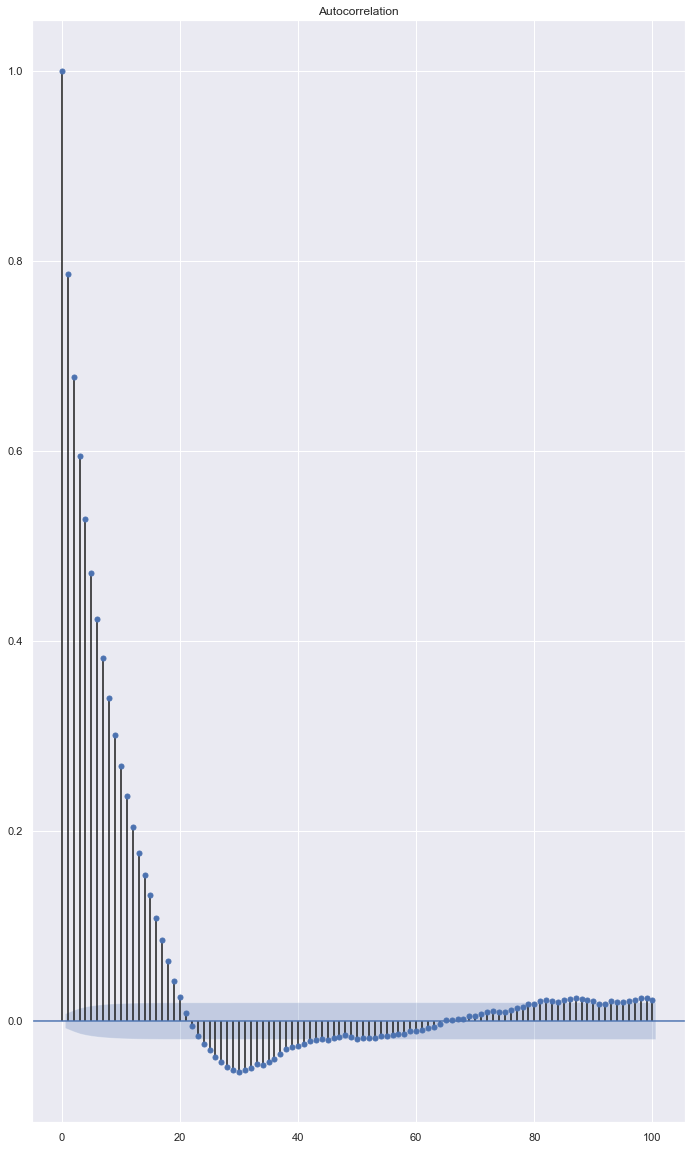

In [1234]:
plot_acf(y, lags=100)
plt.show()

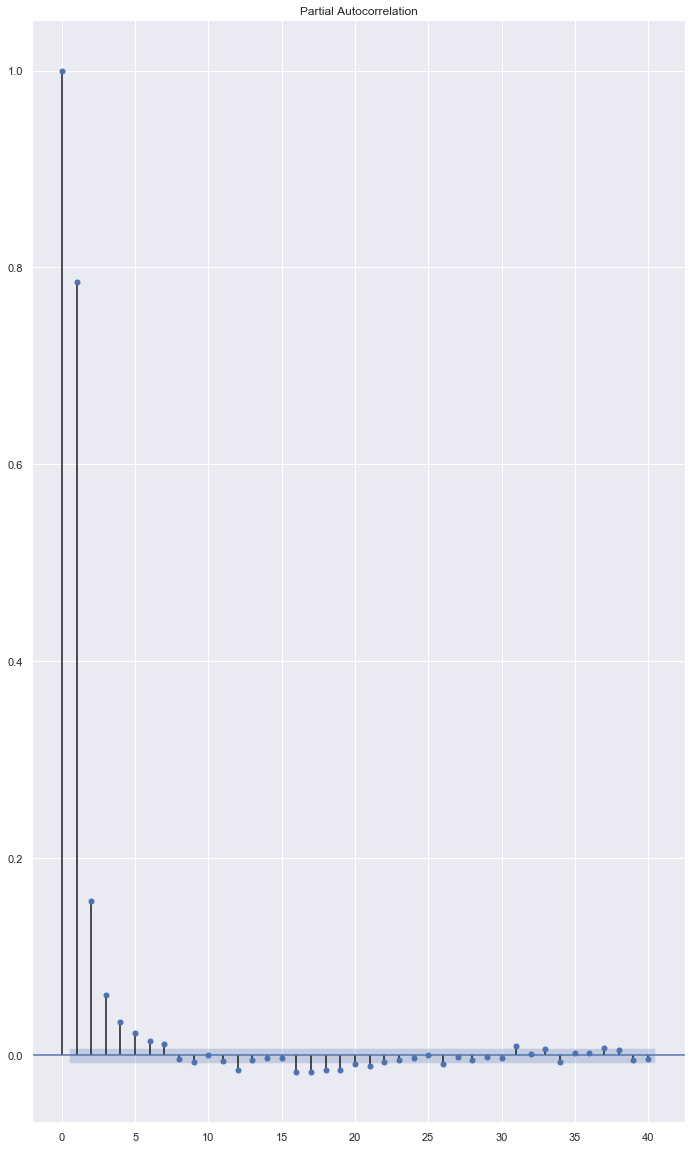

In [1235]:
plot_pacf(y, lags=40)
plt.show()

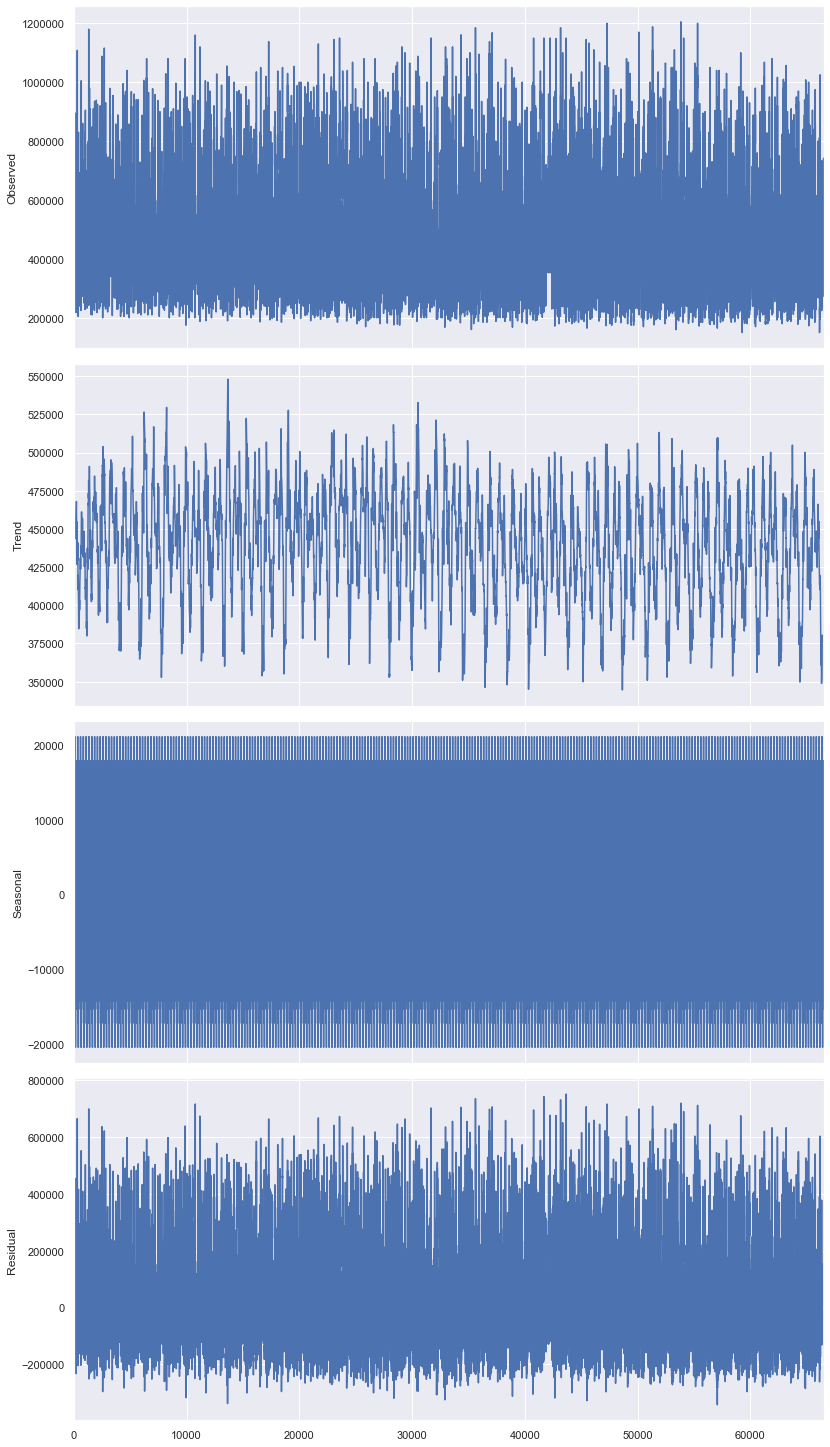

In [1236]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y, model='additive', freq=250)
result.plot()
plt.show()